In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import itertools

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import bottleneck as bn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nxa
import igraph as ig
# http://stackoverflow.com/questions/35279733/what-could-cause-networkx-pygraphviz-to-work-fine-alone-but-not-together
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn import decomposition
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
%matplotlib inline

import missingno as msno
from collections import defaultdict, Counter

from IPython.display import display, Markdown, HTML

from speclib.loaders import (loadUserPhonenumberDict, getUserList, Useralias,
                             loadUserParallel, dict2DataFrame, users2DataFrame)
from speclib.plotting import looseAxesLimits, barSBS, countsOnBarPlot, plotNeatoGraph, nxQuickDraw
from speclib.graph import networkx2igraph, igraph2networkx, userDF2nxGraph, userDF2activityDataframe
from speclib.misc import nanEqual, timedelta2unit, standardizeData


for k, v in {'font.size': 13.0,
             'legend.fontsize': 13.0,
             'axes.labelsize': 12.0,
             'axes.titlesize': 15.0,
             'figure.figsize': [16.0, 7.0],
             'figure.dpi': 200,
             'figure.titlesize': 'large',
             'xtick.labelsize': 13.0,
             'ytick.labelsize': 13.0}.items():
    mpl.rcParams[k] = v

%load_ext watermark
%watermark -a "Allan Leander Rostock Hansen" -u -d -v -p numpy,bottleneck,pandas,matplotlib,sklearn,missingno,networkx,igraph

Allan Leander Rostock Hansen 
last updated: 2017-03-03 

CPython 3.5.3
IPython 5.1.0

numpy 1.12.0
bottleneck 1.2.0
pandas 0.19.1
matplotlib 2.0.0
sklearn 0.18.1
missingno 0.3.4
networkx 2.0.dev_20170215140237
igraph 0.7.1


# Loading and Cleaning the Data

## Loading the Data

Load user SMS and call data.
Load binary datastrucctures stored on disk if they exist and otherwise load the data from the original files.

In [2]:
if os.path.isfile('phone_df.h5'):
    df = pd.io.pytables.read_hdf('phone_df.h5', 'df')
    import pickle
    with open('useralias.pk', 'br') as fid:
        ua = pickle.load(fid)
else:
    ua = Useralias()
    userSpec = [(user, ua[user], ('sms', 'call')) for user in getUserList()]
    userData = loadUserParallel(userSpec) 
    df = users2DataFrame(userData, ua)
    del userData
phonebook = loadUserPhonenumberDict(ua) 

In [3]:
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN      29.0    15  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN       0.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN      89.0    11  a7a089517b6855c7144c018e74ecced67a99e6f6   
      call     NaN     104.0    13  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   
      call     NaN      32.0    18  36a4861f3f67cbf88b578d77743d1f5a8ddf604f   

                  timeint           timestamp  weekday  
user  comtype                                           
u0001 call     1386255771 2013-12-05 15:02:51        3  
      call     1386330792 2013-12-06 11:53:12        4  
      call     1386330838 2013-12-06 11:53:58        4  
      call     1386509631 2013-12-08 13:33:51        6  
      call     1386526906 2013-12-08 18:21:46        6

## Cleaning data

Make a subset of the data only containing communications contained within the Social Frabric project. Of this data, select a subset of the data containing the most active users, preferebly who communicate with each other… a clique percolation algorithm could be used for this, but that won't be the initial approach.

A measure of the activity could simply be
$$ a = \sum_{\text{i}}\frac{\mathrm{user_{sms}}_i}{\sum_i \mathrm{user_{sms}}_i} + \frac{\mathrm{user_{call}}_i}{\sum_i \mathrm{user_{call}}_i} $$

but this could yield a huge $a$ for a very active, yet weakly connected user, so a weighting with the number of contacted people shoud be introduced.

Another approach is to naively sum up all events between users.

Since a conversation using SMS regesters as several events for both users (usually), whereas a conversation carried out over a call registes as one event, a weighting should be introduced.
The easy solution is to divide the adjacency matrices with the sum of all the entries, meaning that the sum of all the elements would both add up to one.
Yet another approach would be to clean the SMS data in the following way:

1. Investigate the distribution of time between a SMS and a reply to it.
2. Use the distribution to determining a typical reply time.
3. Remove entries in the SMS data which weren't replied to within some number, say 3, times the average reply time.

Cleaning the SMS data as proposed above, should also prompt for a similar cleaning of the call data.
An obvious way would be to remove unansvered calls, albeit the SMS dataset should also be checked for an "answer".

### Doing the data munging

Remove rows for which the contacted number is not present in `phonebook` (userhash to phonehash translation table).

Also add a column which contaings the useralias (`u0001`, `u0345` and so on) for the contacted user.

In [4]:
df = df[df.number.apply(lambda num: num in phonebook)] 
df['contactedUser'] = df.number.apply(lambda x: phonebook[x]) 
df.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0001 call     NaN       0.0     1  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN       0.0    14  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN      29.0    14  55f088fd3f0b8d0497eb8e47dbf501721eb2e927   
      call     NaN      22.0    14  a1839538e5d09dd68a576f1ee2c2611ac0c4f451   
      call     NaN       3.0    14  55f088fd3f0b8d0497eb8e47dbf501721eb2e927   

                  timeint           timestamp  weekday contactedUser  
user  comtype                                                         
u0001 call     1390698006 2014-01-26 01:00:06        6         u0493  
      call     1391176805 2014-01-31 14:00:05        4         u0493  
      call     1391782631 2014-02-07 14:17:11        4         u0117  
      call     1391782712 2014-02-07 14:18:32        4         u0493  
      call     1394805935 2014-03-14 14:05:35        4         u0117

Count number of unique contacts for each user.
This is what's called the degree distribution in graph theory.

In [5]:
userUniqueCommCall = dict()   # dict for calls
userUniqueCommSms = dict()  # dict for sms
for user in df.index.get_level_values('user').unique():  # loop over users
    try:  # 'call' data might be missing from some users
        comSer = df.loc[user, 'call'].contactedUser
        userUniqueCommCall[user] = comSer.unique().size
    except KeyError:
        userUniqueCommCall[user] = 0
    try:  # 'sms' data might be missing from some users
        comSer = df.loc[user, 'sms'].contactedUser
        userUniqueCommSms[user] = comSer.unique().size
    except KeyError:
        userUniqueCommSms[user] = 0

userUniqueComm = pd.DataFrame(pd.Series(userUniqueCommCall), columns=('call',))
userUniqueComm['sms'] = pd.Series(userUniqueCommSms)
userUniqueComm['total'] = userUniqueComm.sms + userUniqueComm.call
del userUniqueCommCall
del userUniqueCommSms

userUniqueComm.sort(columns='total', inplace=True, ascending=False)
display(userUniqueComm.head(), userUniqueComm.describe()) 

call  sms  total
u0324    43   40     83
u0122    33   26     59
u0758    28   28     56
u0128    29   26     55
u0287    29   23     52

call         sms       total
count  782.000000  782.000000  782.000000
mean     4.787724    5.127877    9.915601
std      4.784573    4.446180    9.018719
min      0.000000    0.000000    1.000000
25%      2.000000    2.000000    4.000000
50%      4.000000    4.000000    7.000000
75%      6.000000    7.000000   13.000000
max     43.000000   40.000000   83.000000

Plot the findings, using two different plot styles, using both normal and log scaling.

(<matplotlib.text.Text at 0x7f6d8116f400>,
 <matplotlib.text.Text at 0x7f6d8117c390>)

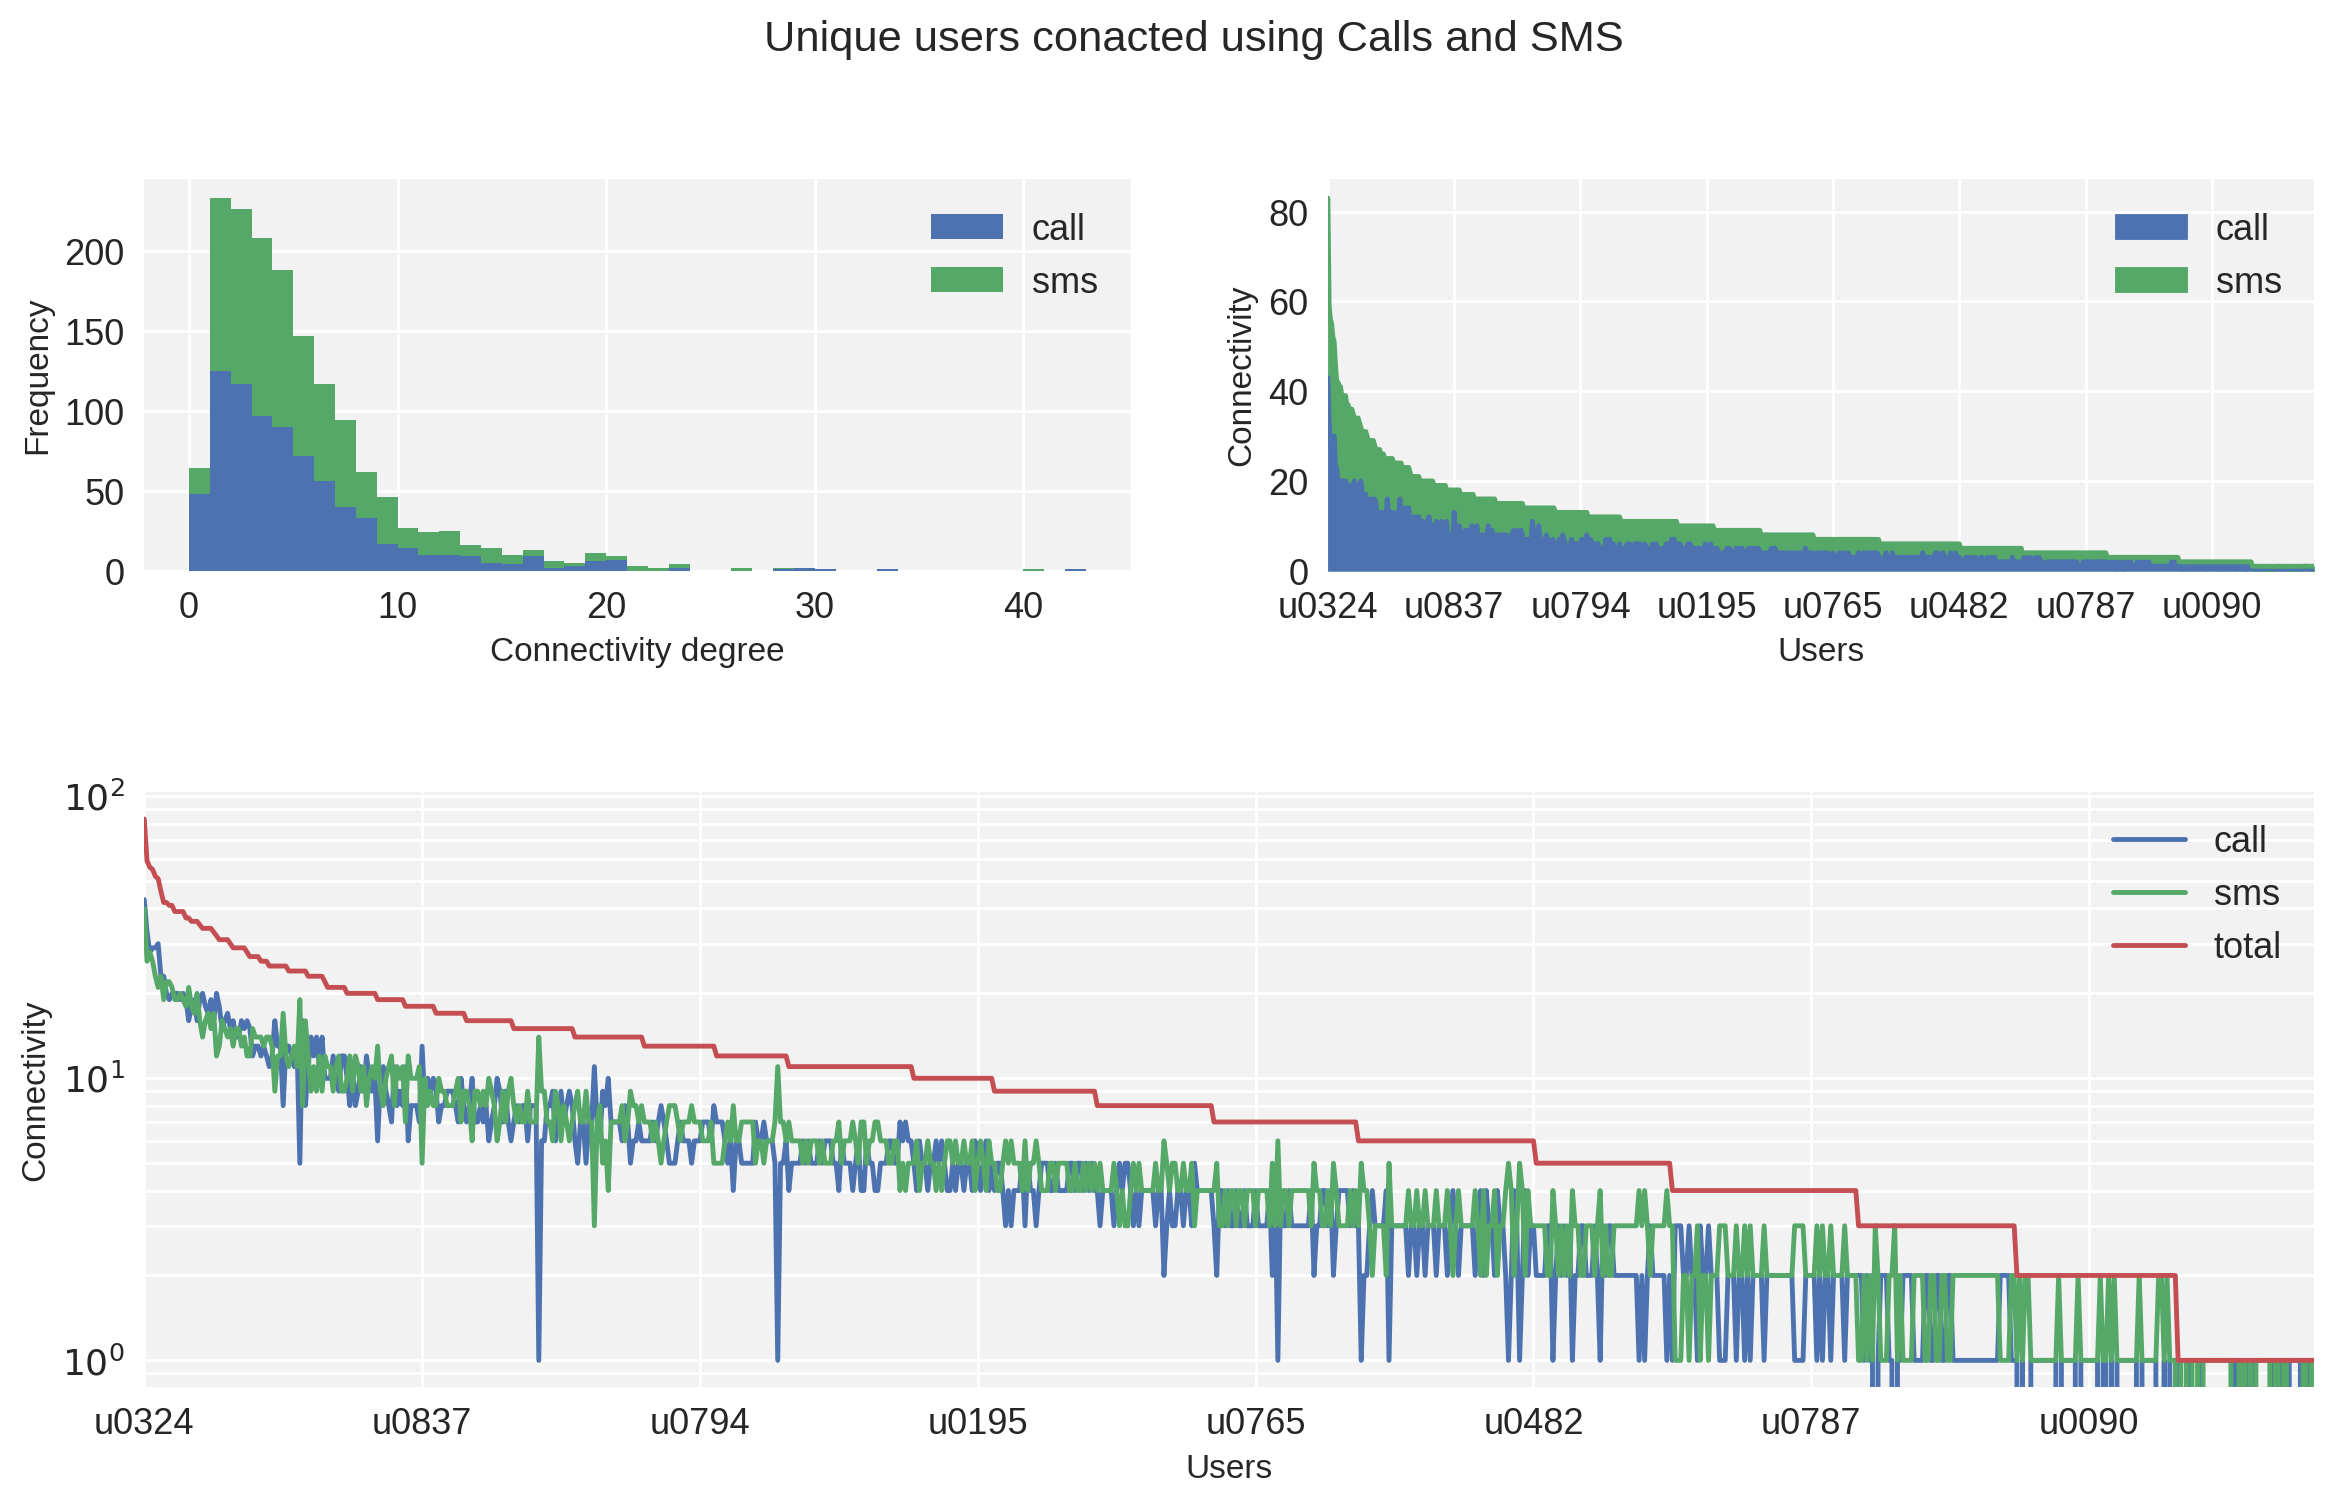

In [6]:
fig = plt.figure(figsize=(14, 8))
ax0 = (plt.subplot2grid((12, 2), (0, 0), rowspan=4))
ax1 = (plt.subplot2grid((12, 2), (0, 1), rowspan=4))
ax2 = (plt.subplot2grid((12, 2), (6, 0), colspan=4, rowspan=9))

# Normal scaling
# userUniqueComm.plot.line(ax=ax0) 
# userUniqueComm.total.value_counts().plot.hist(bins=(userUniqueComm.total.max()), ax=ax0) 
userUniqueComm.drop('total', axis=1).plot.hist(bins=userUniqueComm.drop('total', axis=1).max().max(),
                                               stacked=True,
                                               ax=ax0)
ax0.set_xlabel('Connectivity degree')
userUniqueComm.drop('total', axis=1).plot.area(ax=ax1)
ax1.set_xlabel('Users'), ax1.set_ylabel('Connectivity')
fig.suptitle('Unique users conacted using Calls and SMS')

# Log scaling
userUniqueComm.plot.line(ax=ax2) 
ax2.set_yscale('log')
ax2.grid(which='minor') 
ax2.set_xlabel('Users'), ax2.set_ylabel('Connectivity')

A threshold of 20 unique contacts is used to select the most active users

In [7]:
totalCommunicationThreshold = 20
chosenUsers = userUniqueComm.index[userUniqueComm.total > totalCommunicationThreshold]
print(*chosenUsers, sep='\t')

u0324	u0122	u0758	u0128	u0287	u0808	u0930	u0226	u0392	u0859	u0318	u0813	u0073	u0241	u0612	u0438	u0267	u0361	u0568	u0002	u0844	u0574	u0491	u0233	u0473	u0993	u0146	u0893	u0503	u0176	u0211	u0140	u0441	u0632	u0719	u0630	u0314	u0307	u0777	u0256	u0583	u0884	u0342	u1010	u0083	u0132	u0150	u0975	u0922	u0264	u0886	u0228	u0885	u0183	u0937	u0889	u0607	u0786	u0743	u0477	u0684	u0796	u0981	u0017	u0951	u0033	u0311	u0444	u0584	u0896	u1023	u0564	u0343


### Compute adjacency matrices
Construct DataFrames for adjacency matrices/graphs for call and SMS data, where the index is the user initiating contact, and the columns is the users targeted by said contact.
Selected users is limited to previously chosen active users.

In [8]:
adCall = dict()  # dict for user calls
adSms = dict()  # dict for user sms

# for user in df.index.get_level_values('user').unique():
for user in chosenUsers:
    if 'call' in df.loc[user].index:  # user might not have 'call' data
        cnt = df.loc[user, 'call'].contactedUser.value_counts()
        adCall[user] = cnt.to_dict()
    if 'sms' in df.loc[user].index:  # user might not have 'sms' data
        cnt = df.loc[user, 'sms'].contactedUser.value_counts()
        adSms[user] = cnt.to_dict() 

# Convert dicts to DataFrames and label the index and columns.
adCall = pd.DataFrame(adCall)
adSms = pd.DataFrame(adSms)
adCall.columns.name = 'userRec'
adSms.columns.name = 'userRec'
adCall.index.name = 'userInit'
adSms.index.name = 'userInit'

# Drop contacted users which are'nt preset in the index (contact initating users) 
adCall.drop(list(set(adCall.columns) - set(adCall.index)), axis=1, inplace=True) 
adSms.drop(list(set(adSms.columns) - set(adSms.index)), axis=1, inplace=True) 

Add a column where the activity level for each user is summed up.

In [9]:
adCall['activity'] = adCall.sum(axis=0, skipna=True)
adSms['activity'] = adSms.sum(axis=0, skipna=True)

# Sort the columns so that the 'activity' column is a the start of the Data Frame
adCall.columns = adCall.columns.sort_values()
adSms.columns = adSms.columns.sort_values() 

display(adCall.head(), adSms.head()) 

userRec   activity  u0002  u0017  u0073  u0083  u0128  u0132  u0140  u0146  \
userInit                                                                     
u0001          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0002          2.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0004          NaN    NaN    1.0    NaN    NaN    NaN    NaN    8.0    NaN   
u0008          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0011          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

userRec   u0150  ...    u0896  u0922  u0930  u0937  u0951  u0975  u0981  \
userInit         ...                                                      
u0001       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0002       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0004       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0008       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0011       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   

userRec   u0993  u1010  u1023  
userInit                       
u0001       NaN    NaN    NaN  
u0002       NaN    NaN   68.0  
u0004       NaN    NaN    NaN  
u0008       NaN    NaN    NaN  
u0011       NaN    NaN    NaN  

[5 rows x 69 columns]

userRec   activity  u0002  u0017  u0073  u0083  u0128  u0132  u0140  u0146  \
userInit                                                                     
u0001          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0002          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0004          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0008          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0011          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

userRec   u0150  ...    u0896  u0922  u0930  u0937  u0951  u0975  u0981  \
userInit         ...                                                      
u0001       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0002       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0004       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0008       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0011       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   

userRec   u0993  u1010  u1023  
userInit                       
u0001       NaN    NaN    NaN  
u0002       NaN    NaN  276.0  
u0004       NaN    NaN    NaN  
u0008       NaN    NaN    NaN  
u0011       NaN    NaN    NaN  

[5 rows x 69 columns]

### Construct graph objects
A NetworkX graph is constructed from the DataFrame with the adjacency-matrix like data.
The call and sms data is combined.

In [10]:
adf = adCall + adSms
adf.head() 

userRec   activity  u0002  u0017  u0073  u0083  u0128  u0132  u0140  u0146  \
userInit                                                                     
u0001          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0002          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0004          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0008          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0011          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

userRec   u0150  ...    u0896  u0922  u0930  u0937  u0951  u0975  u0981  \
userInit         ...                                                      
u0001       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0002       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0004       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0008       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   
u0011       NaN  ...      NaN    NaN    NaN    NaN    NaN    NaN    NaN   

userRec   u0993  u1010  u1023  
userInit                       
u0001       NaN    NaN    NaN  
u0002       NaN    NaN  344.0  
u0004       NaN    NaN    NaN  
u0008       NaN    NaN    NaN  
u0011       NaN    NaN    NaN  

[5 rows x 69 columns]

In [11]:
dct = dict()  # keys is users which initiate contact (adf.index)
# Remove newthe recently added activity column and make the activity measure binary (int8 for display putposes)
adfNoActivity = (adf[adf.columns[adf.columns != 'activity']] > 0).astype(np.int8)
display(adfNoActivity.head())

for i, iUsr in enumerate(sorted(adf.index.unique())):  # Loop througth sorted user list
    comSeries = adfNoActivity.loc[iUsr]  # Extract user communications
    comSeries = comSeries.index[comSeries.astype(bool)]  # Filter the usernames (index) using the series masking data
    dct[iUsr] = comSeries.tolist()    # Convert Pandas Series to a list
g = nx.from_dict_of_lists(dct)  # costruct graph

# Delete temporary variables
del dct
del adfNoActivity

userRec   u0002  u0017  u0073  u0083  u0128  u0132  u0140  u0146  u0150  \
userInit                                                                  
u0001         0      0      0      0      0      0      0      0      0   
u0002         0      0      0      0      0      0      0      0      0   
u0004         0      0      0      0      0      0      0      0      0   
u0008         0      0      0      0      0      0      0      0      0   
u0011         0      0      0      0      0      0      0      0      0   

userRec   u0176  ...    u0896  u0922  u0930  u0937  u0951  u0975  u0981  \
userInit         ...                                                      
u0001         0  ...        0      0      0      0      0      0      0   
u0002         0  ...        0      0      0      0      0      0      0   
u0004         0  ...        0      0      0      0      0      0      0   
u0008         0  ...        0      0      0      0      0      0      0   
u0011         0  ...        0      0      0      0      0      0      0   

userRec   u0993  u1010  u1023  
userInit                       
u0001         0      0      0  
u0002         0      0      1  
u0004         0      0      0  
u0008         0      0      0  
u0011         0      0      0  

[5 rows x 68 columns]

Plot the network

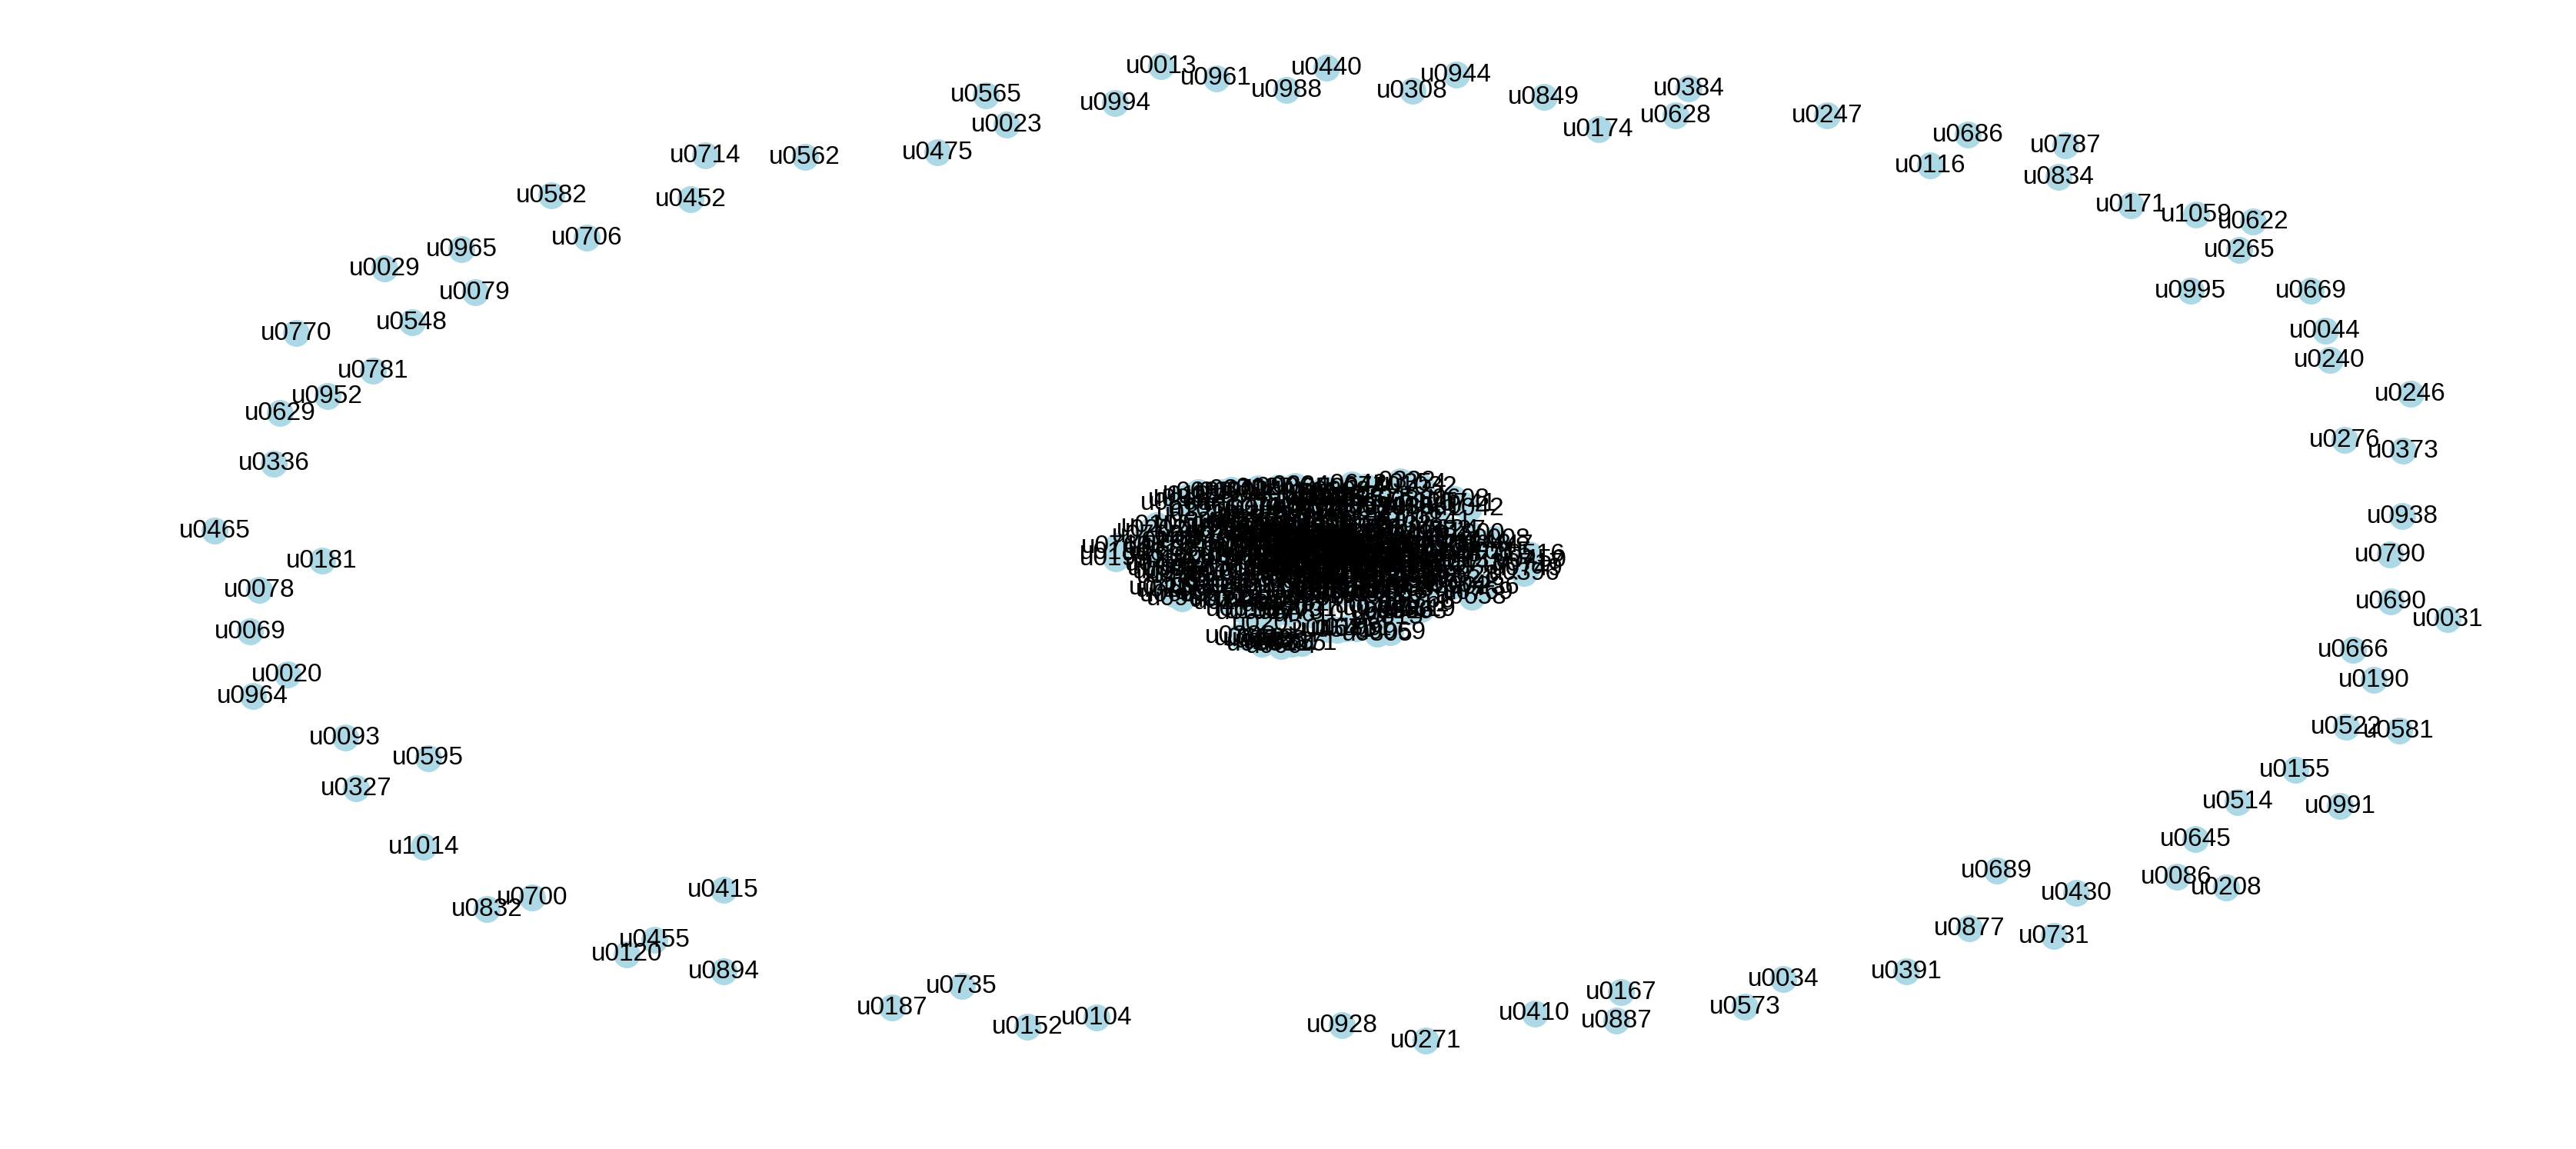

In [12]:
nxQuickDraw(g) 

Clearly some nodes aren't connected to the network – their contacts probably didn't meet the "choose any users with 20 or more individual contacts"-criterion.

Nodes with no connections (that is, nodes with degree 0) are removed.

In [13]:
for node, degree in dict(g.degree()).items():
    if degree == 0:
        g.remove_node(node) 

Verify by plotting the network again

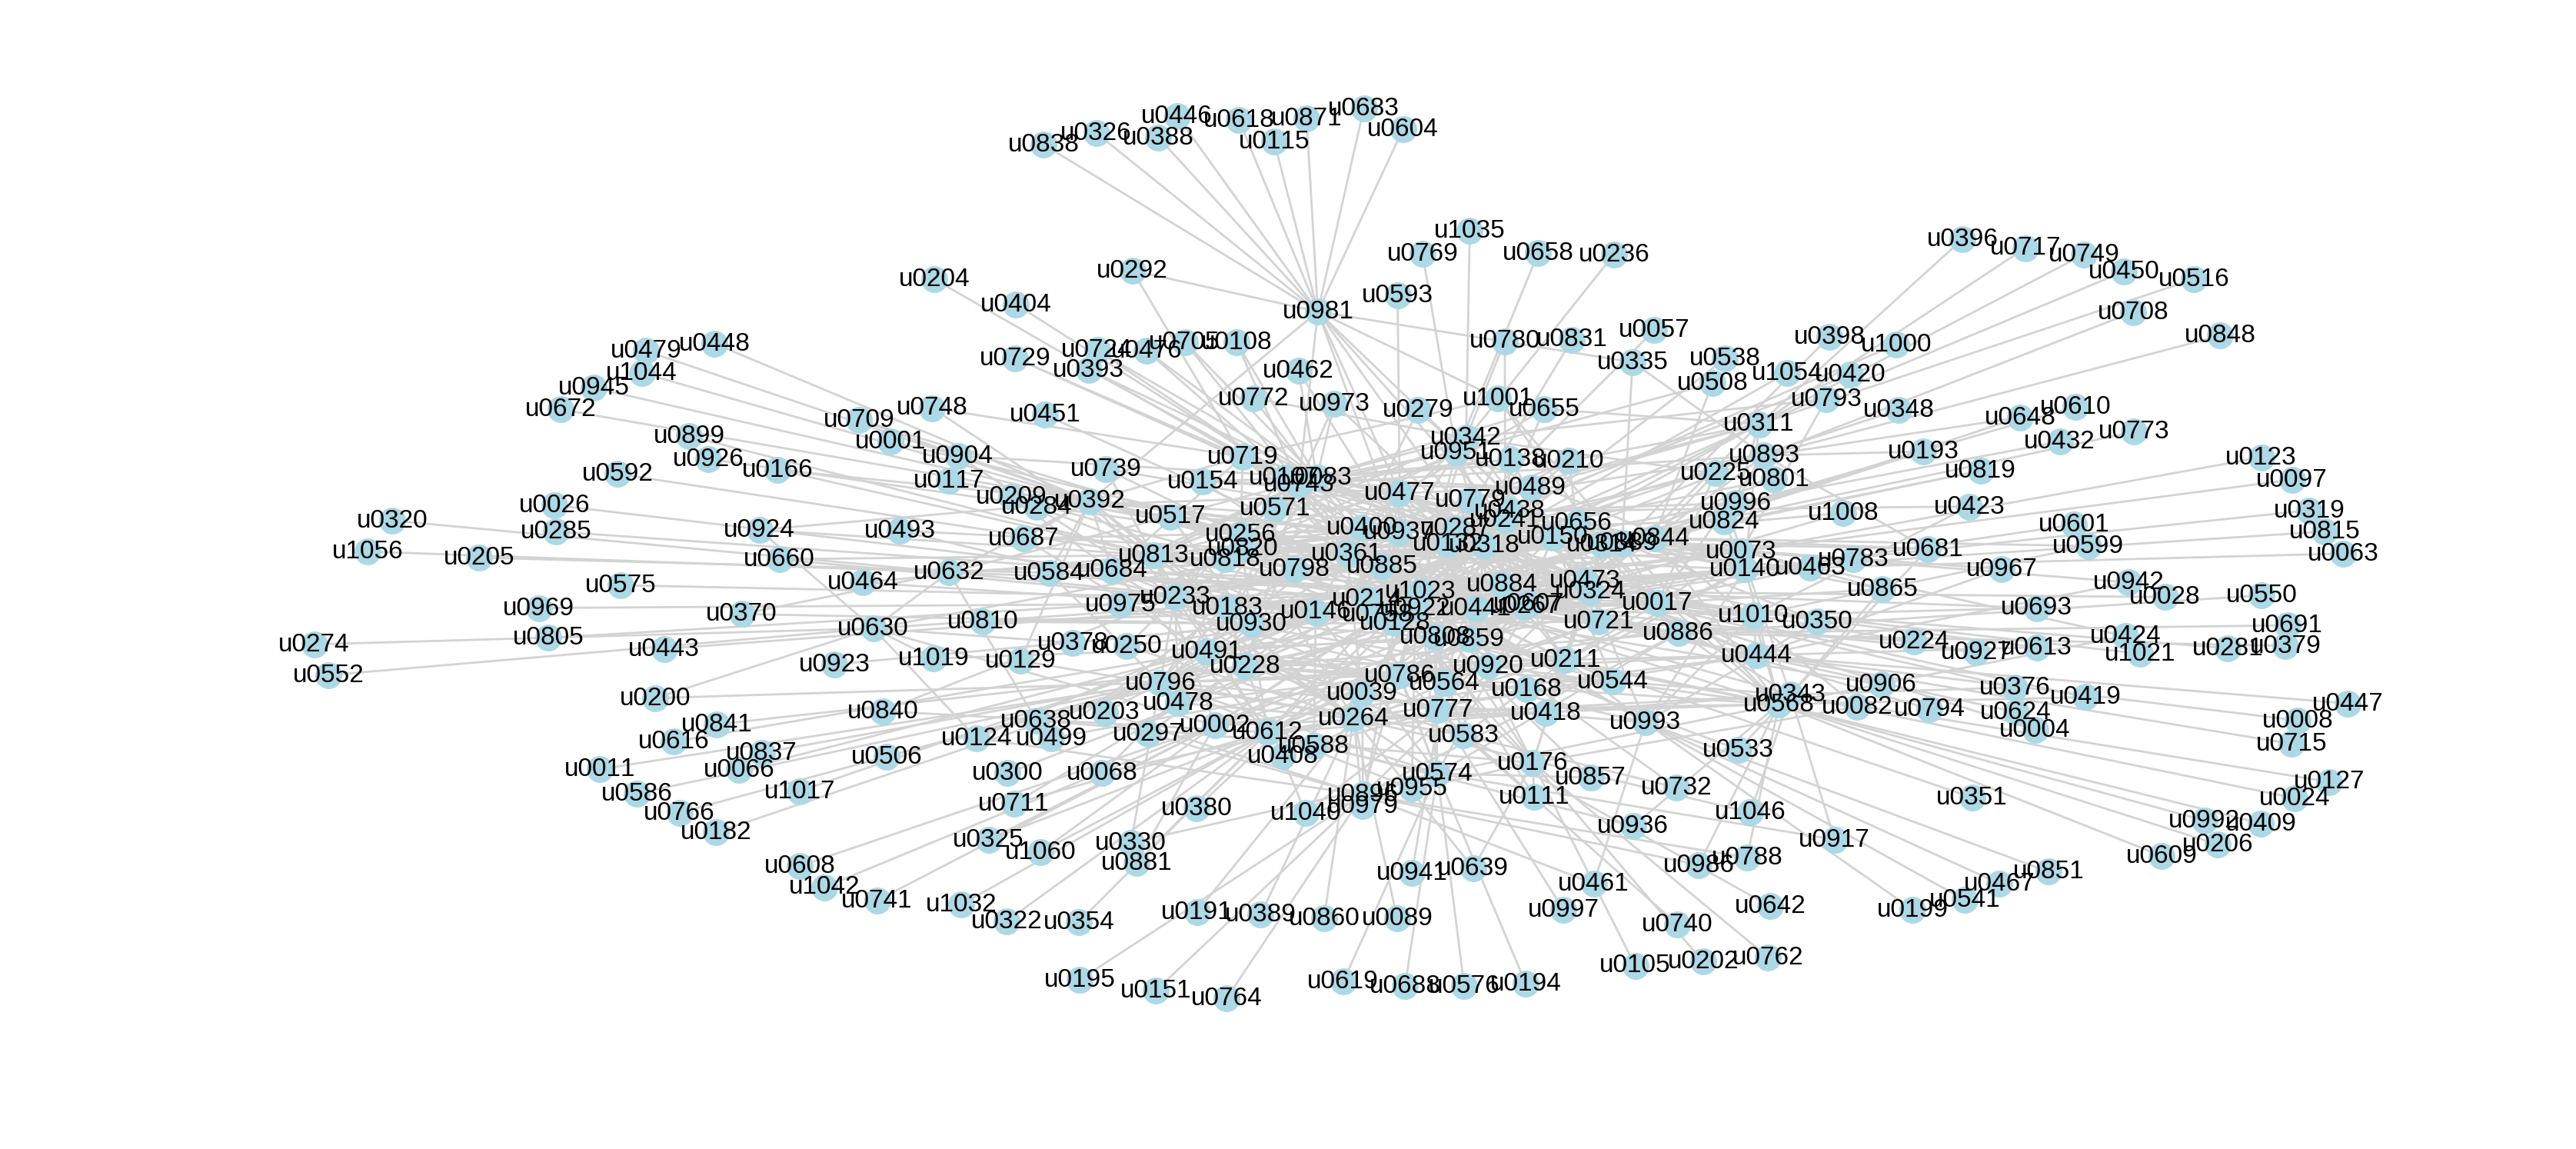

In [14]:
nxQuickDraw(g) 

This indeed looks like nodes with degree 0 are removed.

## Apply clique algorithms to find most active users

<!--
* Two algorithms is used.
* I use the users returned from the biggest groups from both (14 users).
* I also investigate the number overlap inbetween the two algorithms wrt. cliques and users.
-->

### Verify results from NetworkX using the iGraph library

In [15]:
ig = networkx2igraph(g) 

igraphCliques = ig.maximal_cliques() 
igraphCounter = Counter((len(el) for el in igraphCliques)) 
networkxCounter = Counter(len(el) for el in nx.algorithms.find_cliques(g))
if networkxCounter == igraphCounter:
    display(Markdown('Igraph and Networkx yields identical results.'))
else:
    display(Markdown('Igraph and Networkx yields different results!'))

Igraph and Networkx yields identical results.

### Using NetworkX

In [16]:
clqdf = pd.DataFrame(nx.algorithms.find_cliques(g))
clqdf['cliquesize'] = (~clqdf.isnull()).sum(axis=1)
clqdf.sort(columns='cliquesize', ascending=False, inplace=True) 
clqdf.head() 

0      1      2      3      4      5  cliquesize
369  u1023  u0324  u0287  u0441  u0473  u0477           6
367  u1023  u0324  u0287  u0361  u0211   None           5
337  u1023  u0743  u0287  u0324  u0796   None           5
326  u1023  u0241  u0073  u0885  u0922   None           5
296  u1023  u0140  u0361  u0211  u0993   None           5

### Investigate the cliques

Plot clique size distribution

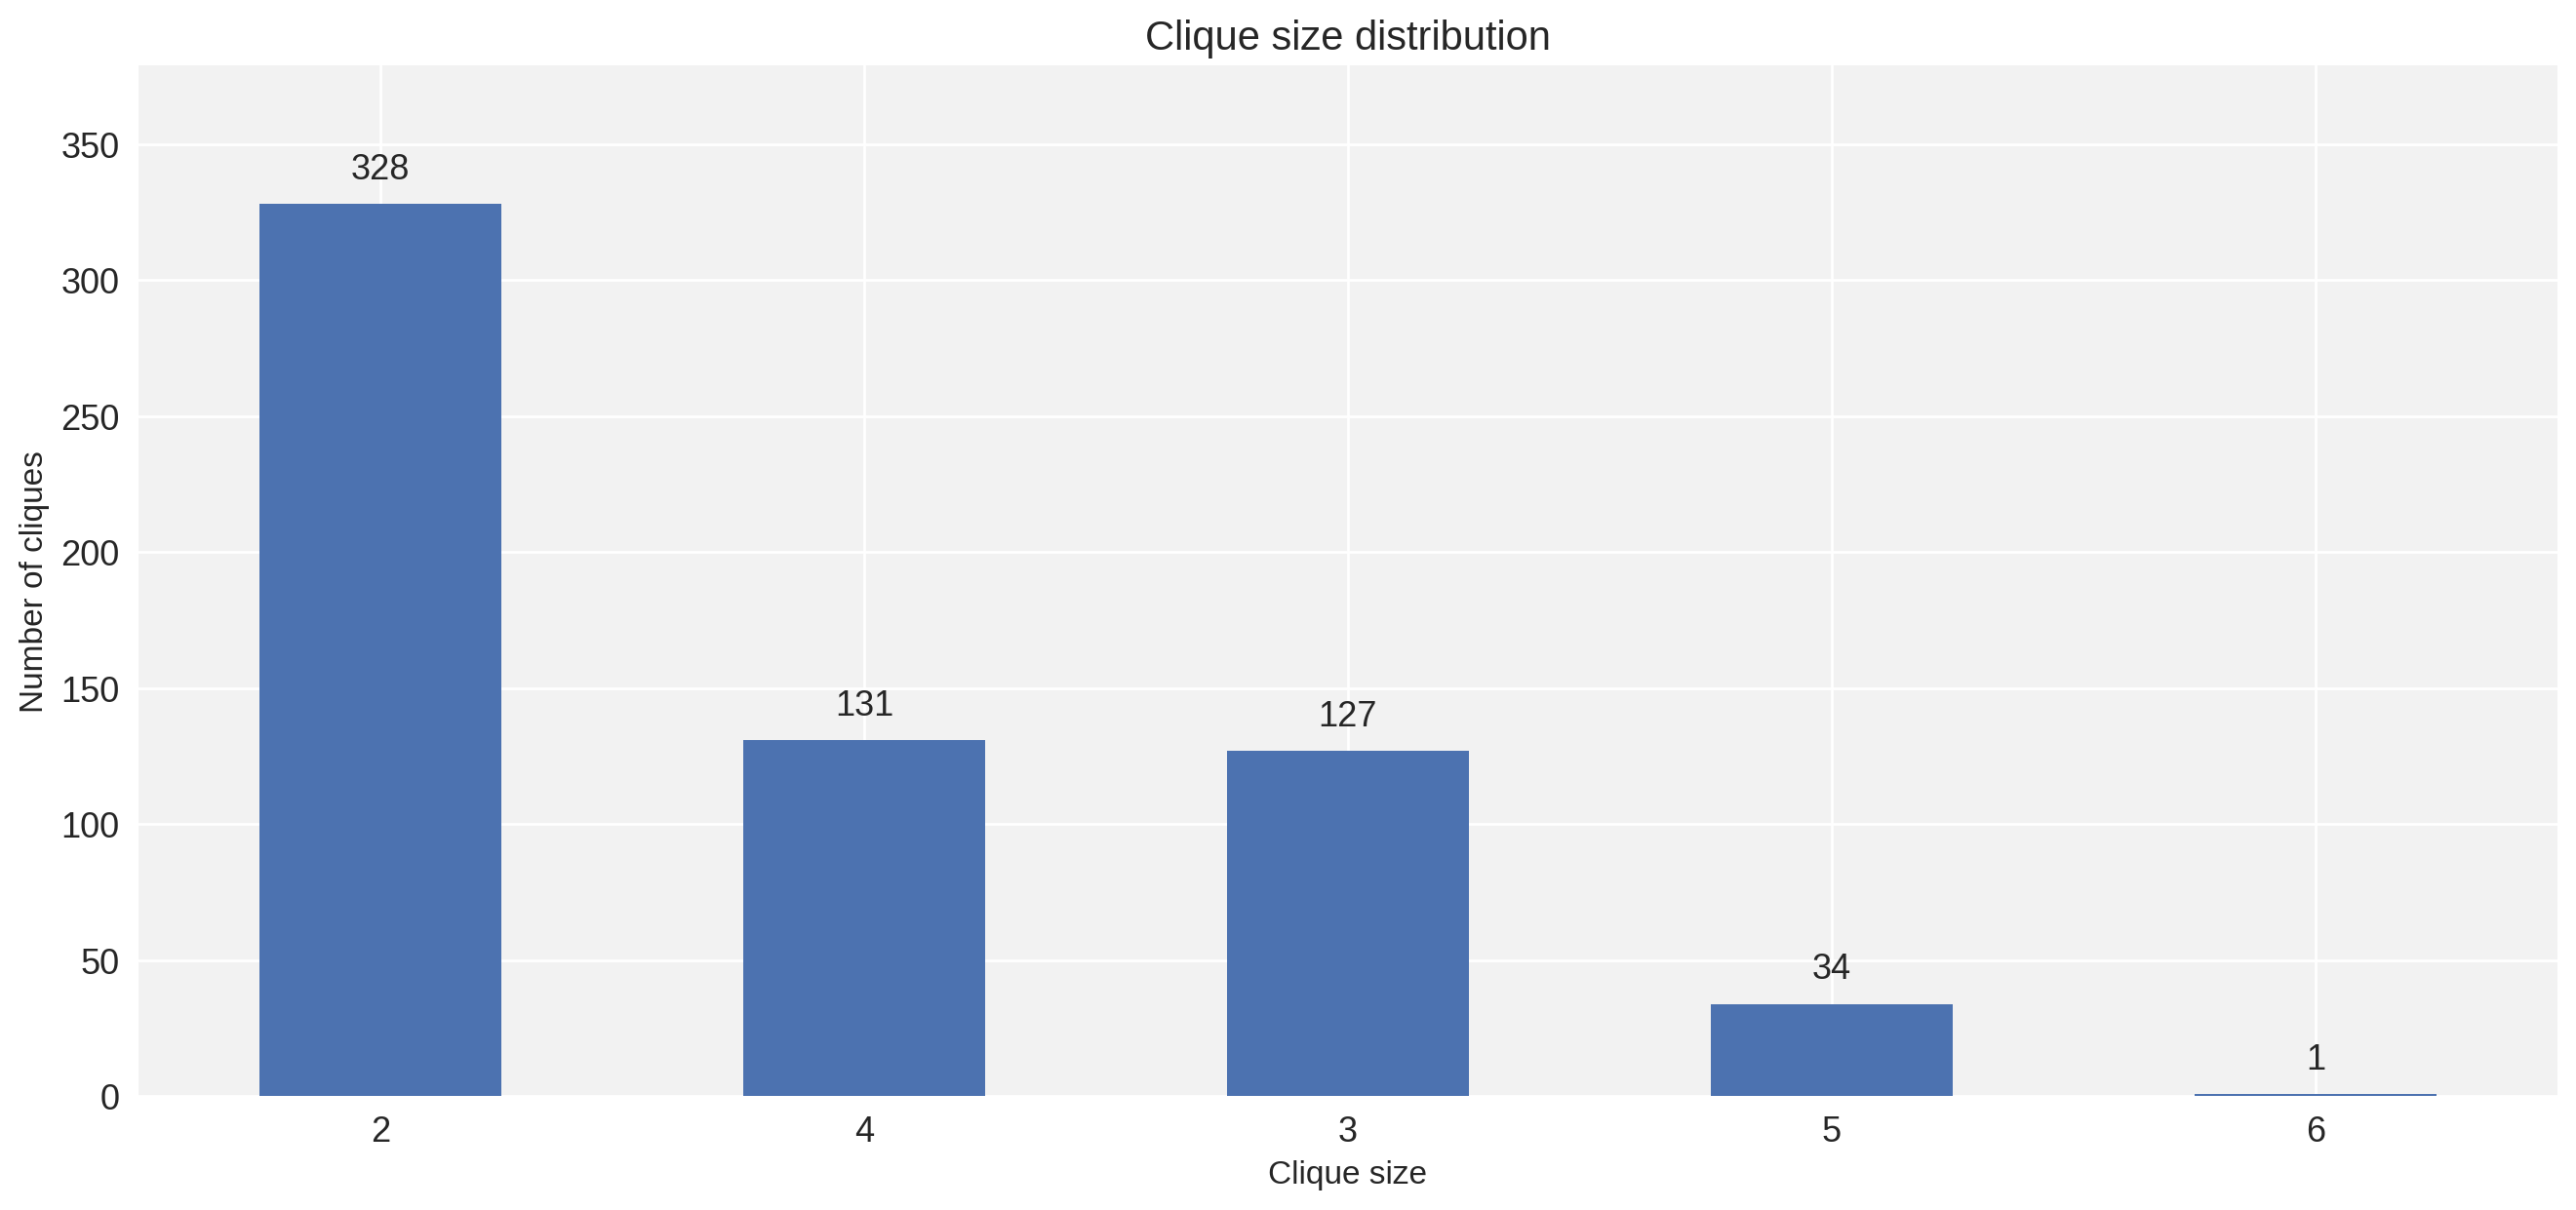

In [17]:
fig, ax = plt.subplots()
clqdf.cliquesize.value_counts().plot.bar(ax=ax, rot=0)
ax.set_title("Clique size distribution")
looseAxesLimits(ax, [0.0, 0.0, 0.0, 0.1])
countsOnBarPlot(ax)
ax.set_xlabel('Clique size')
ax.set_ylabel('Number of cliques') 

What is the average number of connections vs. clique size?
The DataFrame containing the cluques are as follows.

Calculating the mean connectivity and standard deviation for each clique…

In [19]:
lst = list()
for i in range(clqdf.shape[0]):
    nodeArr, cliqueSize = clqdf.iloc[i][:-1], clqdf.iloc[i][-1]
    cliqueConnLst = [el[1] for el in nx.degree(g, nodeArr)]
    lst.append((cliqueSize, np.mean(cliqueConnLst), np.std(cliqueConnLst)))

clqStatDf = pd.DataFrame(lst, columns=['cliqueSize', 'cliqueMean', 'cliqueStd'])
del lst
clqStatDf.head() 

cliqueSize  cliqueMean  cliqueStd
0           6   28.666667  19.128222
1           5   33.600000  18.039956
2           5   35.600000  16.894970
3           5   29.200000  19.913814
4           5   29.400000  19.945927

… and takeing the mean for each group size…

In [20]:
clqStatDfMean = clqStatDf.groupby('cliqueSize').mean()
clqStatDfMean

cliqueMean  cliqueStd
cliqueSize                       
2            10.506098   8.359756
3            26.624672  18.035366
4            32.793893  20.878389
5            33.458824  18.965070
6            28.666667  19.128222

…which can be visualized as a violin plot

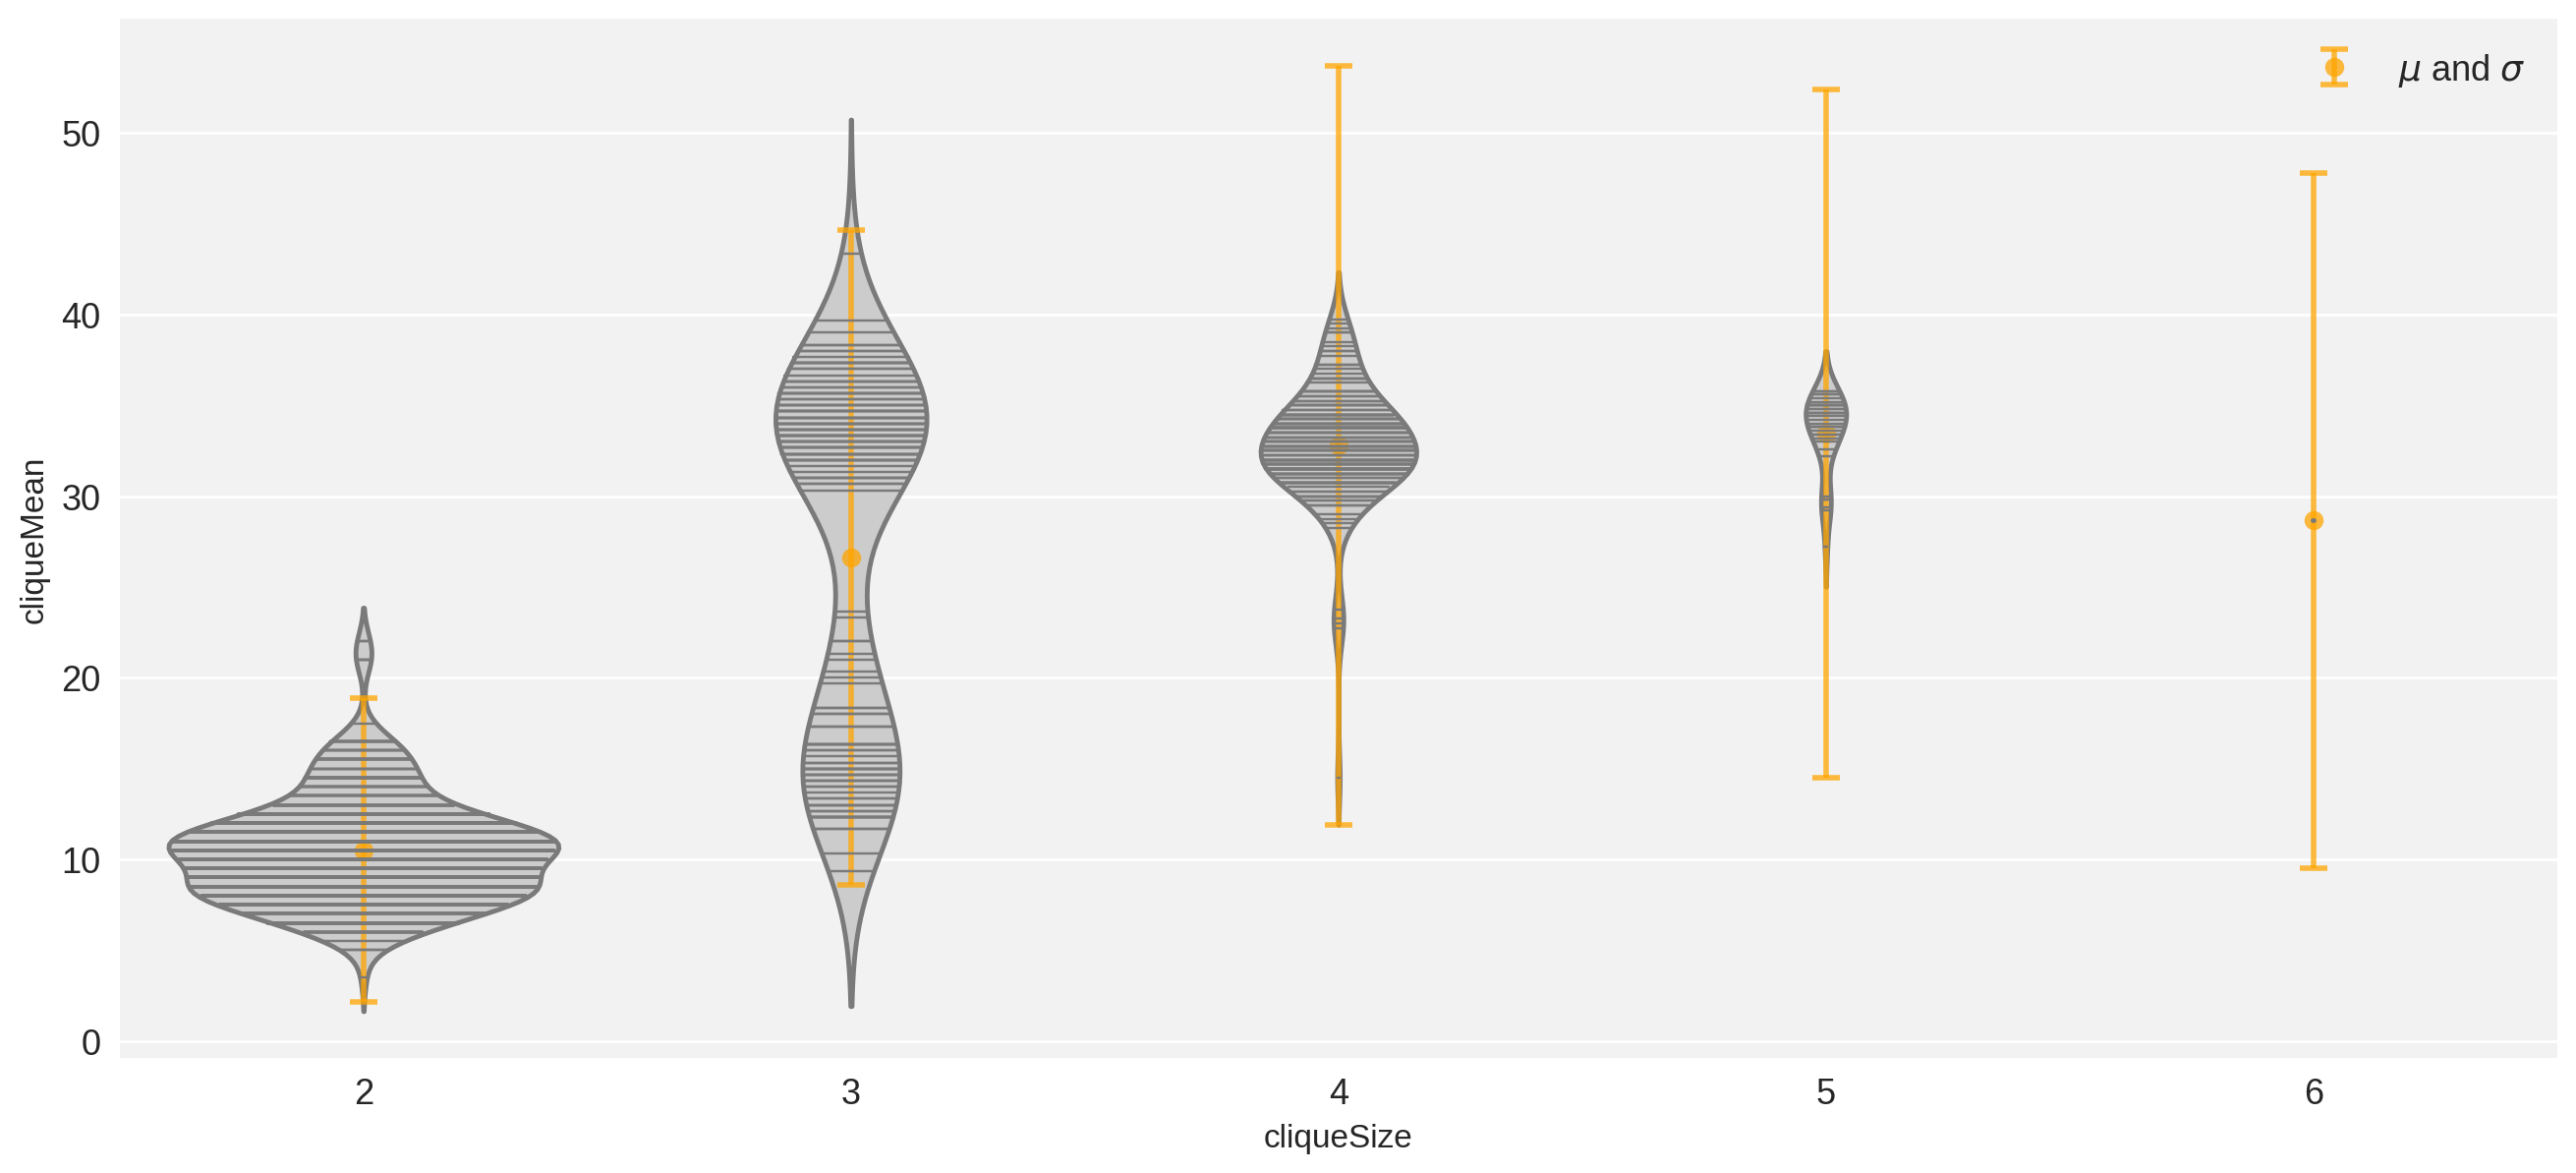

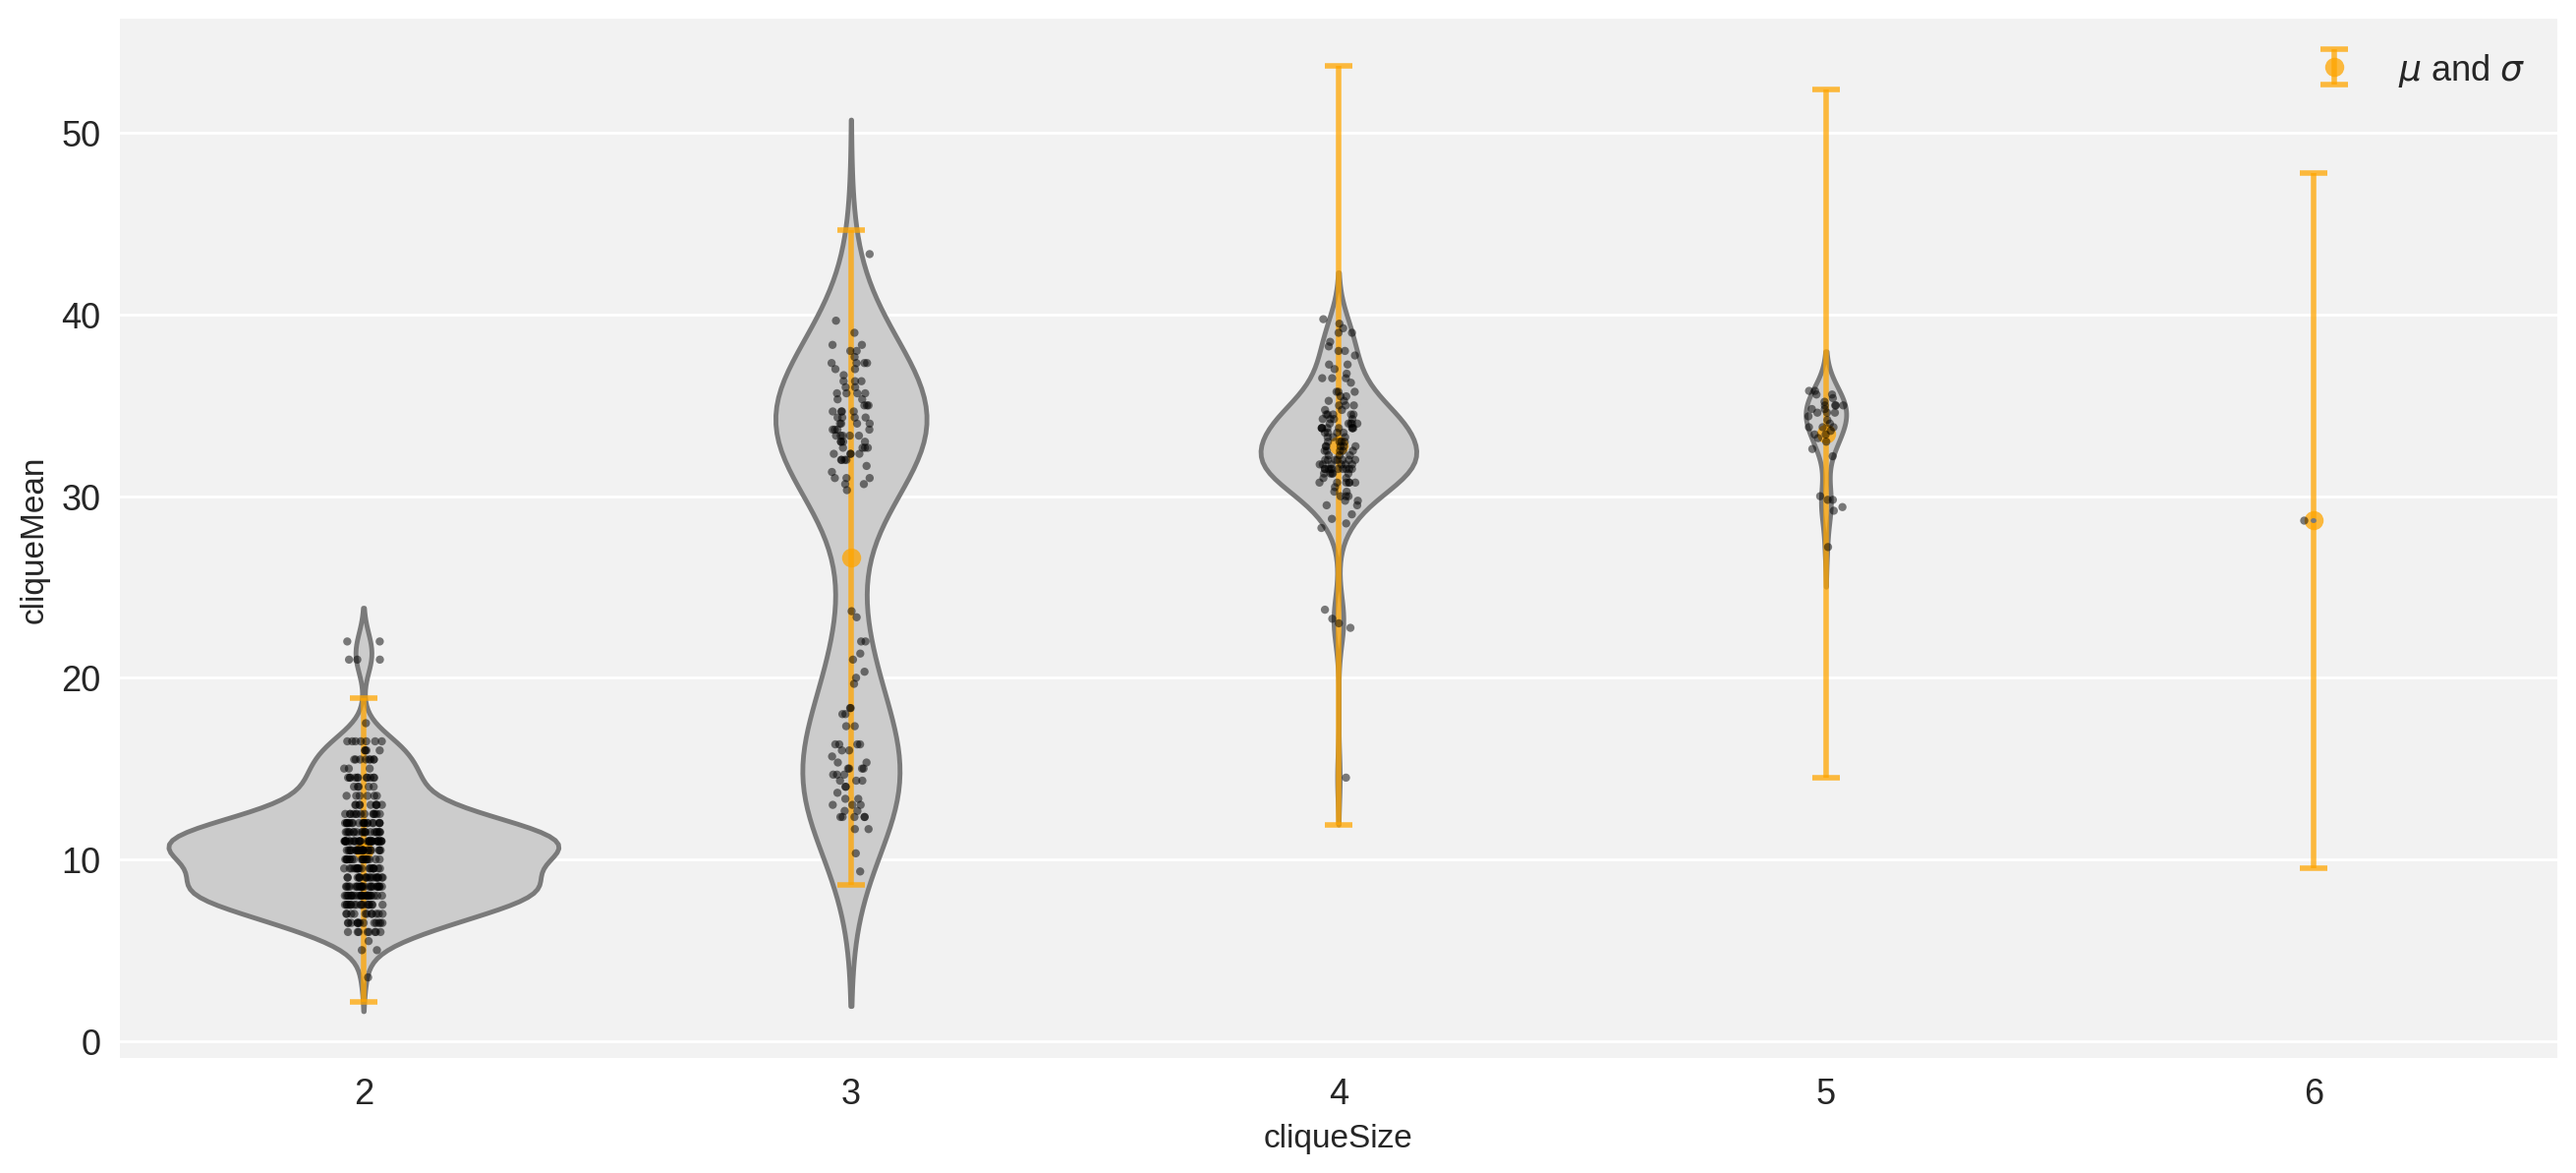

In [21]:
# Violinplot
fig, ax = plt.subplots()
sns.violinplot(x='cliqueSize', y='cliqueMean', data=clqStatDf, split=True, scale='count', inner='stick', color='0.8', ax=ax) 

# Errorbars
(_, caps, _) = ax.errorbar(range(clqStatDfMean.shape[0]), clqStatDfMean.cliqueMean, clqStatDfMean.cliqueStd,
                           fmt='o', color='orange', elinewidth=2, alpha=0.75, barsabove=True,
                           capsize=5, label=r'$\mu$ and $\sigma$')
# Caps on error bars
for cap in caps:
    cap.set_markeredgewidth(2)
    
ax.legend(loc='best')

# Take 2
fig, ax = plt.subplots()
sns.violinplot(x="cliqueSize", y="cliqueMean", data=clqStatDf, inner=None, color="0.8", scale='count', ax=ax)

sns.stripplot(x="cliqueSize", y="cliqueMean", data=clqStatDf, jitter=0.04, ax=ax, color='k', size=3, alpha=0.5)

# Errorbars
(_, caps, _) = ax.errorbar(range(clqStatDfMean.shape[0]), clqStatDfMean.cliqueMean, clqStatDfMean.cliqueStd,
                           fmt='o', color='orange', elinewidth=2, alpha=0.75, barsabove=True, capsize=5,
                           label=r'$\mu$ and $\sigma$')
# Put end caps on the error bars
for cap in caps:
    cap.set_markeredgewidth(2)

ax.legend(loc='best') 

And plotting a histogram of the clique mean accross all clique sizes, clearly shows a bimodal distribution

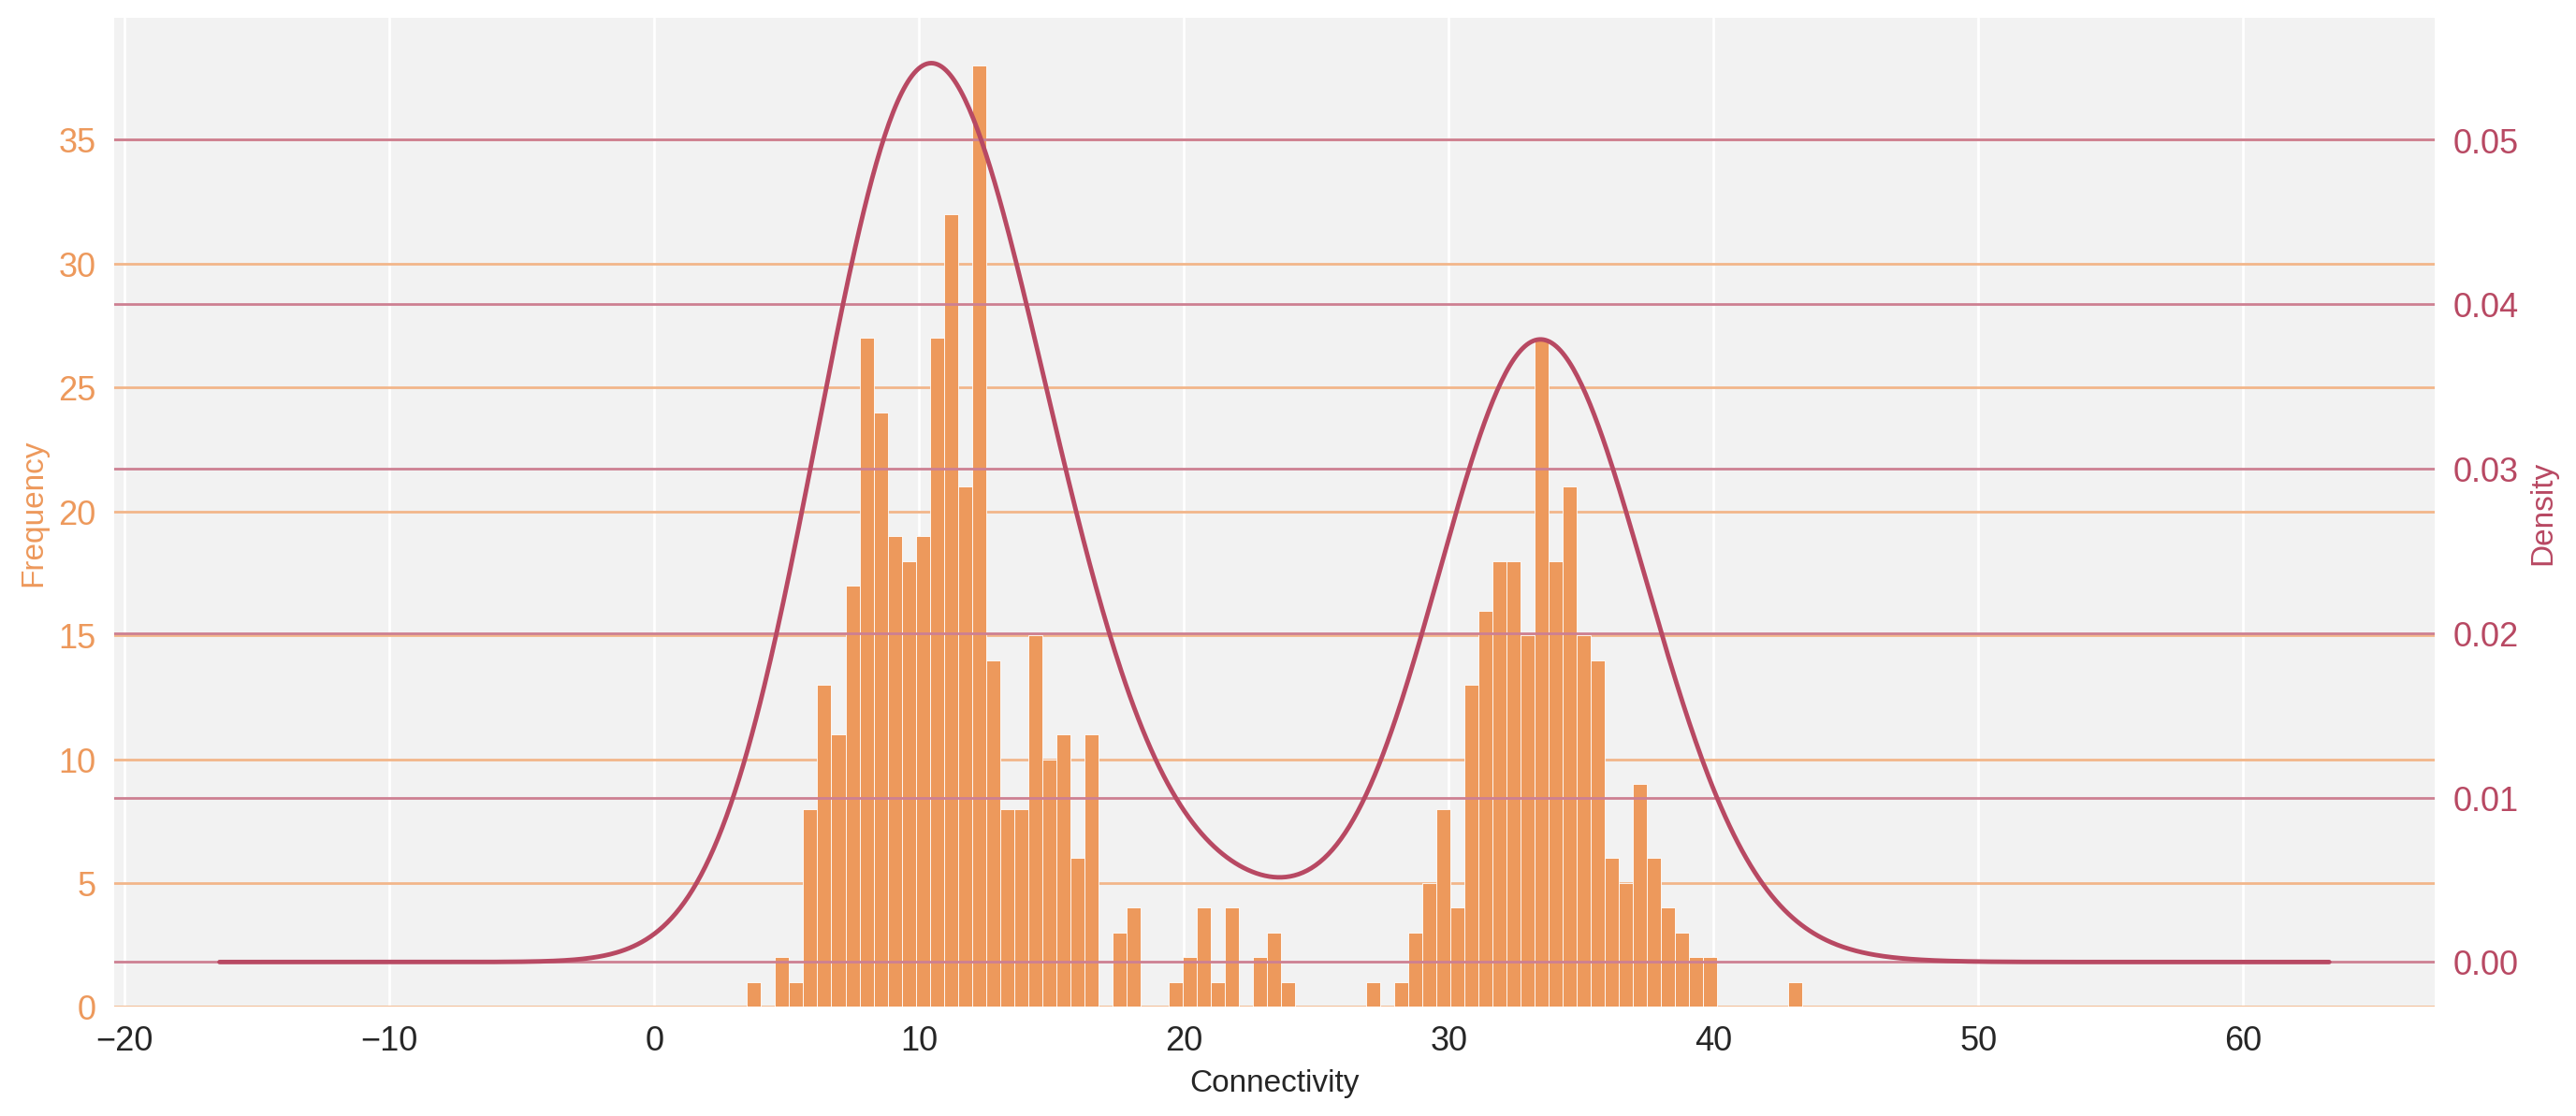

In [137]:
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()
histGridColor = np.array((242, 182, 138))/255
histPlotColor = np.array((237, 153, 92))/255
densGridColor = np.array(((205, 128, 146)))/255
densPlotColor = np.array((184, 73, 99))/255

clqStatDf.cliqueMean.plot.hist(bins=75, ax=ax0, color=histPlotColor, edgecolor='w')
clqStatDf.cliqueMean.plot.density(ax=ax1, color=densPlotColor)
ax0.grid(axis='y', color=histGridColor)
ax1.grid(axis='y', color=densGridColor)
ax0.tick_params(axis='y', colors=histPlotColor)
ax1.tick_params(axis='y', colors=densPlotColor)
ax0.yaxis.label.set_color(histPlotColor)
ax1.yaxis.label.set_color(densPlotColor)
ax0.set_xlabel('Connectivity')

### Choose users from the largest clique: 6
Remove users which are not in a clique with size 6 or larger.

In [23]:
clqdf = clqdf[clqdf.cliquesize >= 6]
clqdf.head() 

0      1      2      3      4      5  cliquesize
369  u1023  u0324  u0287  u0441  u0473  u0477           6

* Make an array containing all the users in the selected clique(s) only once.
* From that array, generate a new array which includes all the contacts of those users.
* Extract a subgraph for those users.

In [24]:
coreUsers = pd.Series(clqdf.drop('cliquesize', axis=1).values.flat).dropna().unique()  # Unique list of chosen users
remoteUsers = [tuple(nx.neighbors(g, user)) for user in coreUsers]  # Chosen users neighbours
remoteUsers = pd.Series(pd.DataFrame(remoteUsers).values.flat).dropna().unique()  # Make the array elements unique

# Print the choice and the lengths of the array
print('Core users in network ({} users):'.format(coreUsers.size))
print(*coreUsers, sep='\t', end='\n'*2)
print('Core users and their connections ({} users):'.format(remoteUsers.size))
print(*remoteUsers, sep='\t', end='\n'*2)

Core users in network (6 users):
u1023	u0324	u0287	u0441	u0473	u0477

Core users and their connections (92 users):
u0758	u0813	u0684	u0630	u0392	u0564	u0438	u0930	u0884	u0844	u0632	u0132	u0583	u0951	u0287	u0264	u0719	u0491	u0083	u0140	u0211	u0150	u0886	u0743	u0256	u0228	u0233	u0342	u0975	u0981	u0073	u0568	u0612	u0324	u0473	u0786	u0267	u0241	u0441	u0017	u0777	u0993	u0343	u0311	u0885	u0893	u0796	u0477	u0937	u0176	u0146	u0314	u0318	u0584	u0607	u0002	u0361	u0183	u0859	u1023	u0922	u0896	u0128	u0444	u0808	u0574	u0889	u1010	u0378	u0376	u0571	u0613	u0004	u0039	u0693	u1021	u0028	u0057	u0739	u0824	u0687	u0420	u0996	u0210	u0463	u0138	u0593	u0489	u0400	u0284	u0655	u0154



Ensure that the core users are included in the remote users

In [104]:
if set(coreUsers).issubset(set(remoteUsers)):
    display(Markdown('All core users are contained in remote users.'))
else:
    display(Markdown('Remember to combine core users and remote users for subgraph extraction!'))

All core users are contained in remote users.

This is expected, since the core users is a clique, and thus will be included among the links from the other users in the clique.

Make the subgraph, and verify it by plotting it.

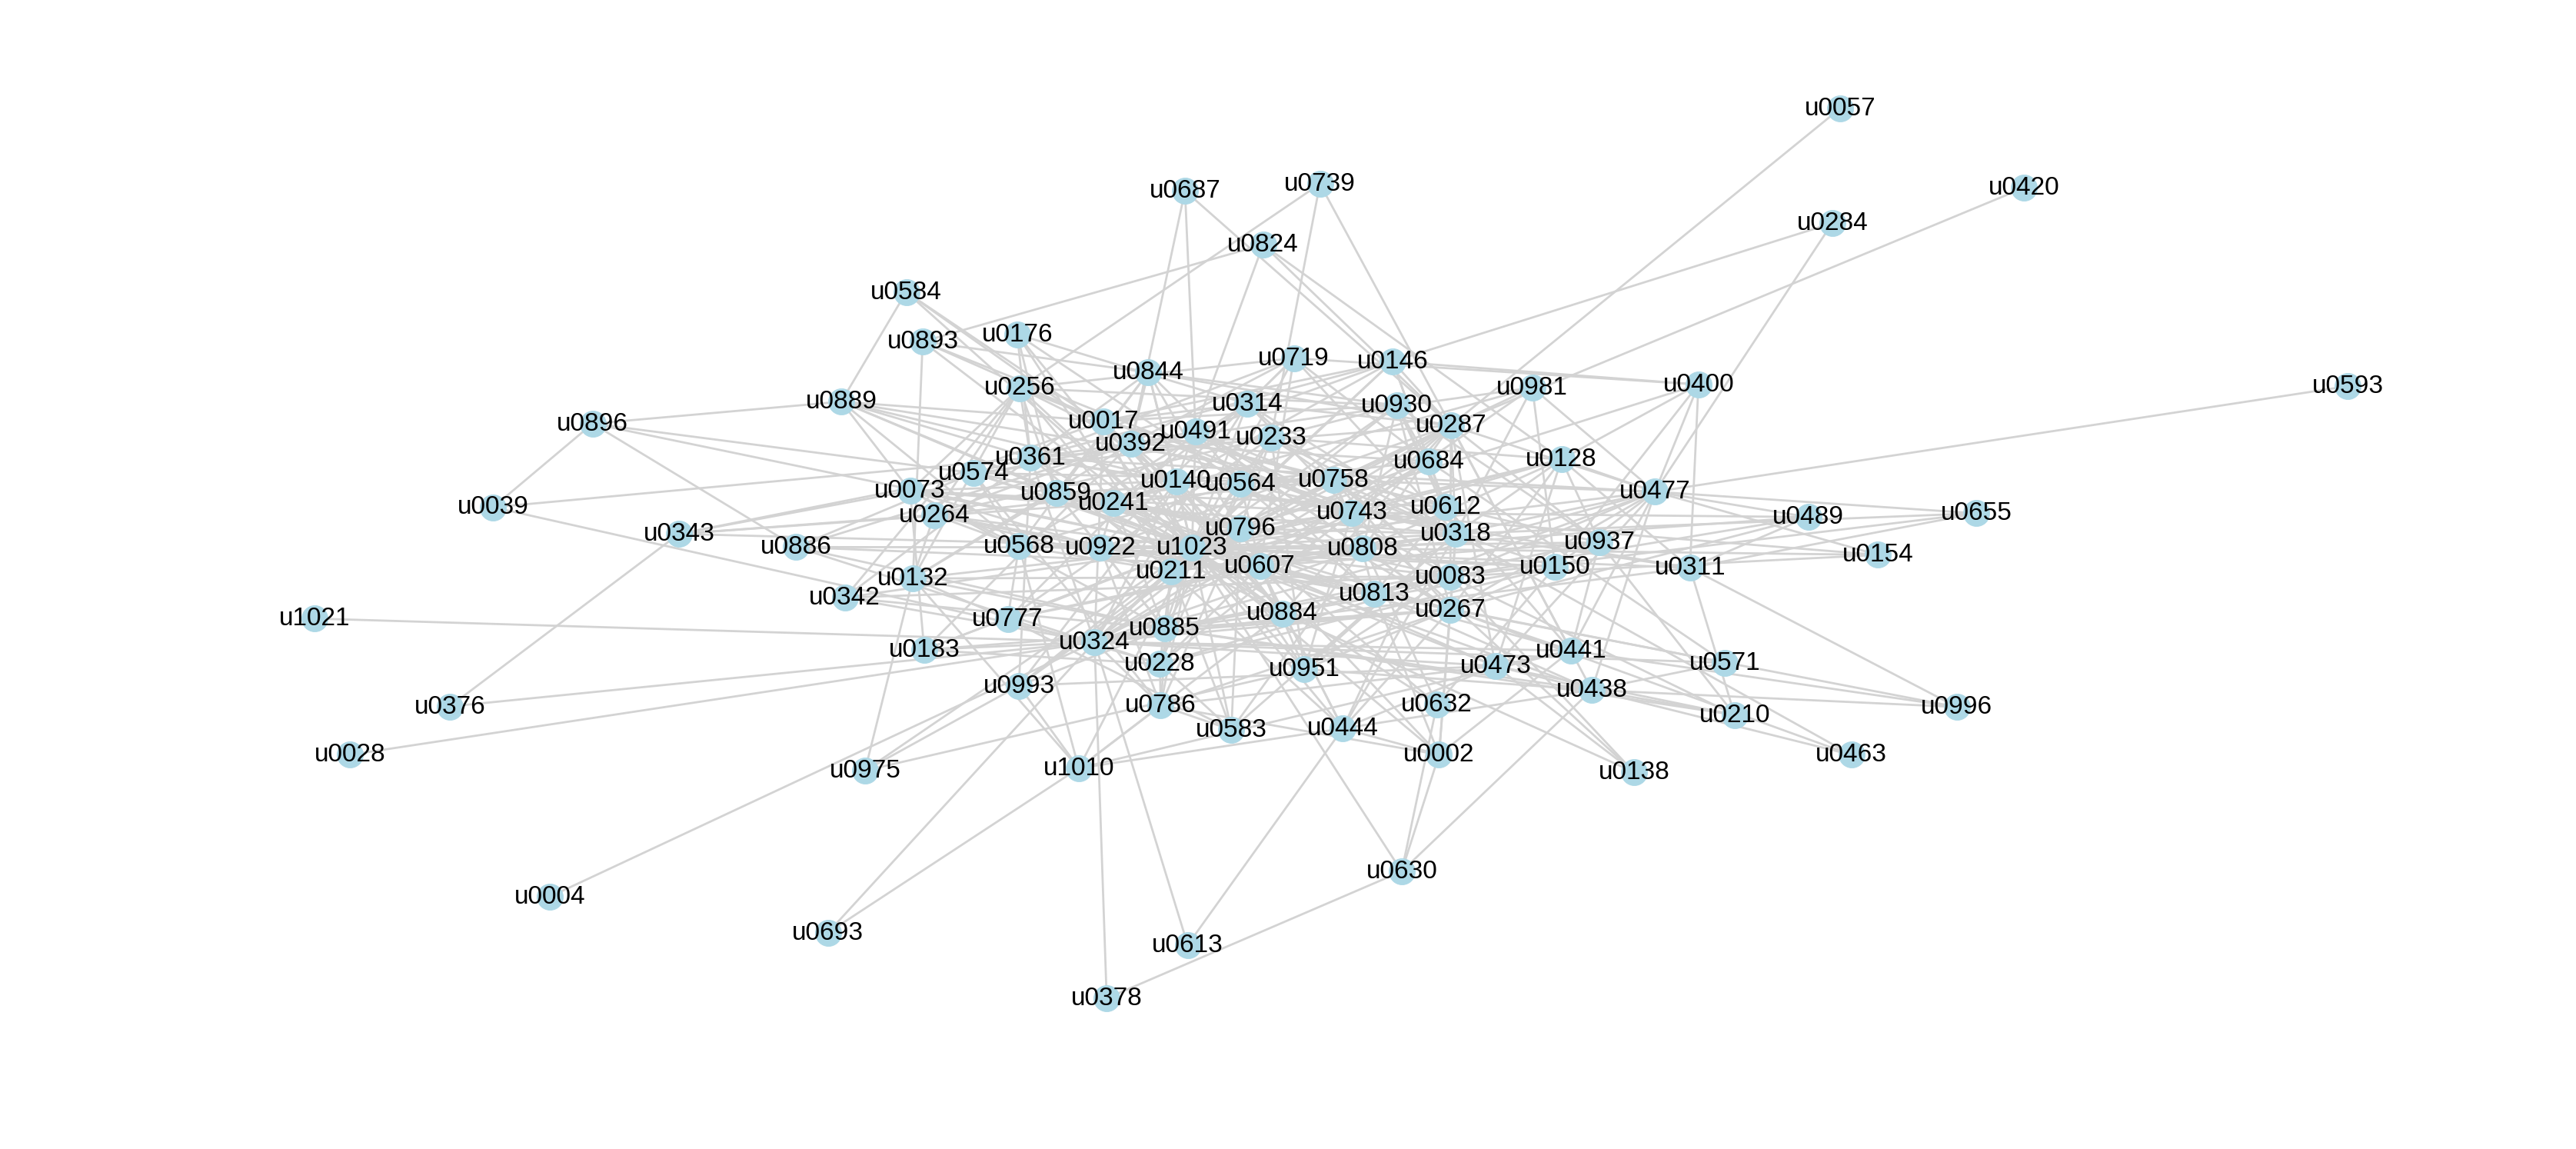

In [105]:
gs = g.subgraph(remoteUsers)  # The subset of the graph on which a PCA analysis should be performed on the users

nx.draw(gs, with_labels=True, node_color='lightblue', edge_color='lightgray', node_size=150) 

degree
user         
u1023      69
u0324      31
u0318      31
u0287      25
u0267      23

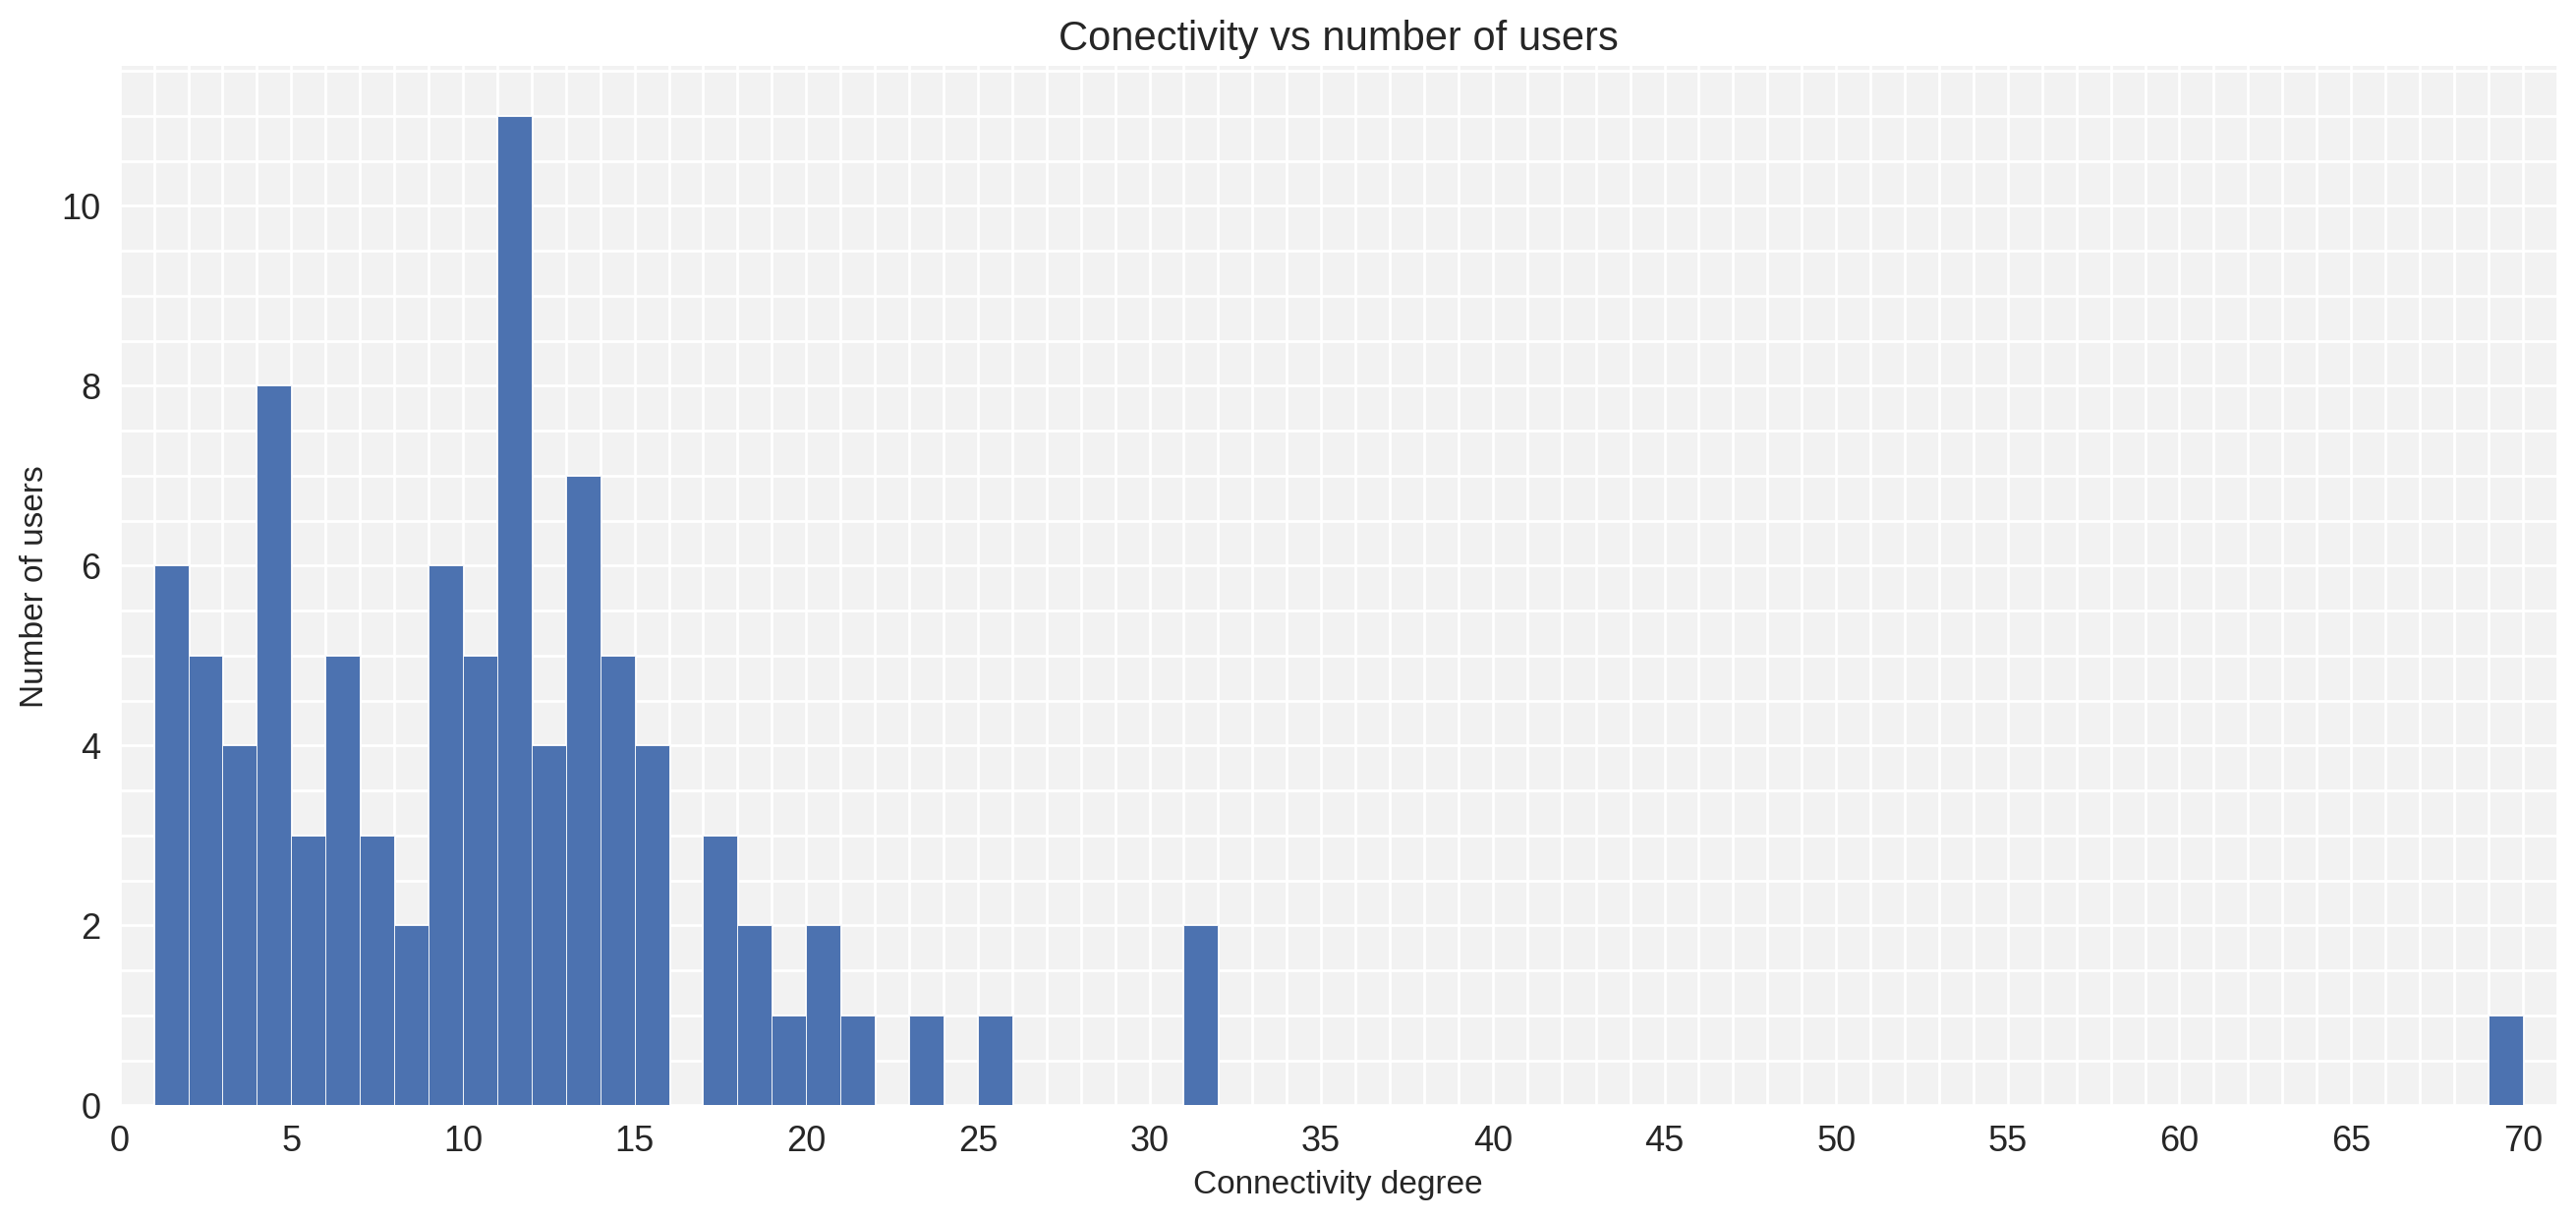

In [106]:
gsDegdf = pd.DataFrame(gs.degree())
gsDegdf.columns = ['user', 'degree']
gsDegdf.set_index('user', inplace=True)
gsDegdf.sort(columns='degree', ascending=False, inplace=True)
display(gsDegdf.head())

fig, ax0 = plt.subplots()
ax0.hist(gsDegdf.degree,
        range=(gsDegdf.degree.min(), gsDegdf.degree.max()+1),
        bins=gsDegdf.degree.max()+1 - gsDegdf.degree.min(),
        edgecolor='white')
ax0.minorticks_on() 
ax0.grid(True, which='both')
ax0.set_xticks(range(0, gsDegdf.degree.max()+2, 5))
ax0.set_xbound(0, gsDegdf.degree.max()+2)
ax0.set_xlabel('Connectivity degree')
ax0.set_ylabel('Number of users')
# countsOnBarPlot(ax0)
ax0.set_title('Conectivity vs number of users')

# ax1 = ax0.twinx()
# gsDegdf.plot.density(ax=ax1, color='orange')
# ax1.grid(b=False)

# Do the PCA analysis

Obtain the adjacency matrix for the chosen network and plot it.
Clearly one user is _very_ connected.
Consider removing said user.

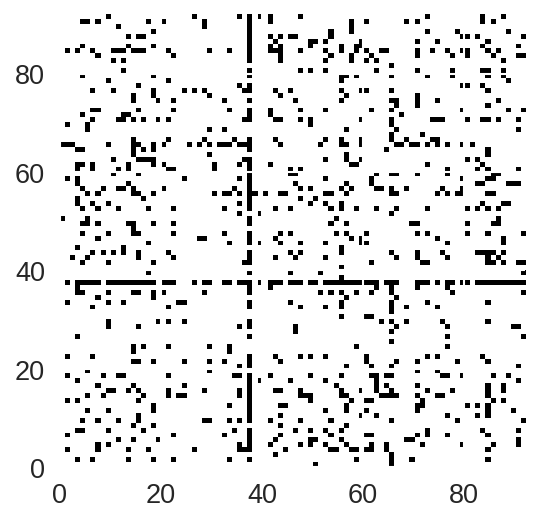

In [107]:
gsa = nx.adj_matrix(gs) 
fig, ax = plt.subplots(figsize=(4, 4), dpi=150) 
ax.pcolorfast(gsa.todense())

In [108]:
tmp = max(gs.degree(), key=lambda nd: nd[1]) 
tmp

('u1023', 69)

In [109]:
gs.remove_node(tmp[0])

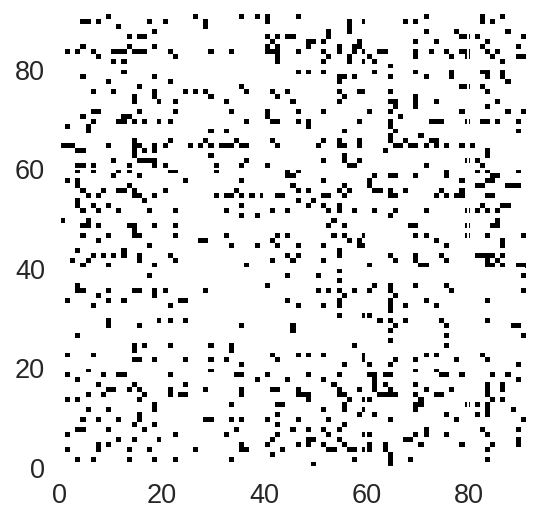

In [110]:
gsa = nx.adj_matrix(gs) 
fig, ax = plt.subplots(figsize=(4, 4), dpi=150) 
ax.pcolorfast(gsa.todense()) 

## Binning activities
### Do the time binning of activities
Now the chosen users' activities are about to be time binned.
Bins will initially be binned in sig hour bins, initially starting from midnight.

In [111]:
dfa = df.loc[remoteUsers.tolist()]
dfa.head() 

body  duration  hour                                    number  \
user  comtype                                                                  
u0002 call     NaN       0.0    17  ab343f6bda05dcaac49e59e3a866a2bb941c93ac   
      call     NaN       2.0    17  ab343f6bda05dcaac49e59e3a866a2bb941c93ac   
      call     NaN       2.0    15  d97df840435fc2159da2fdbfdeb973c848aca359   
      call     NaN       0.0    15  d97df840435fc2159da2fdbfdeb973c848aca359   
      call     NaN      36.0    15  d97df840435fc2159da2fdbfdeb973c848aca359   

                  timeint           timestamp  weekday contactedUser  
user  comtype                                                         
u0002 call     1377537295 2013-08-26 17:14:55        0         u0287  
      call     1377537395 2013-08-26 17:16:35        0         u0287  
      call     1378480599 2013-09-06 15:16:39        4         u0499  
      call     1378480831 2013-09-06 15:20:31        4         u0499  
      call     1378480855 2013-09-06 15:20:55        4         u0499

There's some times in the timebin which needs to be removed, since the project didn't exist in 1970!

In [112]:
dfa.timestamp.describe() 

count                  107144
unique                 106459
top       2013-12-31 23:09:05
freq                        7
first     1970-01-02 01:31:25
last      2015-03-24 08:03:39
Name: timestamp, dtype: object

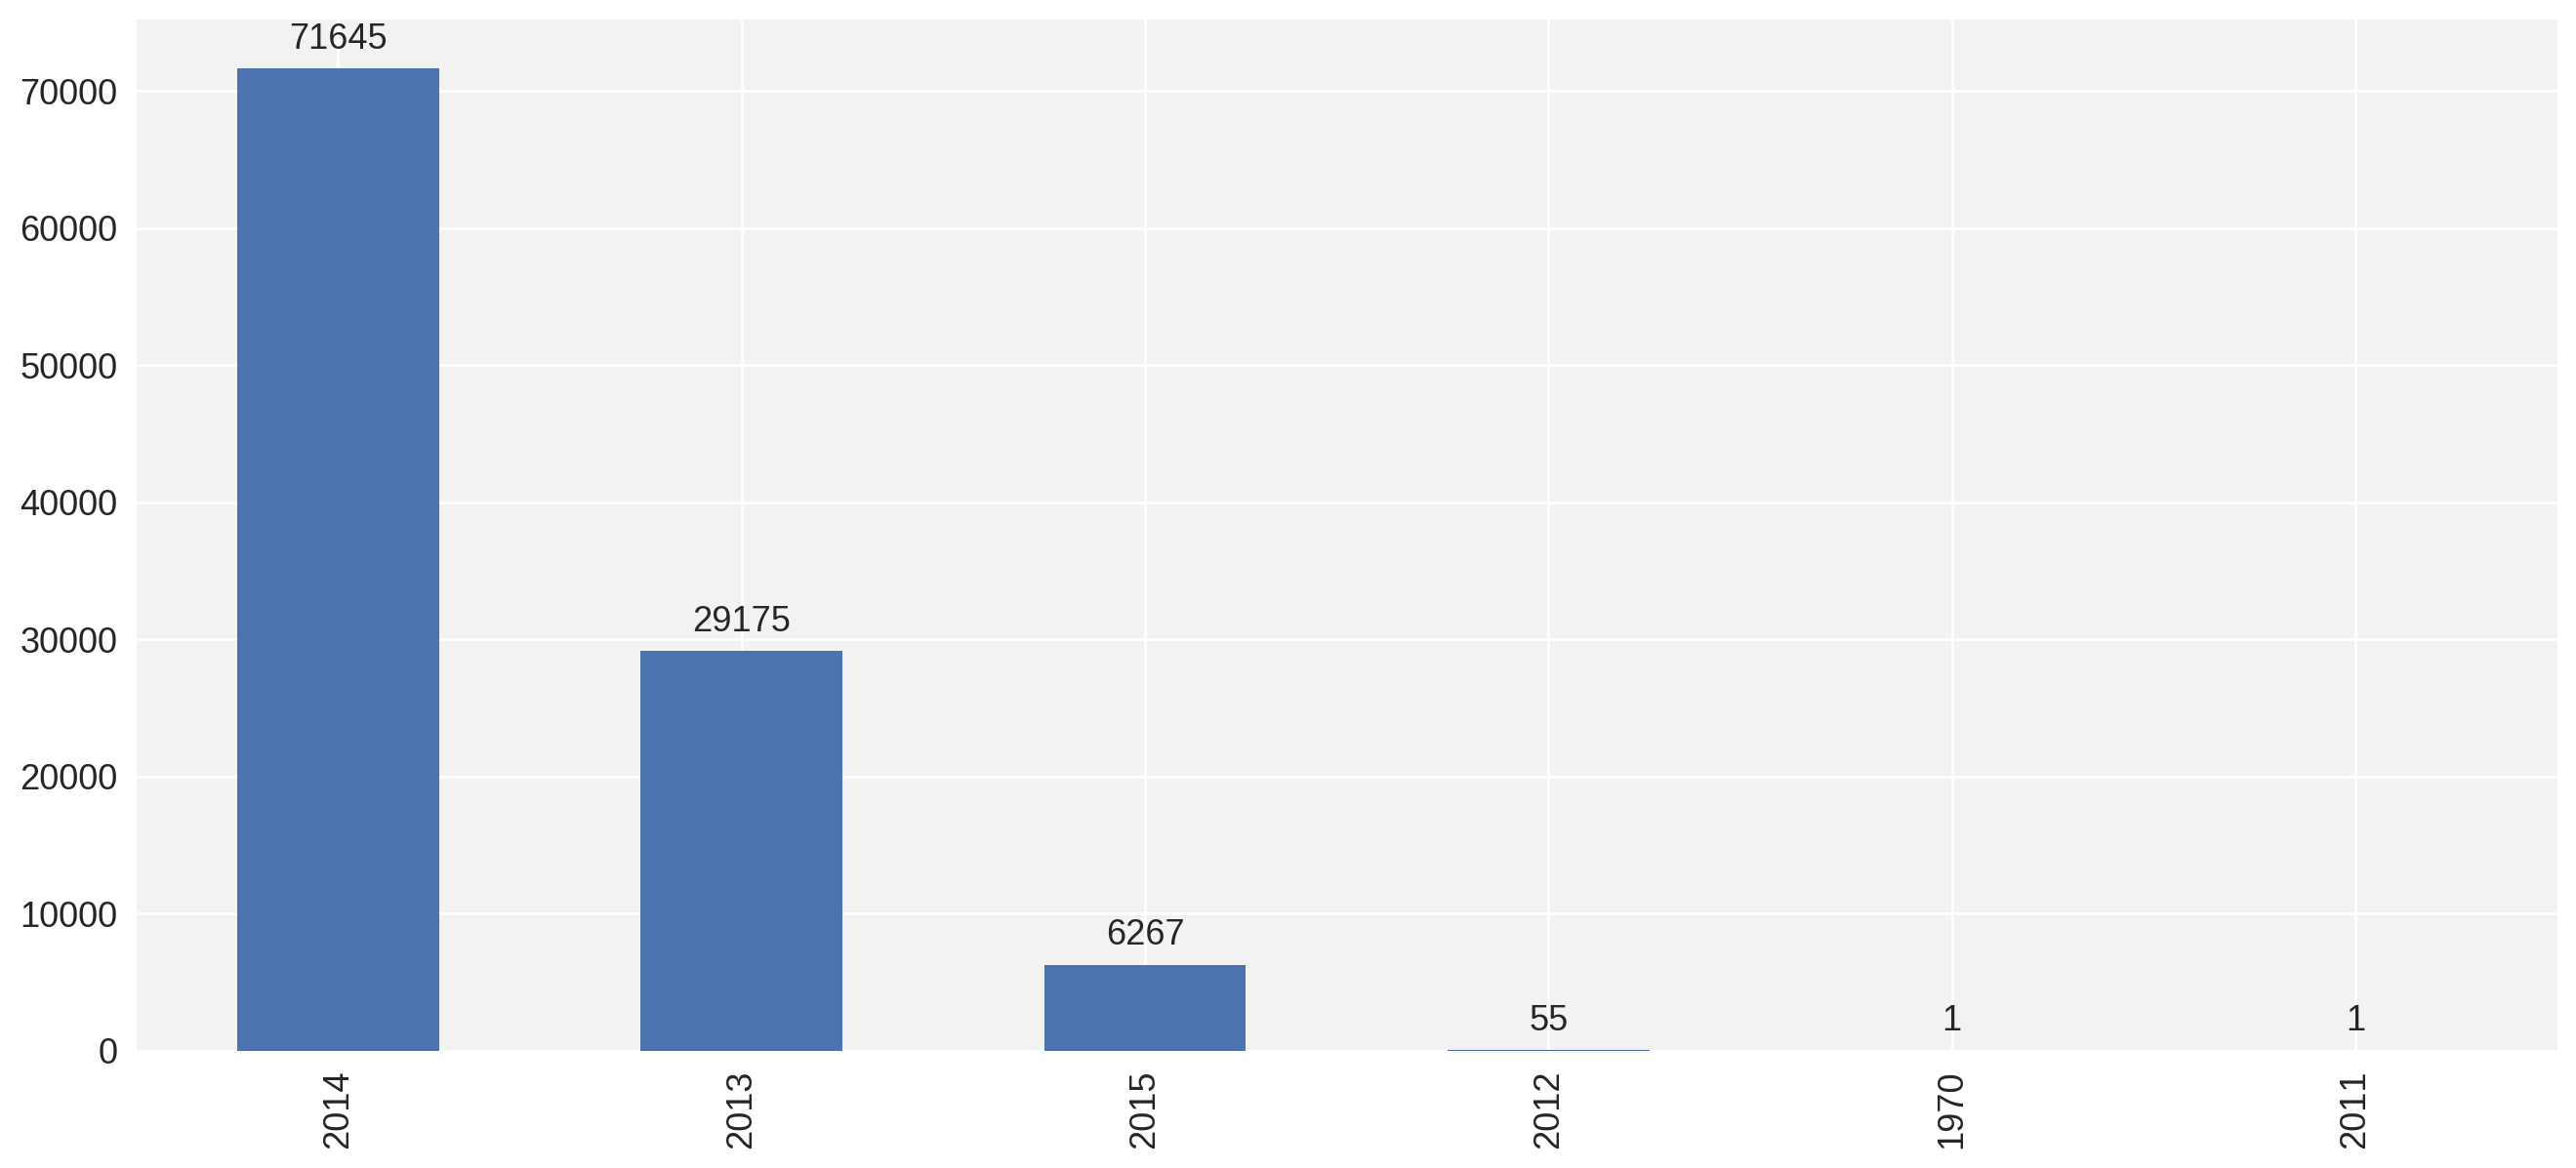

In [113]:
dfa['year'] = dfa.timestamp.dt.year
dfa.year.value_counts().plot.bar() 
countsOnBarPlot(plt.gca())

Let's examine the 2011 and 2012 data points. There's so few that they seem suspicious.

In [114]:
dfa[(dfa.year == 2011) | (dfa.year == 2012)].reset_index().user.unique() 

array(['u1010'], dtype=object)

Indeed there's only one user responsible for these points, so it's likely that the uses phone just had some wrong date settings, and the data will be removed for this purpose, and only data from 2015 and onwards will be considered.

In [115]:
dfa = dfa[dfa.year >= 2013]

Find minimum timestamp

In [116]:
dfa.timestamp.min() 

Timestamp('2013-01-26 17:11:45')

Take the corresponding unix time integer, use modolu operator for 6-hour intervans, substract it from the integer time, and cast back to a Timestamp.
This is the starting point for the time binning.

In [117]:
binWidth = 3600*6  # 6 hours in seconds
startTime = dfa.timeint.min() - (dfa.timeint.min() % binWidth)
display(pd.Timestamp(startTime, unit='s'), dfa.timestamp.min() - pd.Timestamp(startTime, unit='s') )

Timestamp('2013-01-26 12:00:00')

Timedelta('0 days 05:11:45')

Compute the timebins using integer division and examine the timebins:

count    107087.000000
mean       1798.175540
std         574.353839
min           0.000000
25%        1311.000000
50%        1692.000000
75%        2272.000000
max        3147.000000
Name: timebin, dtype: float64

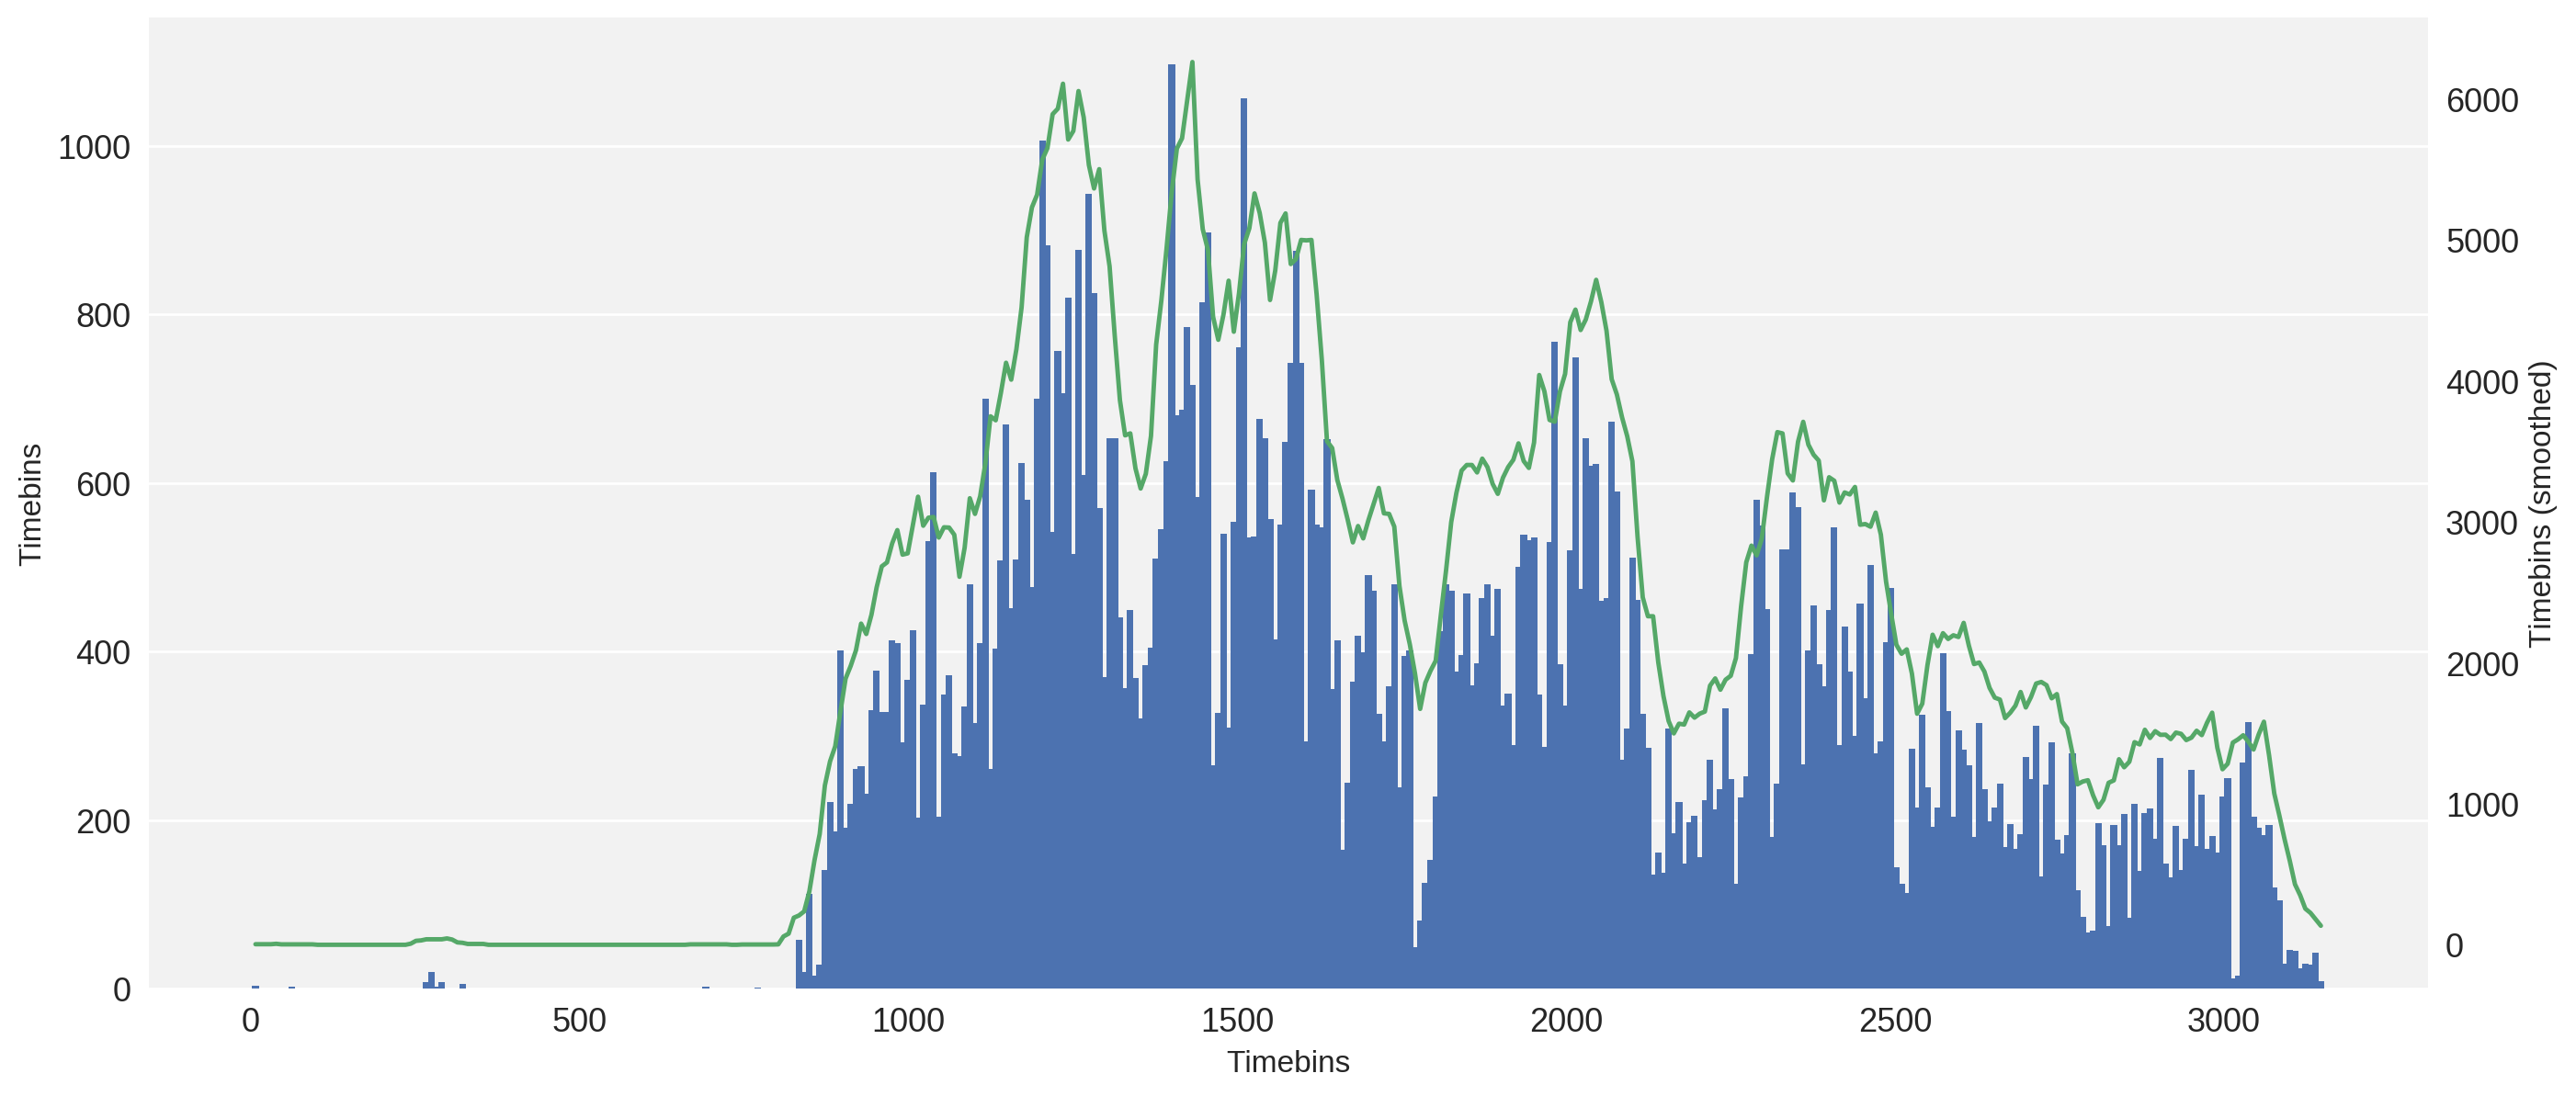

In [118]:
dfa['timebin'] = (dfa.timeint - startTime) // binWidth

display(dfa.timebin.describe()) 

fig, ax0 = plt.subplots()
hy, hx = np.histogram(dfa.timebin, bins=400)
hx = hx[1:]
ax0.bar(hx, hy, width=10, label='Timebins')
ax1 = ax0.twinx()
hy = np.convolve(np.ones(8), hy, 'same')
ax0._get_lines.get_next_color() 
ax1.plot(hx, hy, color=ax0._get_lines.get_next_color(), label='Timebins (smoothed)') 
ax0.set_xlabel('Timebins')
ax0.set_ylabel('Timebins')
ax1.set_ylabel('Timebins (smoothed)') 
ax0.grid(axis='x')
ax1.grid(False)

Also visualize using a density kernel plot

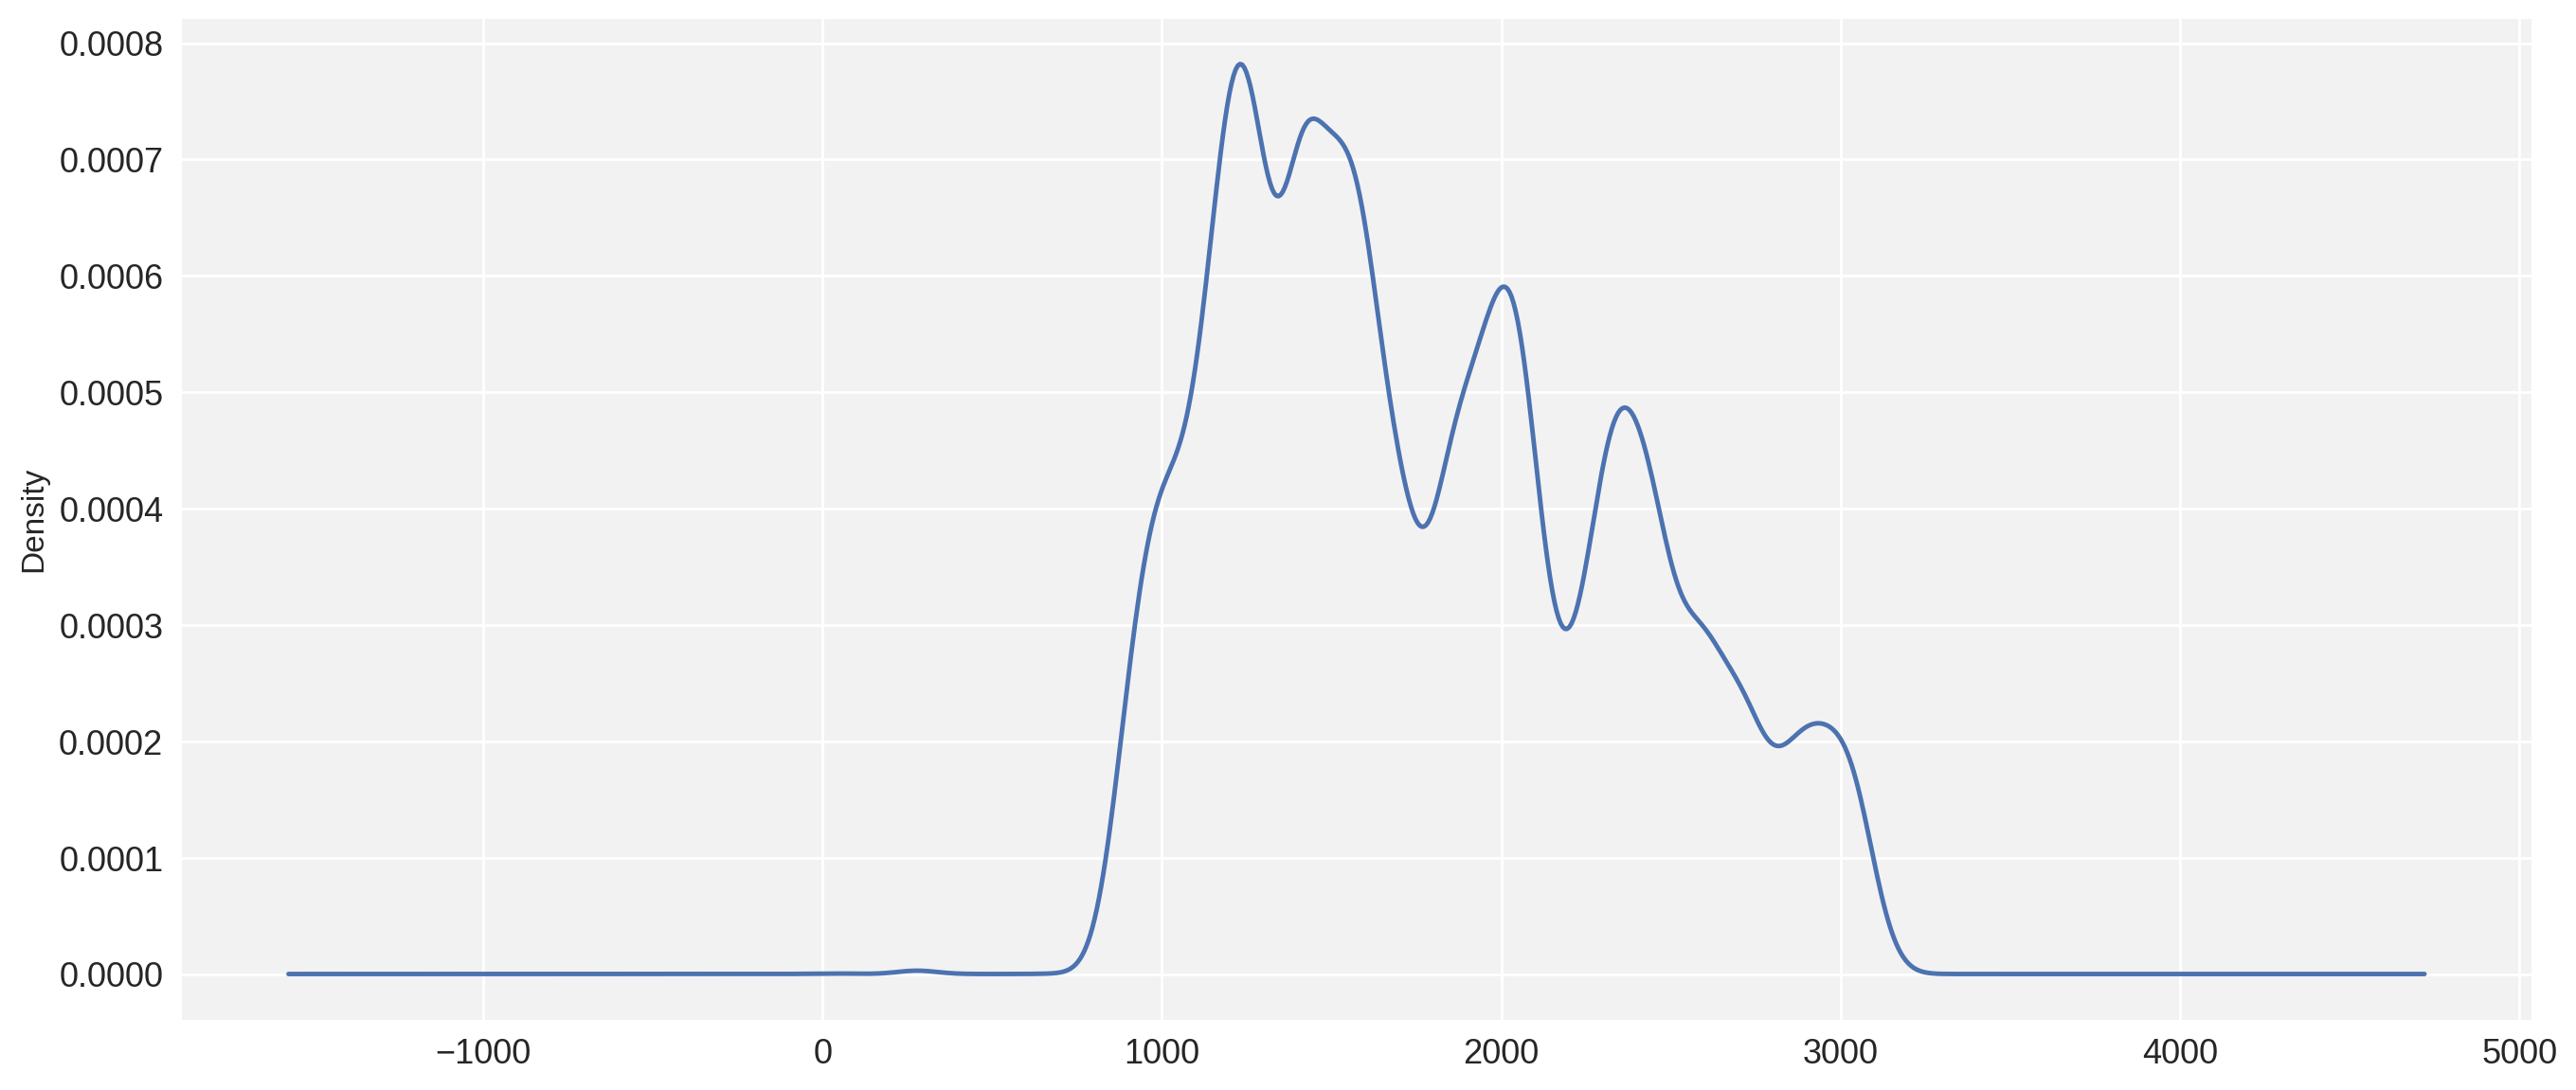

In [119]:
dfa.timebin.plot.density() 

### Construct timeseries

0    1    2    3    4    5    6    7    8    9    ...  3138 3139 3140  \
u0758  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
u0813  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
u0684  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
u0630  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
u0392  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   

      3141 3142 3143 3144 3145 3146 3147  
u0758  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
u0813  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
u0684  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
u0630  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
u0392  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 3148 columns]

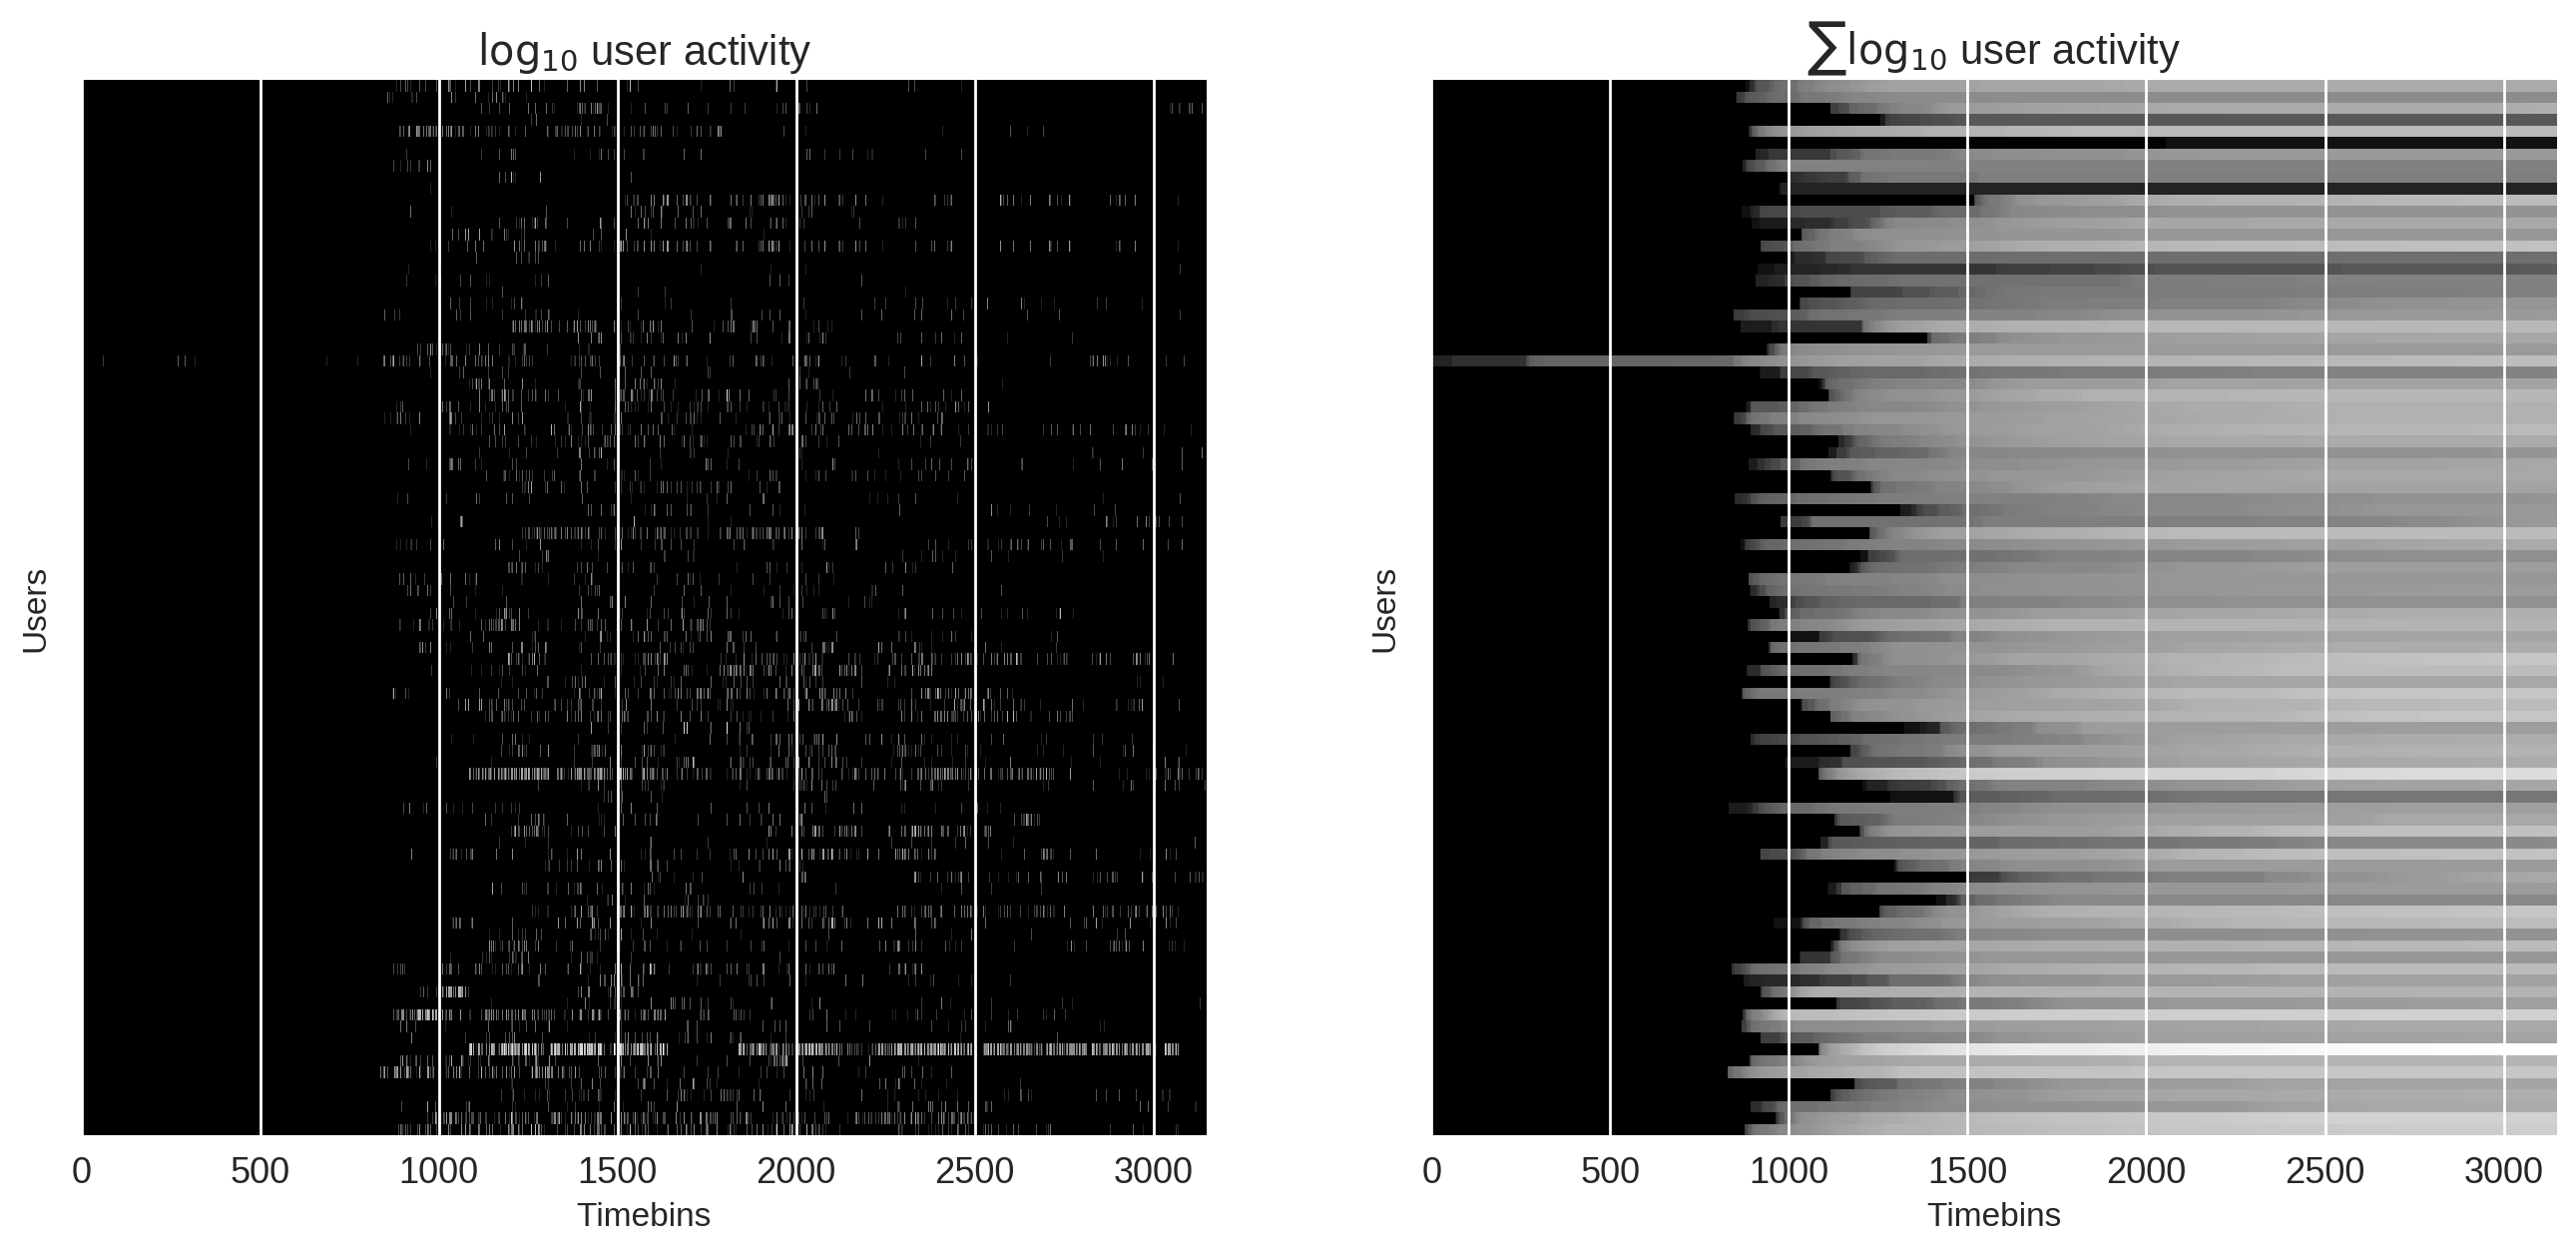

In [120]:
dfts = pd.DataFrame(index=remoteUsers, columns=np.arange(dfa.timebin.min(), dfa.timebin.max()+1))

for user in remoteUsers:
    dfts.loc[user] = dfa.loc[user].timebin.value_counts()

display(dfts.head())

dfts.replace(np.NaN, 0.0, inplace=True) 
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.grid(axis='y')
ax0.set_facecolor('black')
ax0.pcolorfast(np.log10(dfts.values), cmap=mpl.cm.binary_r)
ax0.set_xlabel('Timebins')
ax0.set_ylabel('Users')
ax0.set_yticklabels([])
ax0.set_title(r'$\log_{10}$ user activity')
ax1.grid(axis='y')
ax1.set_facecolor('black')
ax1.pcolorfast(np.log10(np.cumsum(dfts.values, axis=1)), cmap=mpl.cm.binary_r)
ax1.set_xlabel('Timebins')
ax1.set_yticklabels([])
ax1.set_ylabel('Users')
ax1.set_title(r'$\sum \log_{10}$ user activity')


Converting the binned data to a format which is useable in with the PCA algorithm

Testing that the reshaping does the right thing:

In [121]:
mat2PcaVec = lambda x: x.reshape((1, -1))

In [122]:
tmp = np.arange(12)[:,np.newaxis].reshape((3, -1))
display(tmp, mat2PcaVec(tmp))

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])

In [123]:
toPca = dfts.values
toPcaMean = toPca.mean(axis=0)
toPcaStd = toPca.std(axis=0)
toPcaStd[toPcaStd == 0] = 1.0
toPca = (toPca - toPcaMean)/toPcaStd

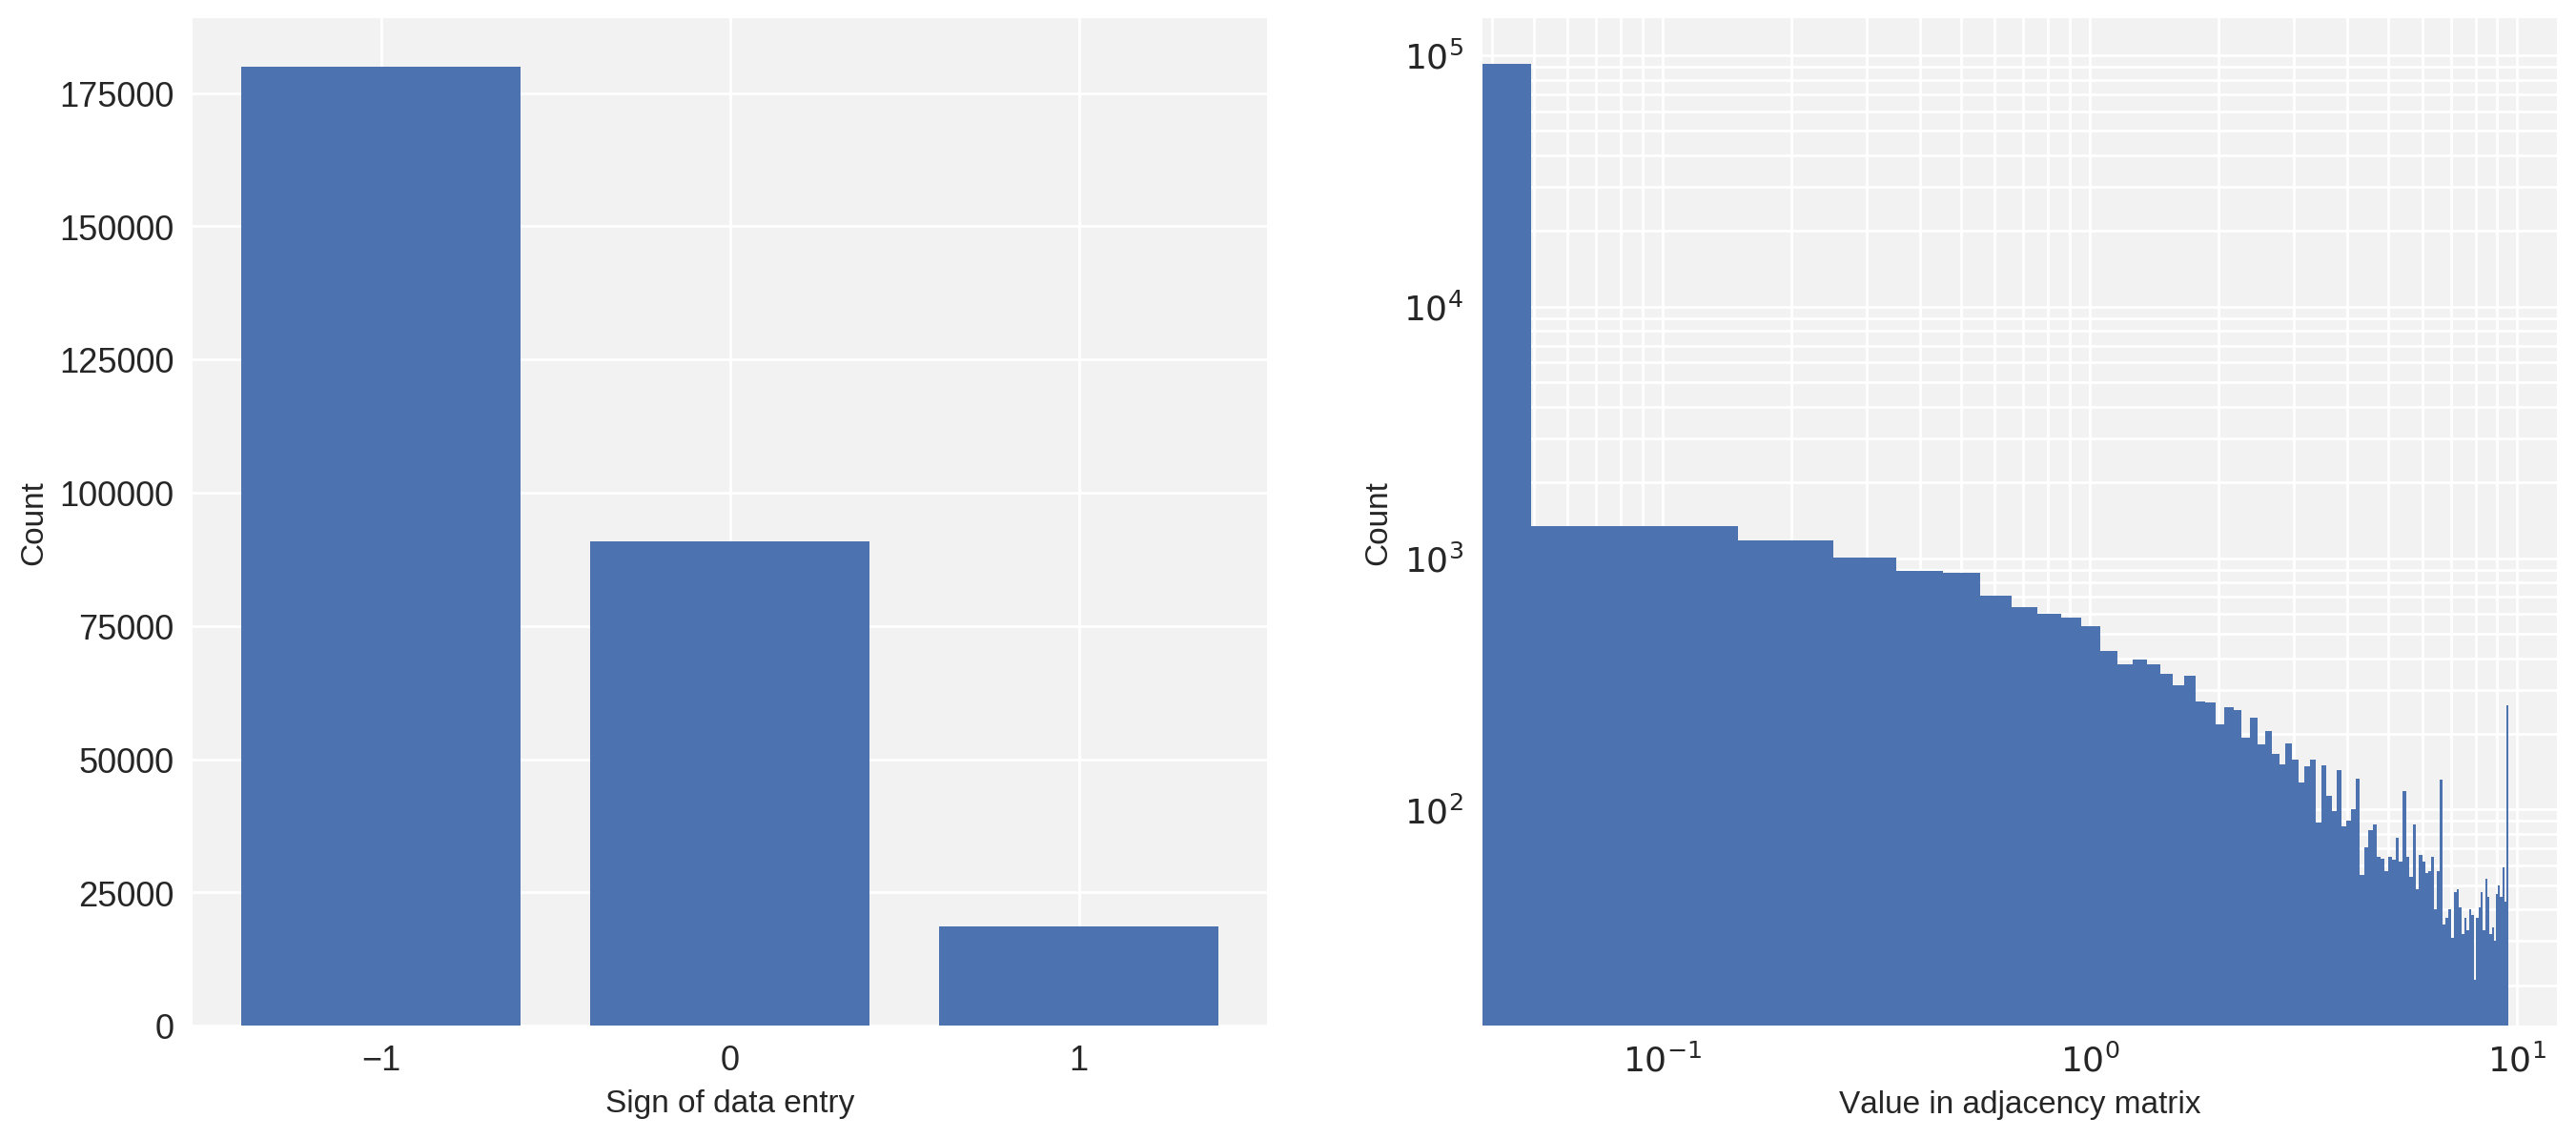

In [124]:
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.bar(*np.unique(np.sign(toPca.flat), return_counts=True))
ax0.set_xticks([-1, 0, 1])
ax0.set_xlabel('Sign of data entry')
ax0.set_ylabel('Count')

ax1.hist(toPca.flat, 100)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(which='minor')
ax1.set_xlabel('Value in adjacency matrix')
ax1.set_ylabel('Count')

In [143]:
pca = decomposition.PCA()
pca.fit(toPca)
explVarRat = pca.explained_variance_ratio_ 

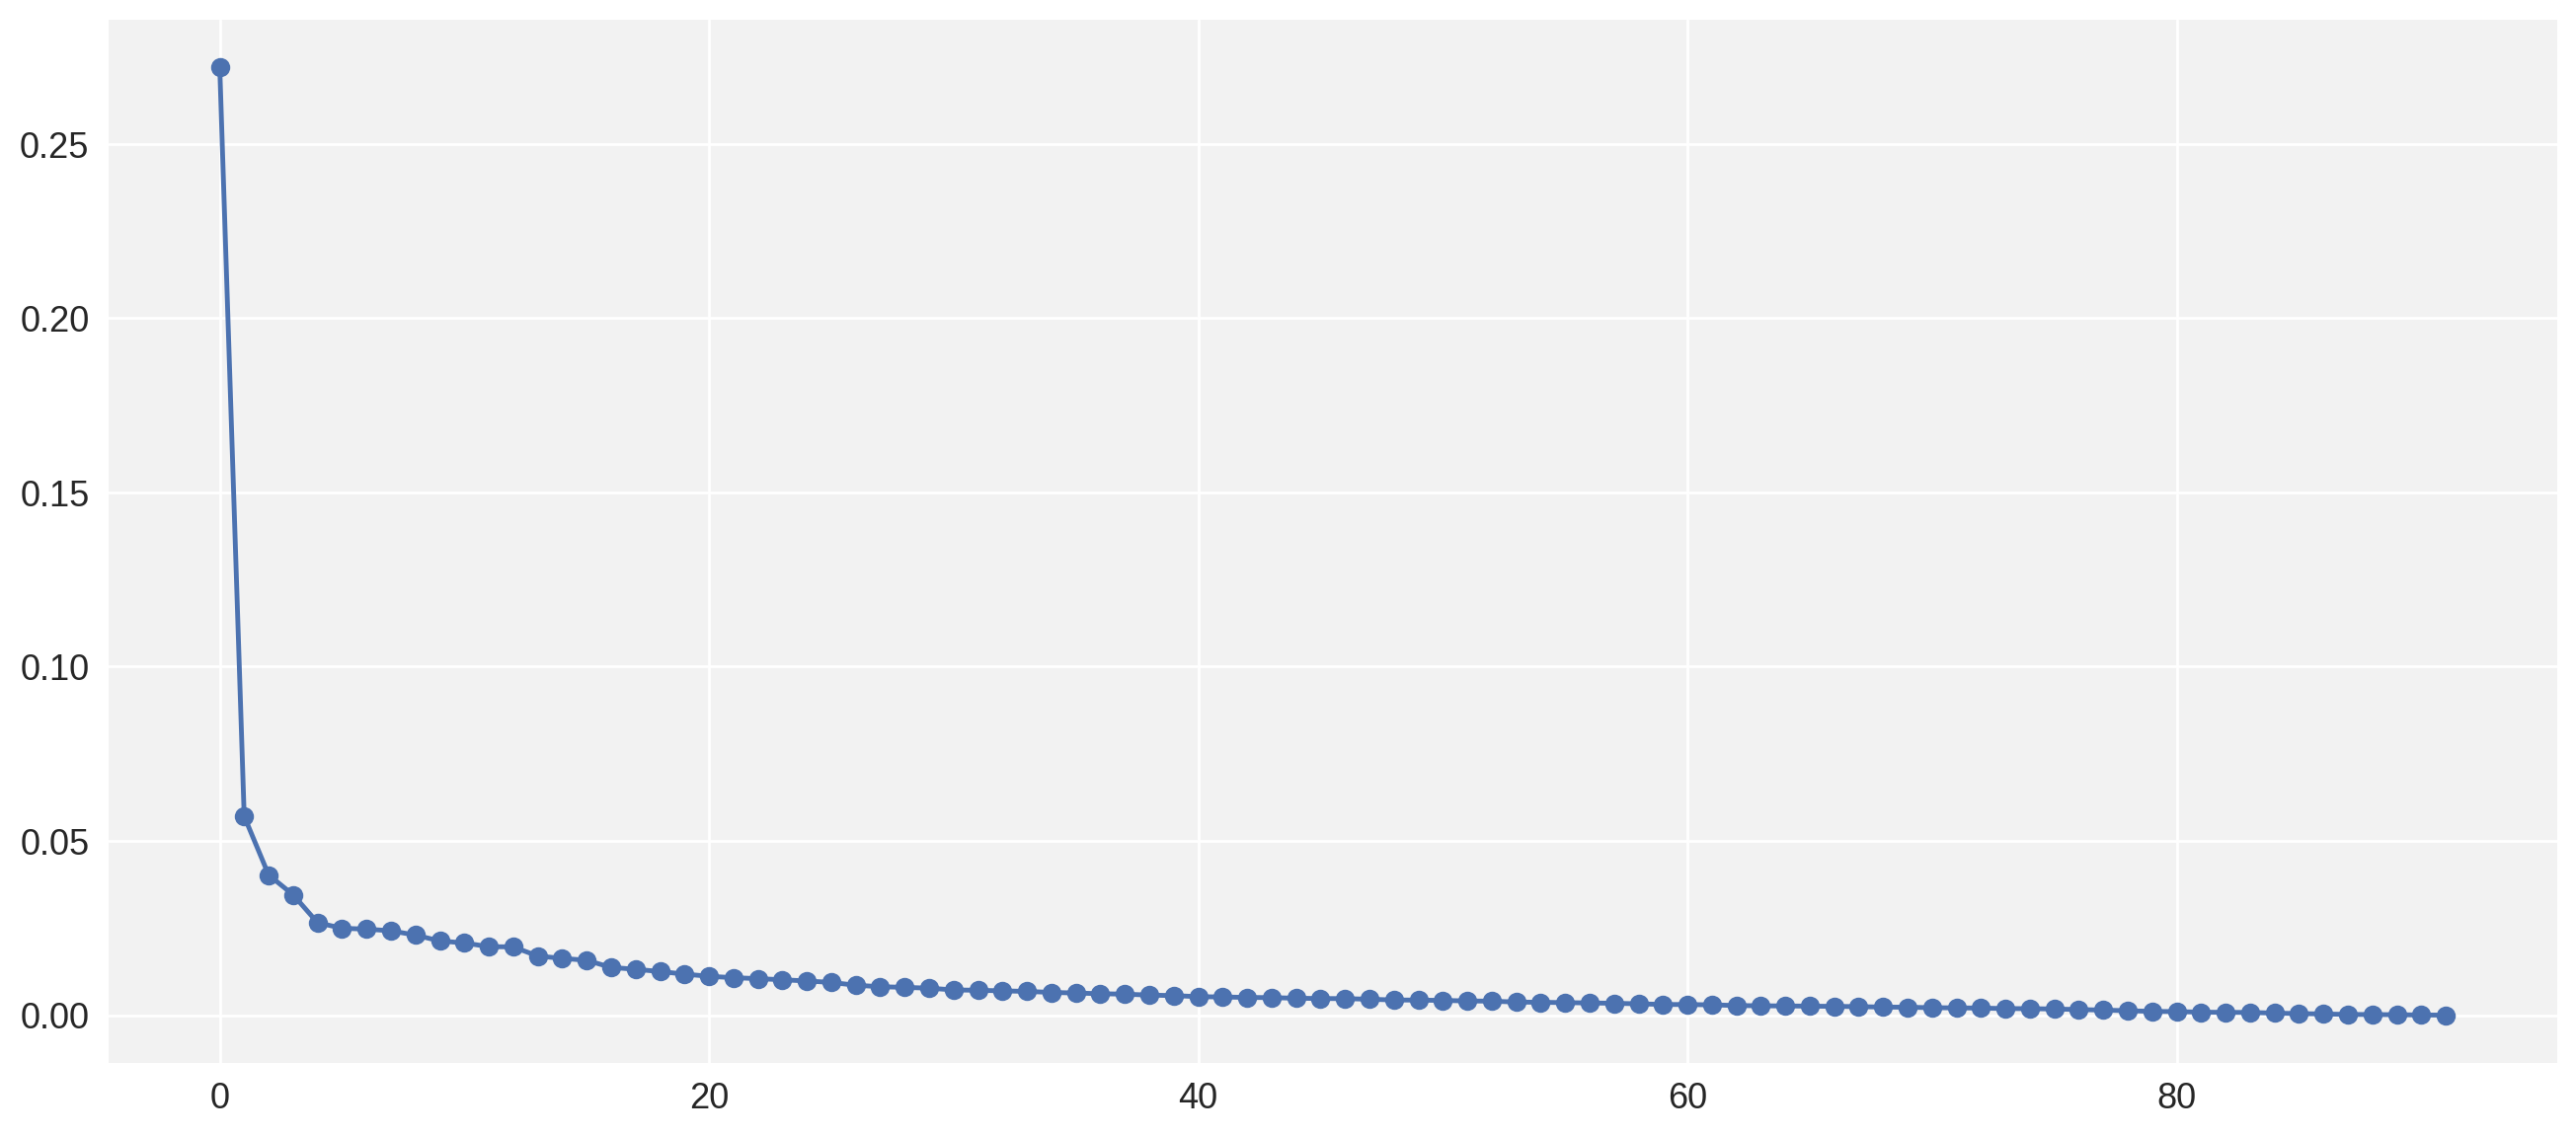

In [144]:
fig, ax = plt.subplots()
ax.plot(explVarRat, 'o-')

## Experiment with other grouping/binning options

Combine activity for all hours on a weekly basis

In [127]:
dfWH = dfa.drop(['timebin', 'year', 'timeint', 'weekday', 'hour'], axis=1)  # HW is short for Weekday Hour
# dfWH.reset_index(inplace=True)
# dfWH.set_index('timestamp', inplace=True)
dfWH.head() 

body  duration                                    number  \
user  comtype                                                            
u0002 call     NaN       0.0  ab343f6bda05dcaac49e59e3a866a2bb941c93ac   
      call     NaN       2.0  ab343f6bda05dcaac49e59e3a866a2bb941c93ac   
      call     NaN       2.0  d97df840435fc2159da2fdbfdeb973c848aca359   
      call     NaN       0.0  d97df840435fc2159da2fdbfdeb973c848aca359   
      call     NaN      36.0  d97df840435fc2159da2fdbfdeb973c848aca359   

                        timestamp contactedUser  
user  comtype                                    
u0002 call    2013-08-26 17:14:55         u0287  
      call    2013-08-26 17:16:35         u0287  
      call    2013-09-06 15:16:39         u0499  
      call    2013-09-06 15:20:31         u0499  
      call    2013-09-06 15:20:55         u0499

In [128]:
tmp = dfWH.groupby((dfWH.index.get_level_values(0), dfWH.timestamp.dt.weekday, dfWH.timestamp.dt.hour))
dfWHCnt = tmp.count().drop(['body', 'duration', 'number', 'timestamp'], axis=1)
dfWHCnt.rename(index=None, columns={'contactedUser': 'events'}, inplace=True) 
dfWHCnt.index.rename(['user', 'weekday', 'hour'], inplace=True)
dfWHCnt.head(10) 

events
user  weekday hour        
u0002 0       5          2
              8          2
              9          2
              10         2
              11         1
              16         4
              17         6
              20         1
      1       4          1
              5          6

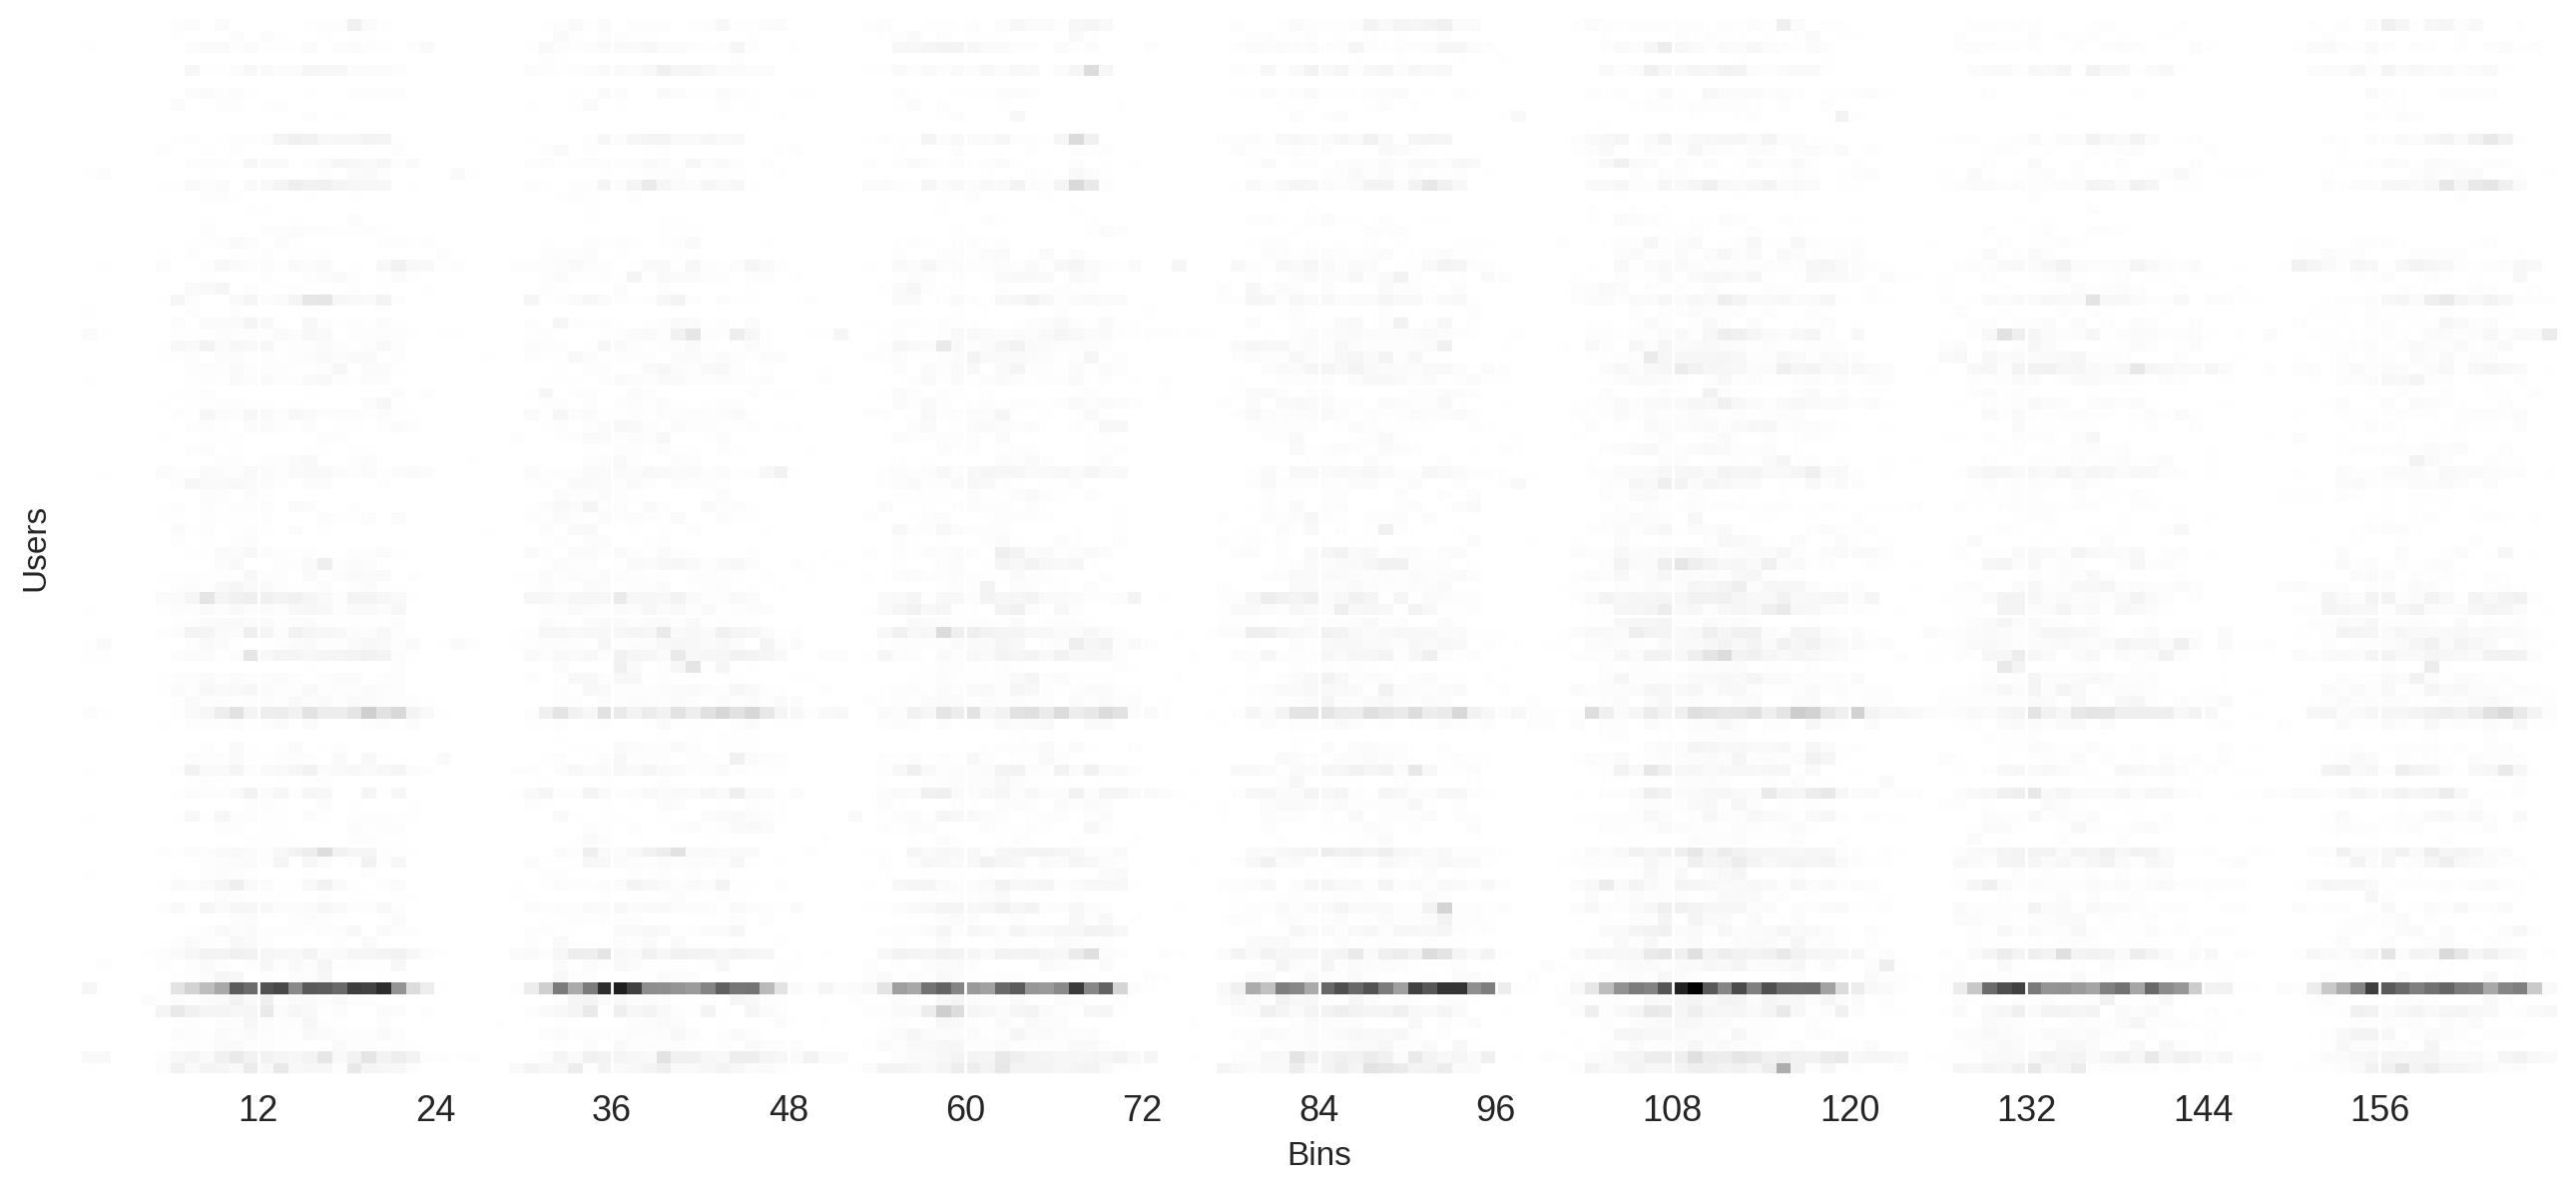

In [129]:
whCntMat = np.zeros((remoteUsers.size, 7*24))  # 7 days a week, 24 hours a day

user2row = {remoteUsers[i]: i for i in range(len(remoteUsers))}
user2col = lambda weekday, hour: 24*weekday + hour
for (user, weekday, hour) in dfWHCnt.index:
    r = user2row[user]
    c = user2col(weekday, hour)
    whCntMat[r,c] = dfWHCnt.loc[user, weekday, hour]

fig, ax = plt.subplots()
ax.pcolorfast(whCntMat) 
ax.set_xticks(np.arange(12, whCntMat.shape[1]-5, 12))
# ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('Bins')
ax.set_ylabel('Users')

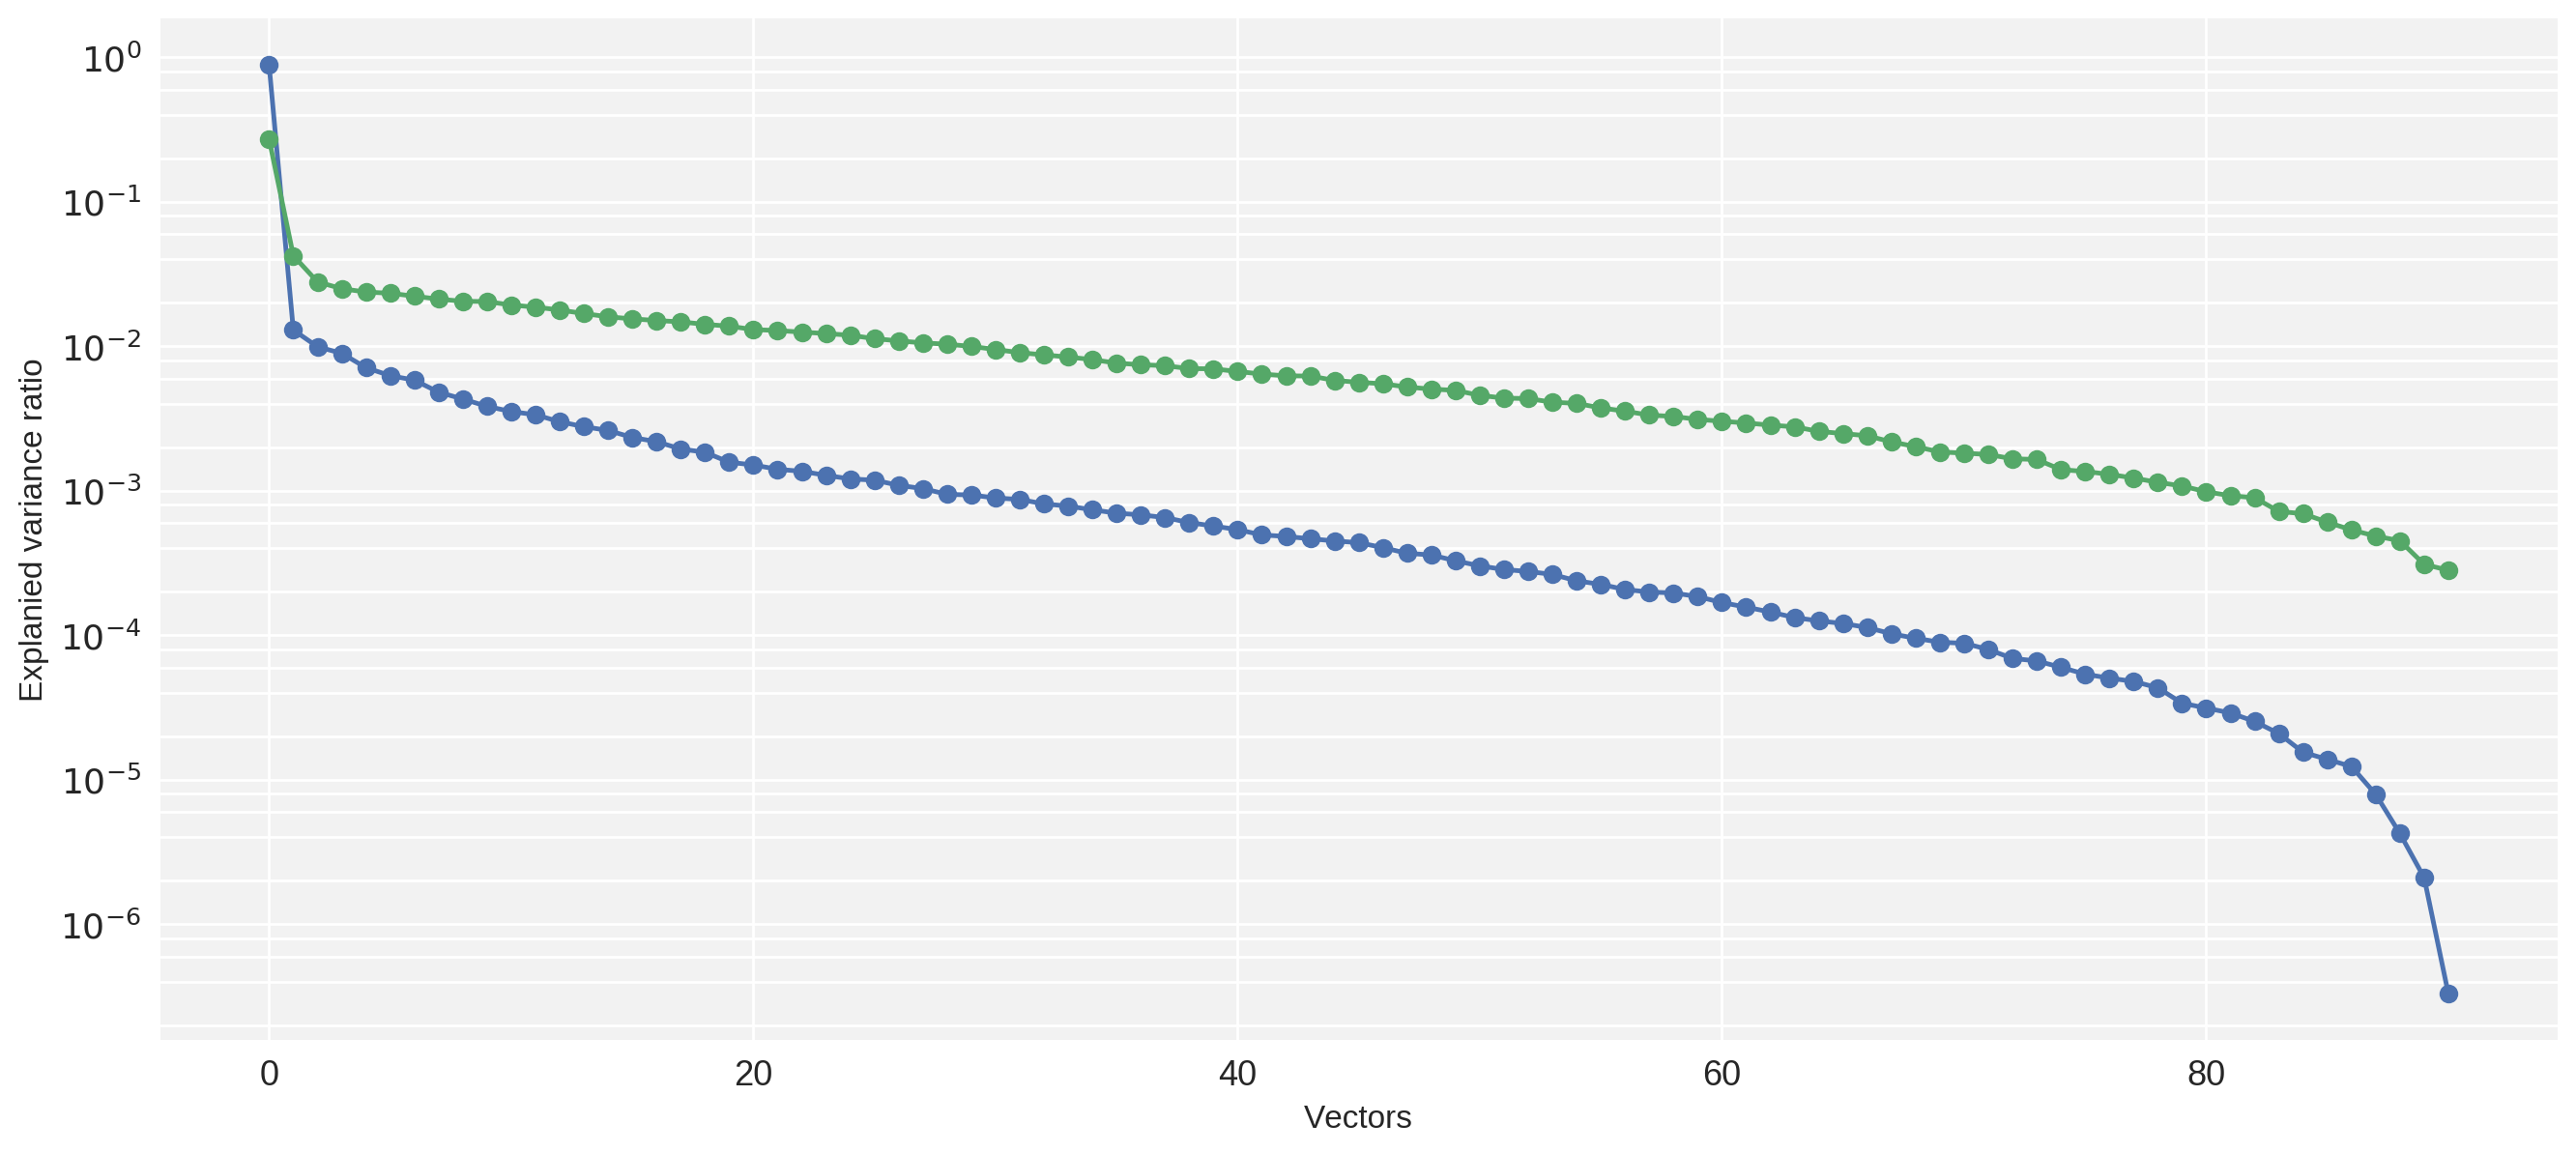

In [130]:
pca = decomposition.PCA()
pca.fit(whCntMat)
evrFloat = pca.explained_variance_ratio_
pca.fit(whCntMat > 0)
evrBool = pca.explained_variance_ratio_
fig, ax = plt.subplots()
ax.plot(evrFloat[:-1], '-o', label='float')  # Last point omitted, practically 0
ax.plot(evrBool[:-1], '-o', label='bool')  # Last point omitted, practically 0
ax.set_xlabel('Vectors')
ax.set_ylabel('Explanied variance ratio')
ax.set_yscale('log') 
ax.grid(which='minor')

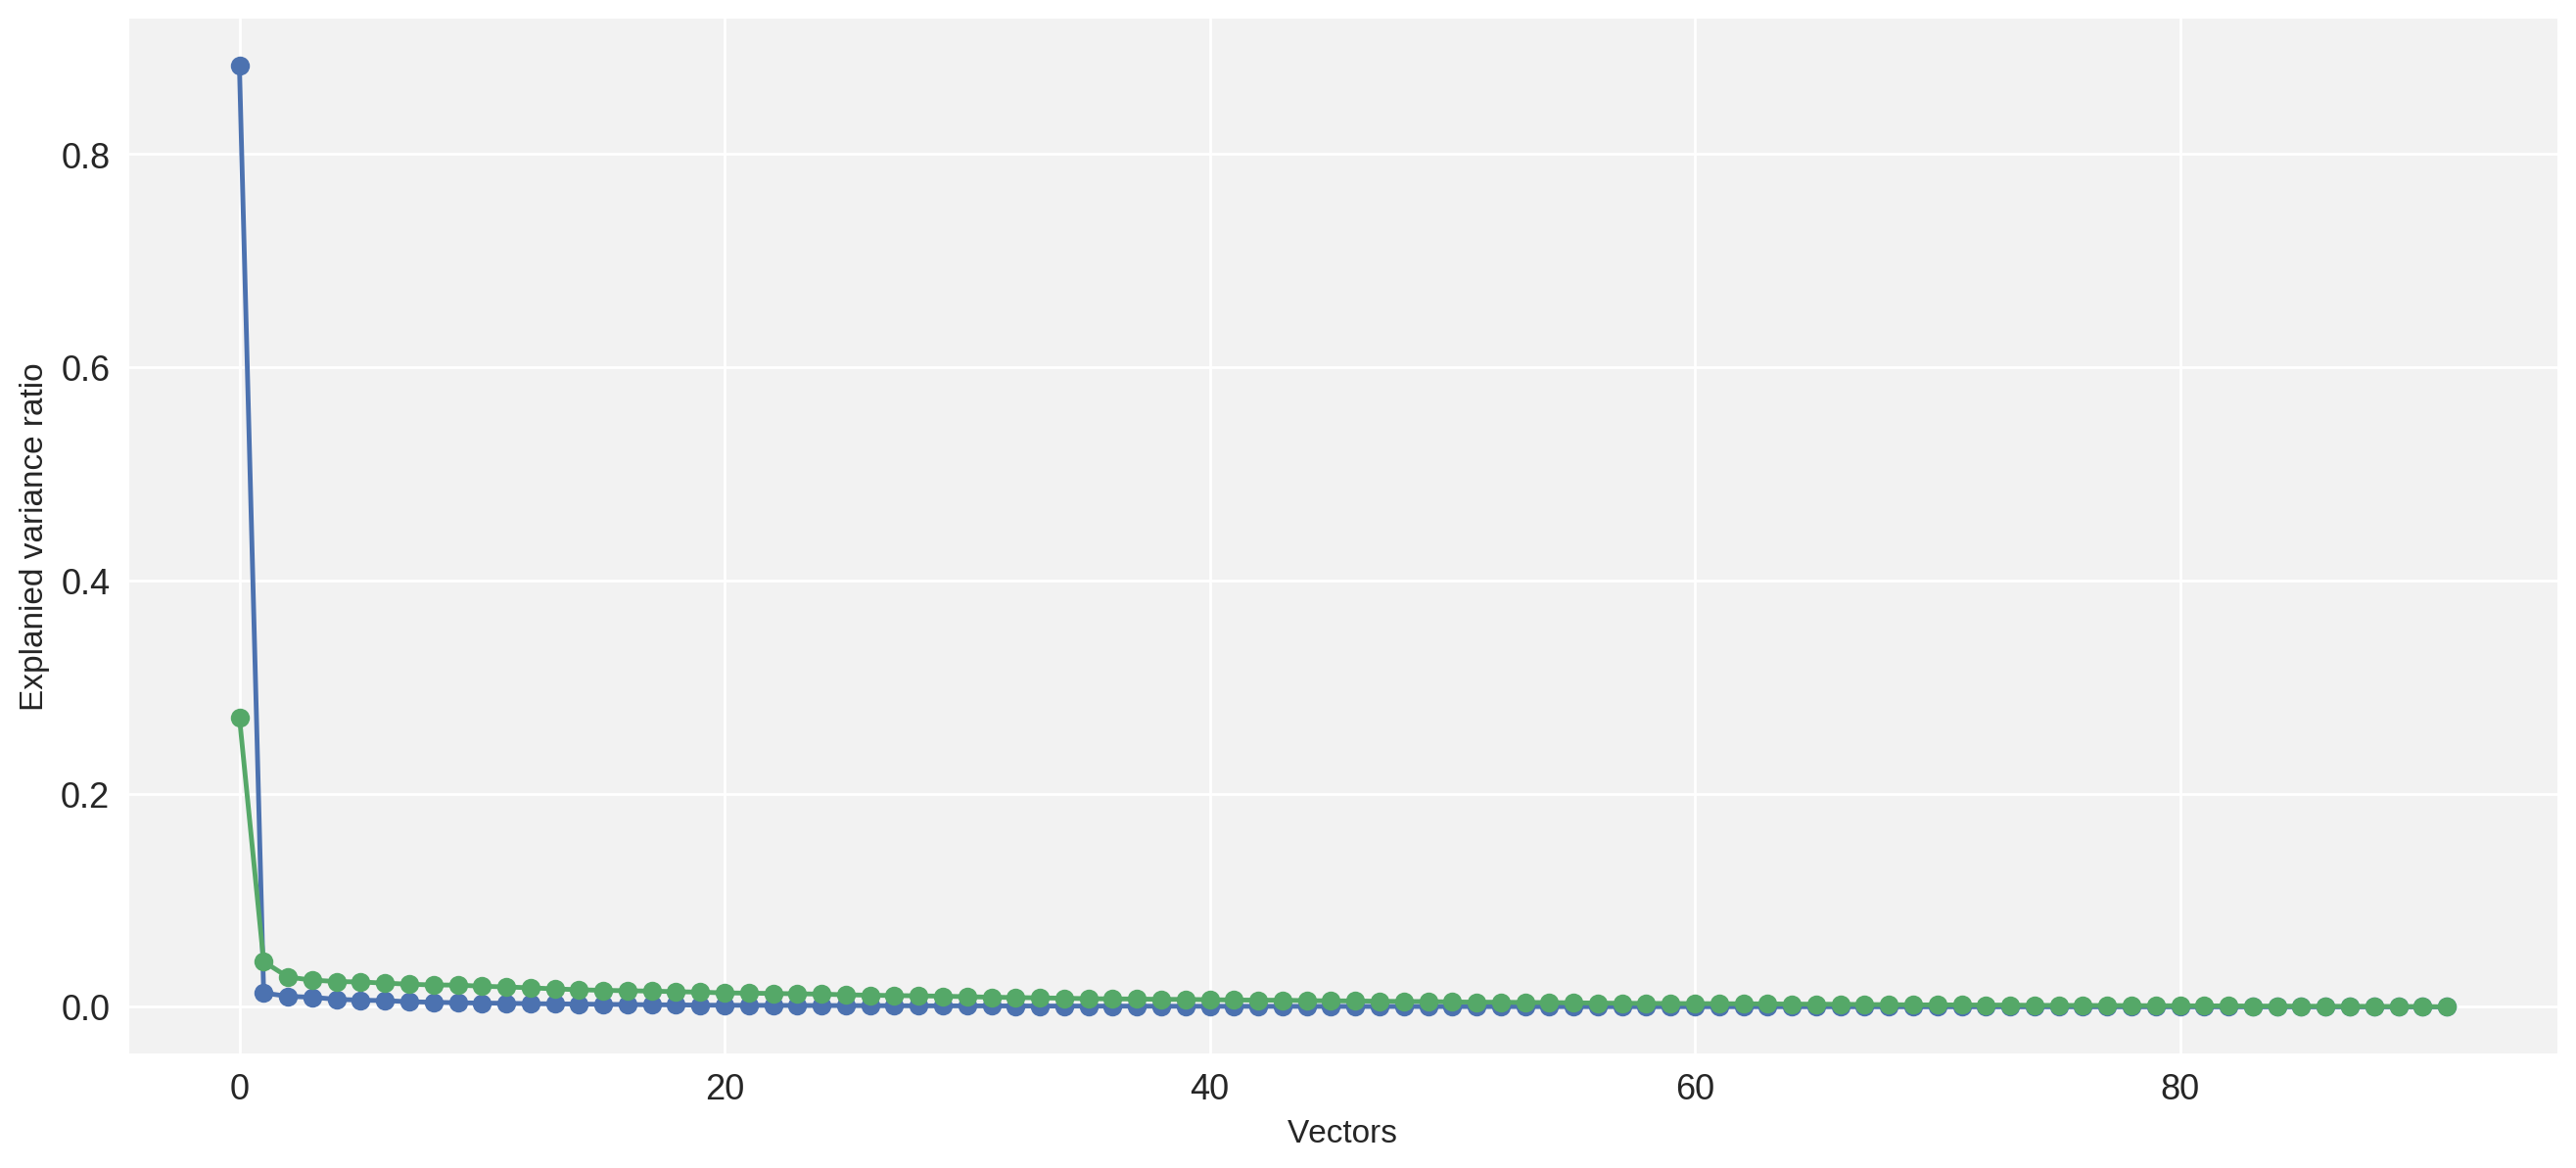

In [131]:
fig, ax = plt.subplots()
ax.plot(evrFloat, '-o', label='float')  
ax.plot(evrBool, '-o', label='bool')  
ax.set_xlabel('Vectors')
ax.set_ylabel('Explanied variance ratio')

In [150]:
np.isnan(pca.get_covariance()).any() 

False

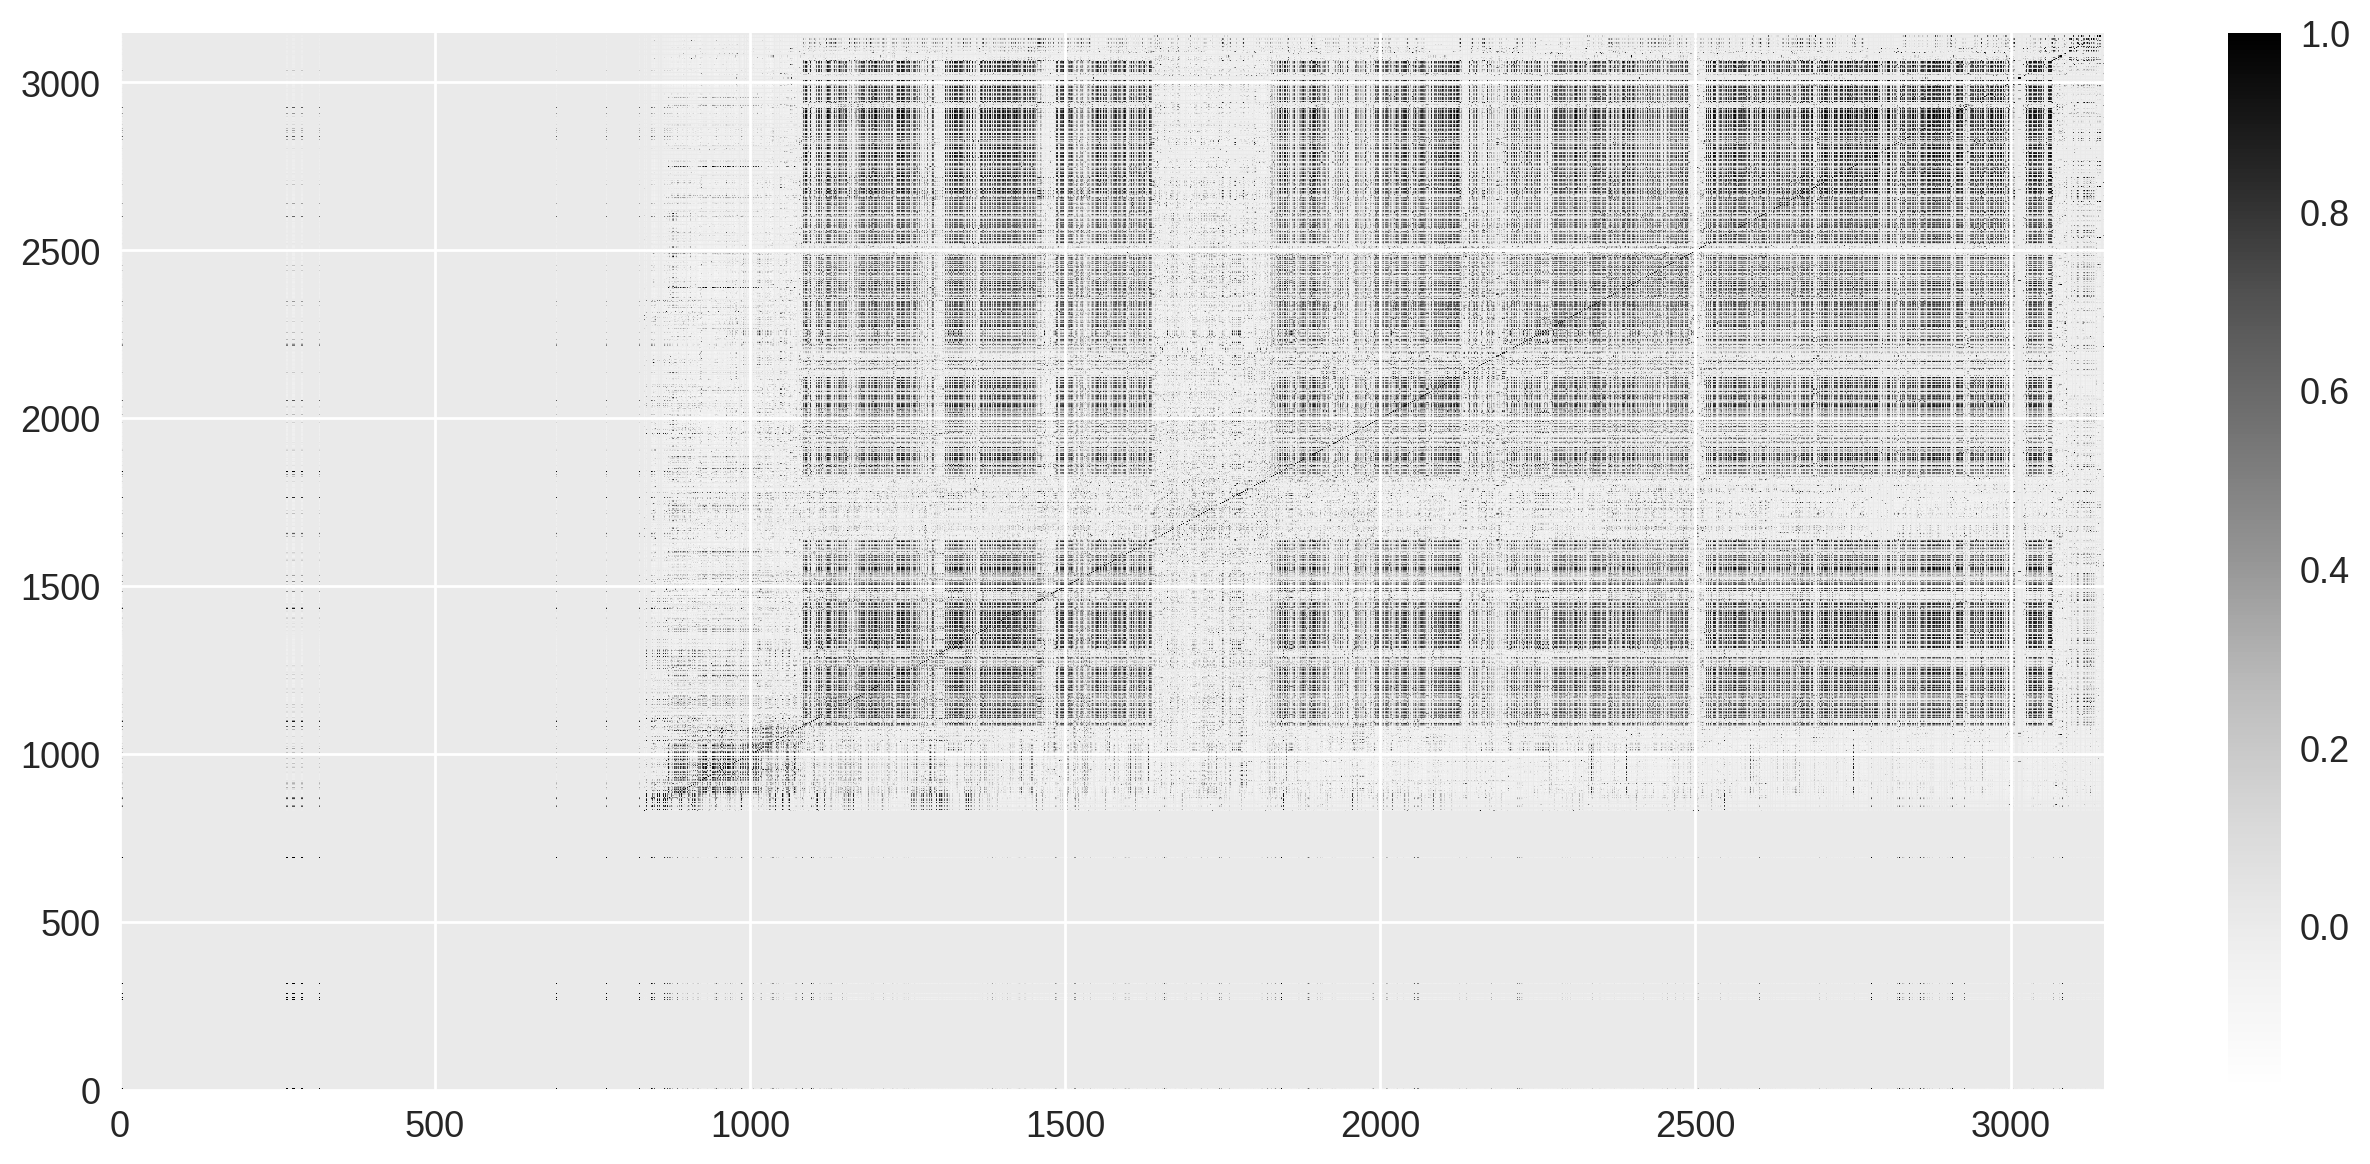

In [151]:
fig, ax = plt.subplots(facecolor='white')
pc = ax.pcolorfast(pca.get_covariance()) 
fig.colorbar(pc)

## Build adjacency matrices for each week


In [155]:
nTimebins = dfa.timebin.max()
toPcaMat = np.zeros((len(remoteUsers)**2, nTimebins))
for tb in range(0, nTimebins):
    weekGraph = userDF2nxGraph(dfa[dfa.timebin == tb])
    weekGraph.remove_nodes_from(set(weekGraph.nodes()) - set(remoteUsers))  # remove users not in remoteUsers
    weekGraph.add_nodes_from(remoteUsers)  # add users from remote users
    toPcaMat[:, tb] = nx.adj_matrix(weekGraph, nodelist=remoteUsers).todense().T.reshape(-1)

toPcaMat = standardizeData(toPcaMat)

In [159]:
toPcaMat.shape

(8464, 3147)

In [157]:
pca = decomposition.PCA()
pca.fit(toPcaMat) 

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

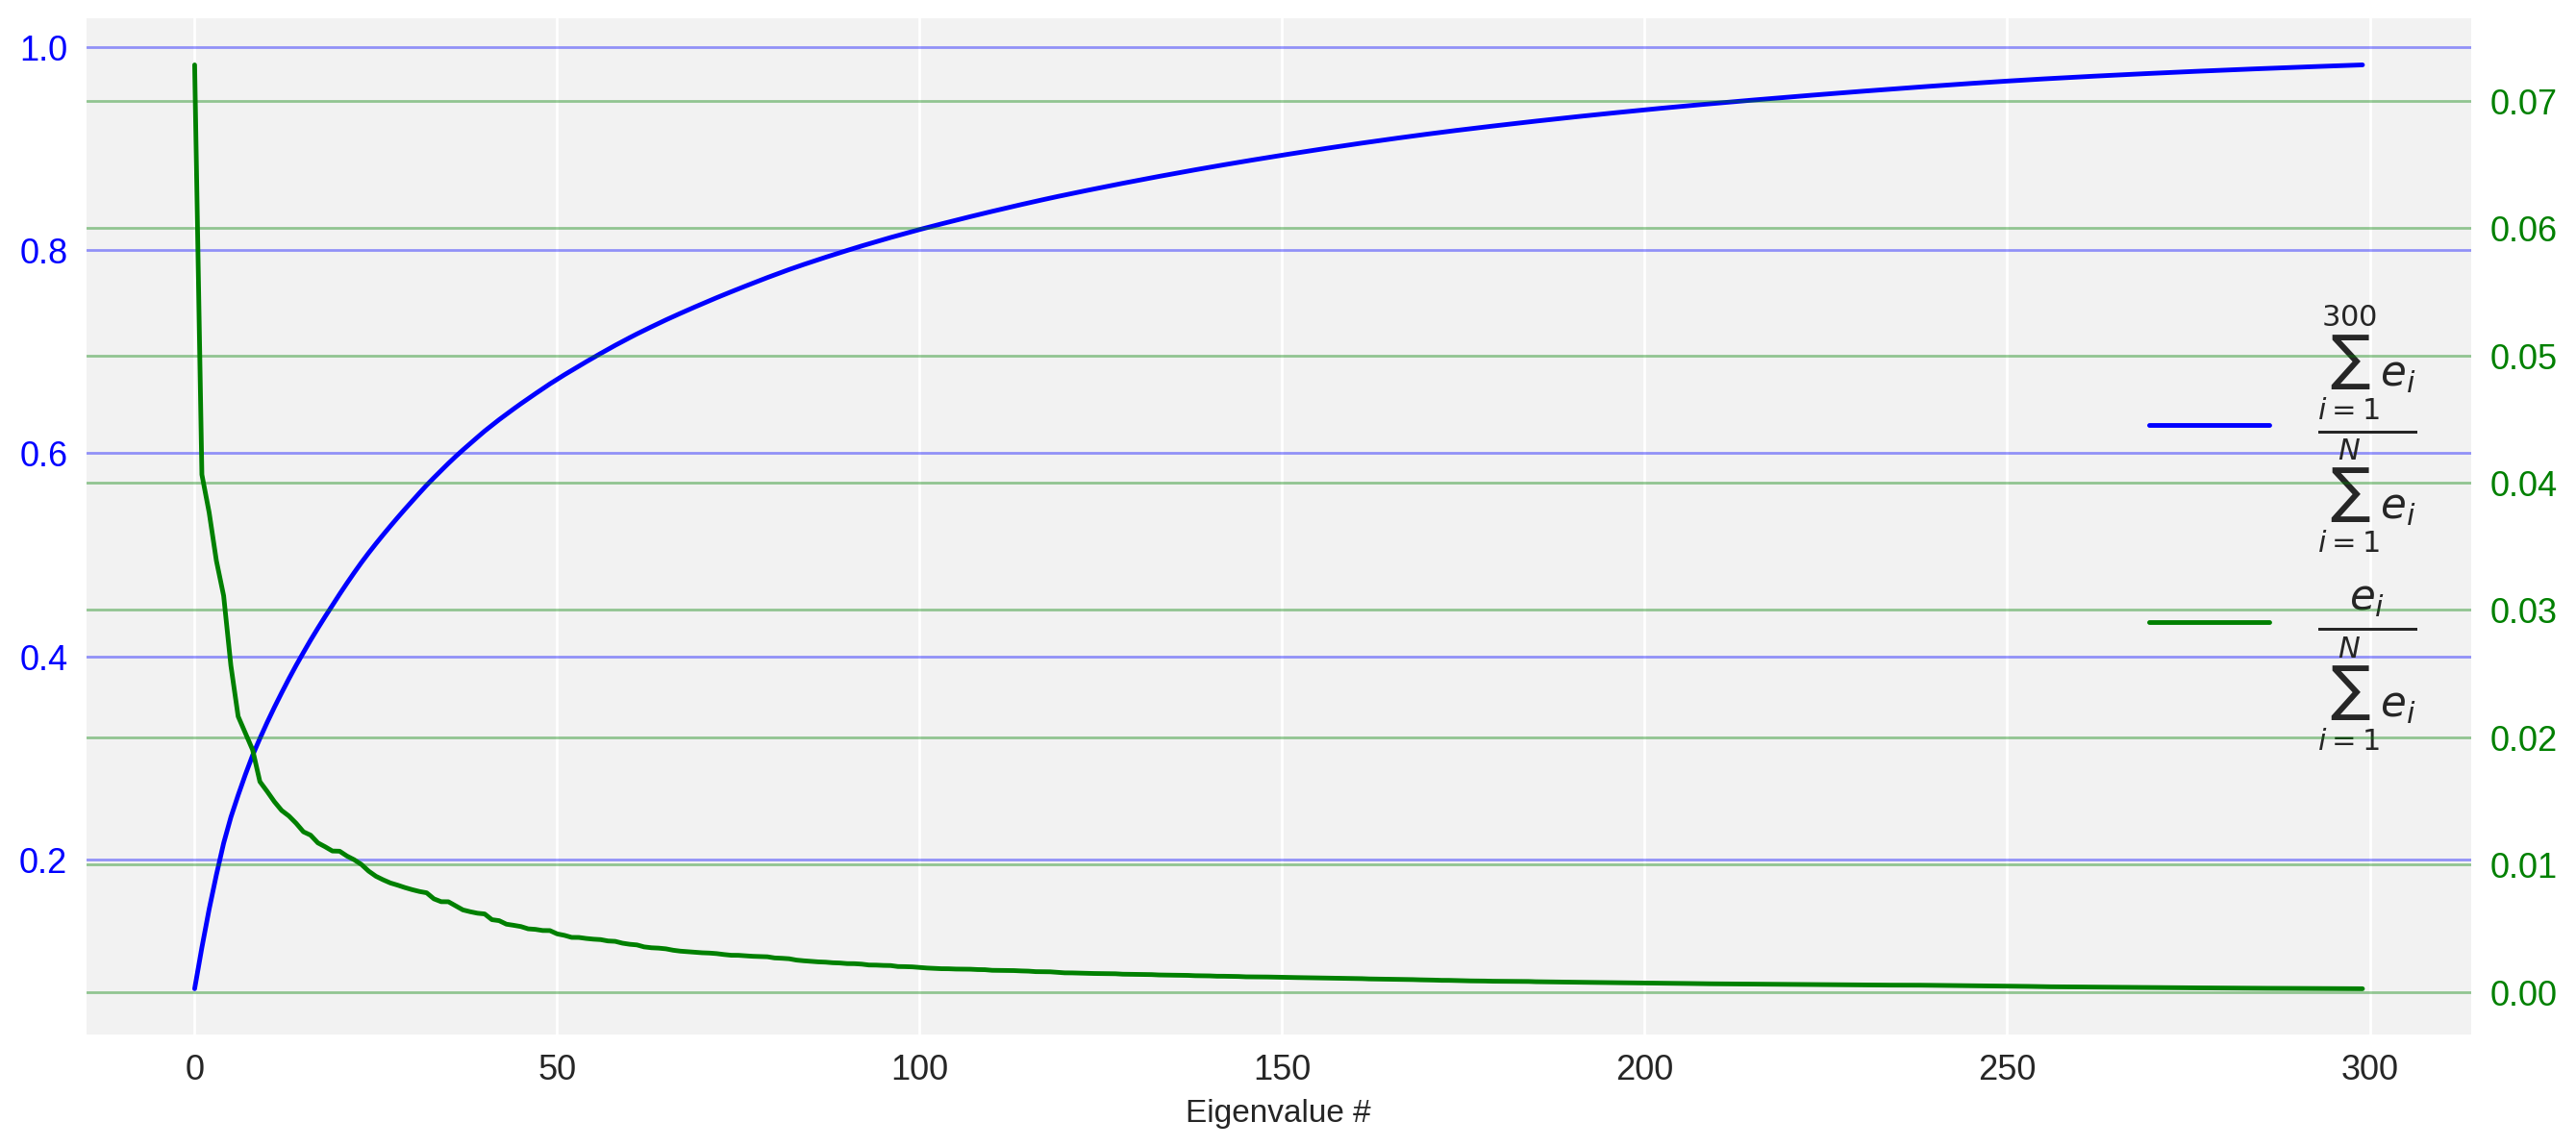

In [180]:
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()
n = 300
l0 = ax0.plot(np.arange(n), np.cumsum(pca.explained_variance_ratio_[:n]),
        label=r'$\frac{\sum_{i = 1}^{300} e_i} {\sum_{i = 1}^{N} e_i}$', color='blue')
l1 = ax1.plot(np.arange(n), pca.explained_variance_ratio_[:n],
        label=r'$\frac{e_i}{\sum_{i=1}^{N} e_i}$', color='green')
ax0.legend([l0[0], l1[0]], [l0[0].get_label(), l1[0].get_label()], fontsize='xx-large', loc='right')
ax0.grid(which='minor')
ax0.set_xlabel('Eigenvalue #') 
ax0.tick_params(axis='y', colors='blue')
ax1.tick_params(axis='y', colors='green')
ax0.yaxis.label.set_color('blue')
ax1.yaxis.label.set_color('green')
ax0.grid(axis='y', color='blue', alpha=0.4)
ax1.grid(axis='y', color='green', alpha=0.4)